In [4]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# from google.colab import drive
# drive.mount("/content/drive")

## 0. Lectura de datos

In [6]:
# DIR = "/content/drive/MyDrive/Data Science/Ms Data mining UBA/1er_cuatrimestre/data_mining/data_mining_pr2/datos"

In [7]:
# df_train = pd.read_csv(f"{DIR}/entrenamiento.zip", index_col="id")
# df_test = pd.read_csv(f"{DIR}/a_predecir.zip", index_col="id")

In [8]:
# df_ent=df_train.copy()
# df_ap=df_test.copy()

In [9]:
df_ent=pd.read_csv("datos/entrenamiento.csv",index_col="id")
df_ap=pd.read_csv("datos/a_predecir.csv",index_col="id")

In [10]:
df_ent.shape

(985180, 24)

## 1. Entender los datos (AID)

## 2. Limpiar y transformar los datos (MD)

In [11]:
# Selección de datos. Cambiar
f0 = df_ent["price"].notna()
f1 = df_ent["l2"] == "Capital Federal"
f2 = df_ent["operation_type"] == 'Venta'
f3=df_ent["property_type"].isin(["Cochera", "Departamento", "Casa"])
f4=(df_ent["currency"] == "USD") | (df_ent["currency"]=="ARS")
f_total= f1&f2&f3&f4
df_ent= df_ent.loc[f_total]

In [12]:
df_ent["start_date"] = pd.to_datetime(df_ent["start_date"])
df_ap["start_date"] = pd.to_datetime(df_ap["start_date"])

In [13]:
(df_ent.columns)

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'price'],
      dtype='object')

In [14]:
df_ent.columns[4:len(df_ent.columns)-1]

Index(['lat', 'lon', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

In [15]:
# df_ent = df_ent.sort_values("start_date", ascending=False)
# df_ent = df_ent.drop_duplicates(subset=df_ent.columns[4:len(df_ent.columns)-1], keep="first")
df_ent = df_ent.sort_values("start_date", ascending=False)
df_ent = df_ent.drop_duplicates(subset=df_ent.columns[4:], keep="first")

In [16]:
df=pd.concat([df_ent,df_ap] , axis=0)
df.shape

(92445, 24)

In [17]:
f_ent = df["price"].notna()
f_ap = df["price"].isna()

### 2.1- Tratamiento l3 y l4

In [18]:
barrios = df["l3"].unique()

for barrio in barrios:
  if pd.notna(barrio):
    f_desc=(df["description"].str.lower().str.contains(barrio.lower()))
    df.loc[f_desc,"l3_descr"] = barrio

for barrio in barrios:
  if pd.notna(barrio):
    f_title= (df["title"].notna())&(df["title"].str.lower().str.contains(barrio.lower()))
    df.loc[f_title,"l3_title"] = barrio

In [19]:
f=(df["l3"].isna()) & (df["l3_title"].notna())
df.loc[f,"l3"] = df.loc[f,"l3_title"].values

In [20]:
df["l3"].isna().sum()

np.int64(5216)

In [21]:
f=(df["l3"].isna()) & (df["l3_title"].isna()) & (df["l3_descr"].notna())
df.loc[f,"l3"] = df.loc[f,"l3_descr"]

In [22]:
f=df["l4"].isna()
df.loc[f,"l4"] = df.loc[f,"l3"].values

In [23]:
f=(df["l4"].isin(df.loc[f_ap,"l4"].unique()))
df=df.loc[f]

In [24]:
df["l4"].isna().sum()

np.int64(4751)

In [25]:
df.columns

Index(['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'price', 'l3_descr',
       'l3_title'],
      dtype='object')

In [26]:
df.drop(columns=["ad_type","created_on","l1","l2","l5","l6","operation_type"] ,inplace=True)

### 2.2- "lat" and "lon"

In [27]:
aux = df["lat"]
df["lat"] = df["lon"]
df["lon"] = aux

In [28]:
f_aux=df["lon"]>-64
lon_min = df.loc[f_ap & f_aux,"lon"].min()
lon_max = df.loc[f_ap & f_aux,"lon"].max()
lat_min = df.loc[f_ap & f_aux,"lat"].min()
lat_max = df.loc[f_ap & f_aux,"lat"].max()
print(lon_min,lon_max , lat_min , lat_max)

-58.5300630656 -58.3586777 -34.69185638 -34.5360918


In [29]:
f= ~((df["lat"] >= lat_min) & (df["lat"]<= lat_max) & (df["lon"]>=lon_min) & (df["lon"]<= lon_max))
df.loc[f ,["lon","lat"]] = pd.NA

In [30]:
df.shape

(92371, 19)

In [31]:
df.loc[f_ap].shape

(7012, 19)

In [32]:
df.loc[f_ent].shape

(85359, 19)

In [33]:
df["l4"].isna().sum()

np.int64(4751)

In [34]:
df.shape

(92371, 19)

<Axes: title={'center': 'df_ap'}, xlabel='lon', ylabel='lat'>

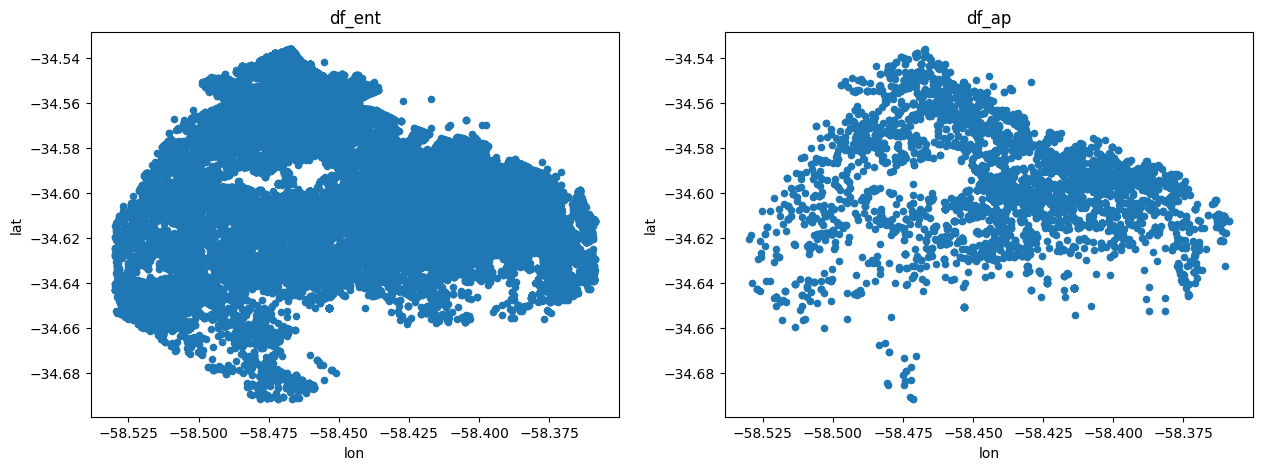

In [35]:
fig , axes = plt.subplots(1,2,figsize=(15,5))

df.loc[f_ent].plot.scatter("lon","lat",ax=axes[0],title="df_ent")
f = df["lon"] > -60
df.loc[f_ap & f].plot.scatter("lon","lat" , ax= axes[1],title="df_ap")


In [36]:
coordenadas_media = df.groupby("l4")[["lon","lat"]].mean()
coordenadas_media

lon        lat
l4                                        
Abasto               -58.412487 -34.604079
Agronomía            -58.488478 -34.594679
Almagro              -58.421899 -34.606568
Balvanera            -58.404096 -34.610862
Barracas             -58.374780 -34.637015
Barrio Norte         -58.401959 -34.593233
Belgrano             -58.453322 -34.562882
Boca                 -58.364568 -34.632859
Boedo                -58.418043 -34.627044
Caballito            -58.442178 -34.617794
Centro / Microcentro -58.381826 -34.603579
Chacarita            -58.449900 -34.587706
Coghlan              -58.474454 -34.561242
Colegiales           -58.452008 -34.576909
Congreso             -58.395125 -34.608719
Constitución         -58.385637 -34.623879
Flores               -58.463241 -34.628705
Floresta             -58.485217 -34.630243
Las Cañitas          -58.434343 -34.568884
Liniers              -58.518749 -34.644361
Mataderos            -58.503227 -34.653924
Monserrat            -58.383973 -34.614085
Monte Castro         -58.503893 -34.619931
Nuñez                -58.464665 -34.548435
Once                 -58.404728 -34.606781
Palermo              -58.423507 -34.584015
Palermo Chico        -58.408906 -34.579404
Palermo Hollywood    -58.435729 -34.581240
Palermo Soho         -58.425292 -34.586953
Palermo Viejo        -58.420156 -34.586909
Parque Avellaneda    -58.478008 -34.644112
Parque Centenario    -58.434237 -34.605327
Parque Chacabuco     -58.437278 -34.636535
Parque Chas          -58.477464 -34.585262
Parque Patricios     -58.403406 -34.634417
Paternal             -58.464662 -34.603347
Pompeya              -58.416793 -34.646022
Puerto Madero        -58.363174 -34.612888
Recoleta             -58.396185 -34.592165
Retiro               -58.379120 -34.595942
Saavedra             -58.483184 -34.551761
San Cristobal        -58.400629 -34.622468
San Nicolás          -58.383427 -34.603566
San Telmo            -58.374890 -34.620475
Tribunales           -58.395133 -34.600361
Velez Sarsfield      -58.491751 -34.632530
Versalles            -58.518285 -34.628554
Villa Crespo         -58.440473 -34.598131
Villa Devoto         -58.510813 -34.603499
Villa General Mitre  -58.467991 -34.609050
Villa Lugano         -58.473626 -34.675843
Villa Luro           -58.501803 -34.638709
Villa Ortuzar        -58.468791 -34.581865
Villa Pueyrredón     -58.500775 -34.584585
Villa Real           -58.523632 -34.620332
Villa Santa Rita     -58.481959 -34.615545
Villa Urquiza        -58.484698 -34.574550
Villa del Parque     -58.488403 -34.606225

In [37]:
df["lon"].isna().sum()

np.int64(10383)

In [38]:
df["l4"].isna().sum()

np.int64(4751)

In [39]:
((df["lat"].isna())&(df["l4"].isna())).sum()

np.int64(4718)

In [40]:
((df["lat"].isna())&(df["l4"].notna())).sum()

np.int64(5665)

In [41]:
((df["lat"].notna())&(df["l4"].isna())).sum()

np.int64(33)

In [42]:
df.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l3', 'l4', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'description', 'property_type', 'price',
       'l3_descr', 'l3_title'],
      dtype='object')

In [43]:
barrios = df["l4"].unique()
for l4 in barrios :
  if pd.notna(l4):
    f = df["l4"] == l4
    f2= (df["lon"].isna()) & (df["lat"].isna())
    df.loc[f&f2,["lon","lat"]] = coordenadas_media.loc[l4].values

In [44]:
df["lat"].isna().sum()

np.int64(4718)

In [45]:
df[f_ap].shape

C:\Users\chris\AppData\Local\Temp\ipykernel_13868\3675210368.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[f_ap].shape


(7012, 19)

In [46]:
f=df["l4"].notna()
df=df.loc[f | f_ap]

In [47]:
df["lat"].isna().sum()

np.int64(4)

<Axes: title={'center': 'df_ap'}, xlabel='lon', ylabel='lat'>

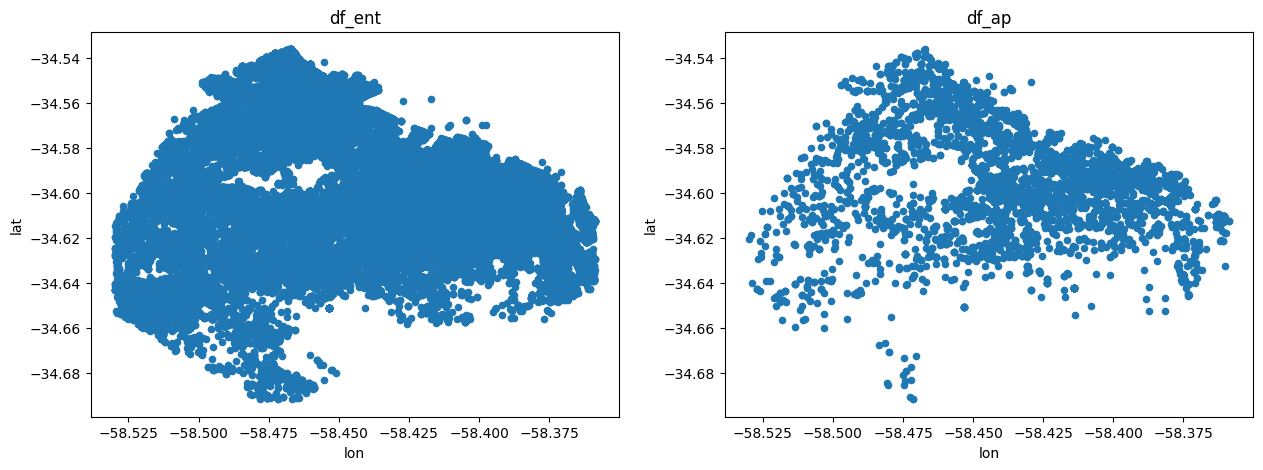

In [48]:
fig , axes = plt.subplots(1,2,figsize=(15,5))

df.loc[f_ent].plot.scatter("lon","lat",ax=axes[0],title="df_ent")
df.loc[f_ap].plot.scatter("lon","lat" , ax= axes[1],title="df_ap")

In [49]:
df["dataset"]=np.zeros(df.shape[0])

In [50]:
df.loc[f_ent,"dataset"] = 1

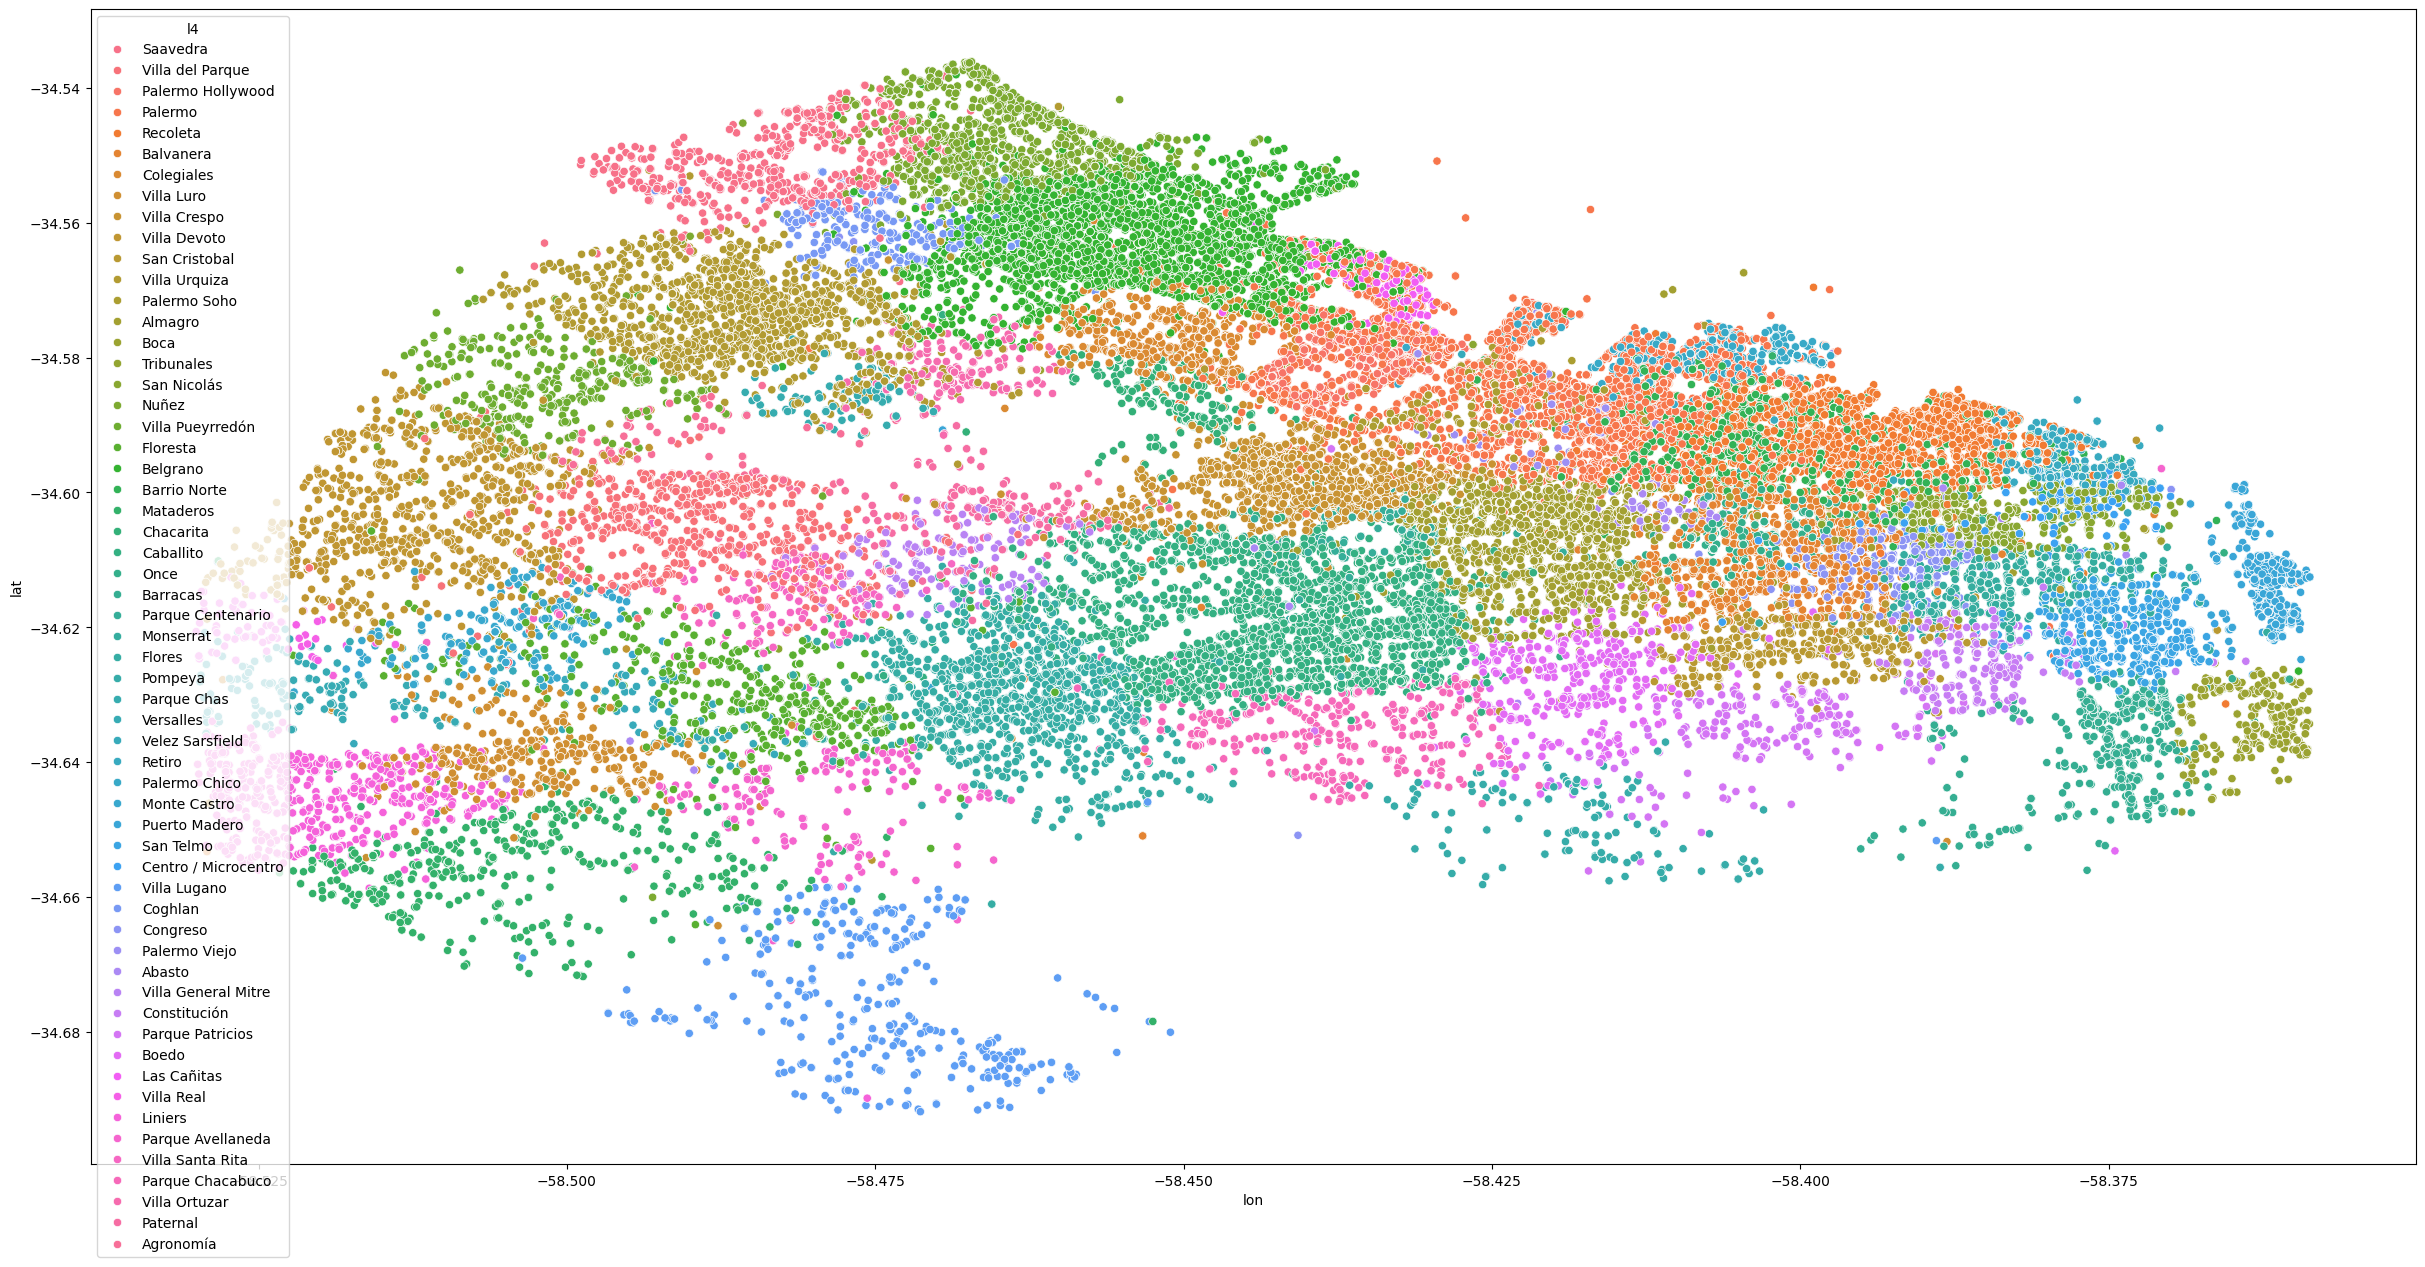

In [51]:
plt.figure(figsize=(30, 15))
sns.scatterplot(df,x="lon",y="lat" , hue="l4")
plt.show()

<Axes: xlabel='lon', ylabel='lat'>

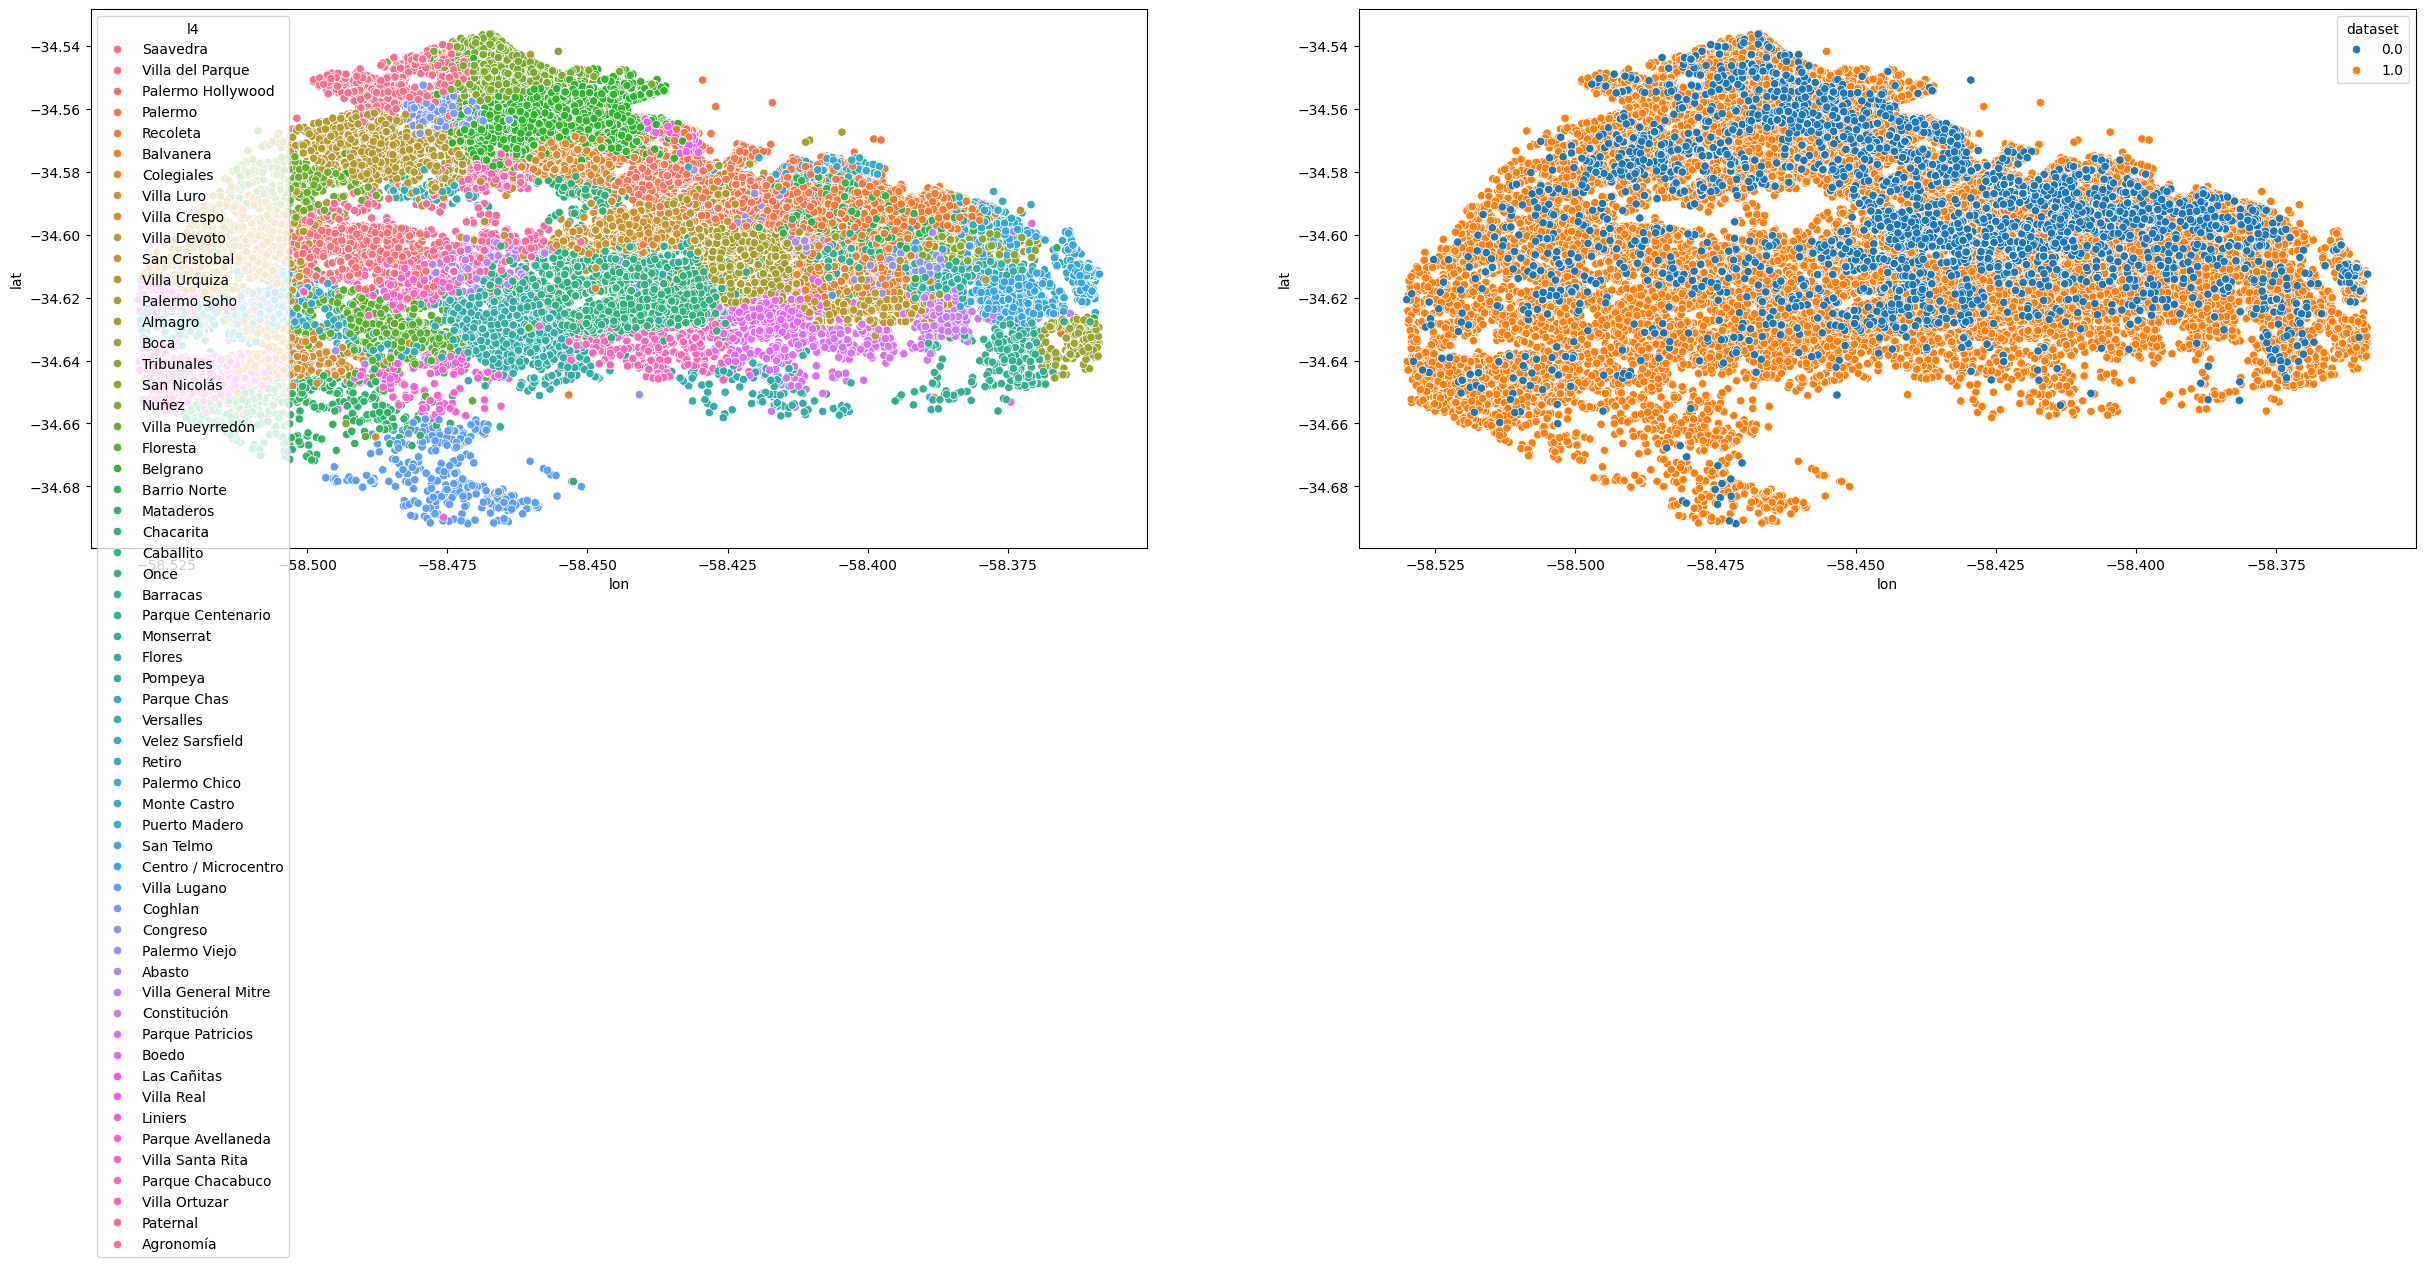

In [52]:
fig,axes=plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(df,x="lon",y="lat" , hue="l4",ax=axes[0])
sns.scatterplot(df , x="lon",y="lat",hue="dataset",ax=axes[1])

In [53]:
df.loc[f_ap].shape

(7012, 20)

### 2.2- "Surface total" & "Surface covered

* covered o total NULL pero la otra no --> *Llenarla con la otra*
* covered o total 0 pero la otra no --> *Llenarla con la otra*
* surface_covered > surface_total
    * Surface_covered con 0 de mas --> *Dividir por 10/100/1000*
    * Surface_total con 0 de menos --> *Mult por 10/100/1000*
    * Surface_covered en el lugar del surface_total --> *Darlas vuelta*
* outlayers
* covered y total NULL --> *Solo hay en ent (16136 registros)*
* covered y total ceros --> *Solo hay en ent(9 registros)*




#### covered o total NULL pero la otra no

In [54]:
f =( df["surface_total"].isna() ) & (df["surface_covered"].notna())
df.loc[f,"surface_total"] = df.loc[f,"surface_covered"].values

In [55]:
f =( df["surface_covered"].isna() ) & (df["surface_total"].notna())
df.loc[f,"surface_covered"] = df.loc[f,"surface_total"].values

In [56]:
df.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l3', 'l4', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'description', 'property_type', 'price',
       'l3_descr', 'l3_title', 'dataset'],
      dtype='object')

#### covered o total 0 pero la otra no

In [57]:
f =(  df["surface_total"] != 0) &  (df["surface_covered"]==0)
df.loc[f,["surface_covered" , "surface_total"]]

Empty DataFrame
Columns: [surface_covered, surface_total]
Index: []

In [58]:
f =(  df["surface_total"] == 0) &  (df["surface_covered"]!=0)
df.loc[f&f_ap,["surface_covered" , "surface_total"]]

Empty DataFrame
Columns: [surface_covered, surface_total]
Index: []

#### cero en ambas

In [59]:
f =(  df["surface_covered"] == 0) &  (df["surface_total"]==0)
df.loc[f&f_ent]

start_date    end_date        lat        lon             l3  \
id                                                                   
340198 2019-11-20  2020-05-29 -34.621264 -58.361322  Puerto Madero   
547908 2019-11-14  2020-05-29 -34.618351 -58.360425  Puerto Madero   
548431 2019-11-14  2020-05-29 -34.610994 -58.363366  Puerto Madero   
546891 2019-11-14  2020-05-29 -34.590181 -58.395789       Recoleta   
388754 2019-10-29  2020-05-29 -34.590225 -58.395774       Recoleta   
388752 2019-10-29  2020-05-29 -34.589546 -58.397364       Recoleta   
151194 2019-10-16  2020-05-29 -34.593233 -58.401959   Barrio Norte   
549385 2019-10-09  2020-05-29 -34.618869 -58.361004  Puerto Madero   
425656 2019-09-19  2020-05-29 -34.604392 -58.363687  Puerto Madero   
198877 2019-07-05  2019-09-19 -34.610994 -58.363366  Puerto Madero   

                   l4  rooms  bedrooms  bathrooms  surface_total  \
id                                                                 
340198  Puerto Madero    NaN       2.0        3.0            0.0   
547908  Puerto Madero    NaN       1.0        2.0            0.0   
548431  Puerto Madero    NaN       2.0        2.0            0.0   
546891       Recoleta    NaN       NaN        1.0            0.0   
388754       Recoleta    NaN       NaN        1.0            0.0   
388752       Recoleta    NaN       NaN        1.0            0.0   
151194   Barrio Norte    NaN       NaN        NaN            0.0   
549385  Puerto Madero    NaN       NaN        1.0            0.0   
425656  Puerto Madero    NaN       1.0        2.0            0.0   
198877  Puerto Madero    NaN       3.0        3.0            0.0   

        surface_covered currency price_period  \
id                                              
340198              0.0      USD      Mensual   
547908              0.0      USD      Mensual   
548431              0.0      USD      Mensual   
546891              0.0      USD      Mensual   
388754              0.0      USD      Mensual   
388752              0.0      USD      Mensual   
151194              0.0      USD      Mensual   
549385              0.0      USD      Mensual   
425656              0.0      USD      Mensual   
198877              0.0      USD      Mensual   

                                                    title  \
id                                                          
340198  Art Maria - 3 ambientes con excelente vista a ...   
547908  Zencity - Espectacular 2 ambientes con la mejo...   
548431  B.A HOUSES - 3 ambientes,  vista al dique y O....   
546891   Recoleta - Excelente Monoambiente. Oportunidad!!   
388754               Recoleta - Departamento monoambiente   
388752   Recoleta - Monoambiente con excelentes amenities   
151194                                               CABA   
549385       Zencity - Monoambiente con vista al complejo   
425656  Torres del Yacht - 2 ambientes con excelente v...   
198877       Terrazas del Dique - 4 ambientes con cochera   

                                              description property_type  \
id                                                                        
340198  ART MARIA. DEPARTAMENTO 3 AMBIENTES DE 125 m2,...  Departamento   
547908  DEPARTAMENTO 2 AMBIENTES UBICADO EN EL COMPLEJ...  Departamento   
548431  Edificio BA Houses situado frente al Dique 3 d...  Departamento   
546891  Departamentos monoambiente con excelente ubica...  Departamento   
388754  Departamentos monoambiente con excelente ubica...  Departamento   
388752  Departamento monoambiente con excelente ubicac...  Departamento   
151194  DEPARTAMENTO DE 2 AMBIENTES 1ºPiso<br>COMODIDA...  Departamento   
549385  Departamento  monoambiente de 38 m2 .<br>El de...  Departamento   
425656  DEPARTAMENTO DE 2 AMBIENTES 63 m2 CON EXCELENT...  Departamento   
198877  OPORTUNIDAD DE INVERSIÓN! <br><br>Terrazas del...  Departamento   

           price       l3_descr       l3_title  dataset  
id                                                       
340198  72

#### nan en ambas

In [60]:
f =(  df["surface_covered"].isna()) &  (df["surface_total"].isna())
df.loc[f&f_ent].shape

(17733, 20)

#### covered > total

In [61]:
df["cov/total"]=df["surface_covered"] / df["surface_total"]

In [62]:
f = df["cov/total"] >1
print(f"cantidad en ent:{df.loc[f & f_ent].shape}")
print(f"cantidad en ap:{df.loc[f & f_ap].shape}")

cantidad en ent:(726, 21)
cantidad en ap:(27, 21)


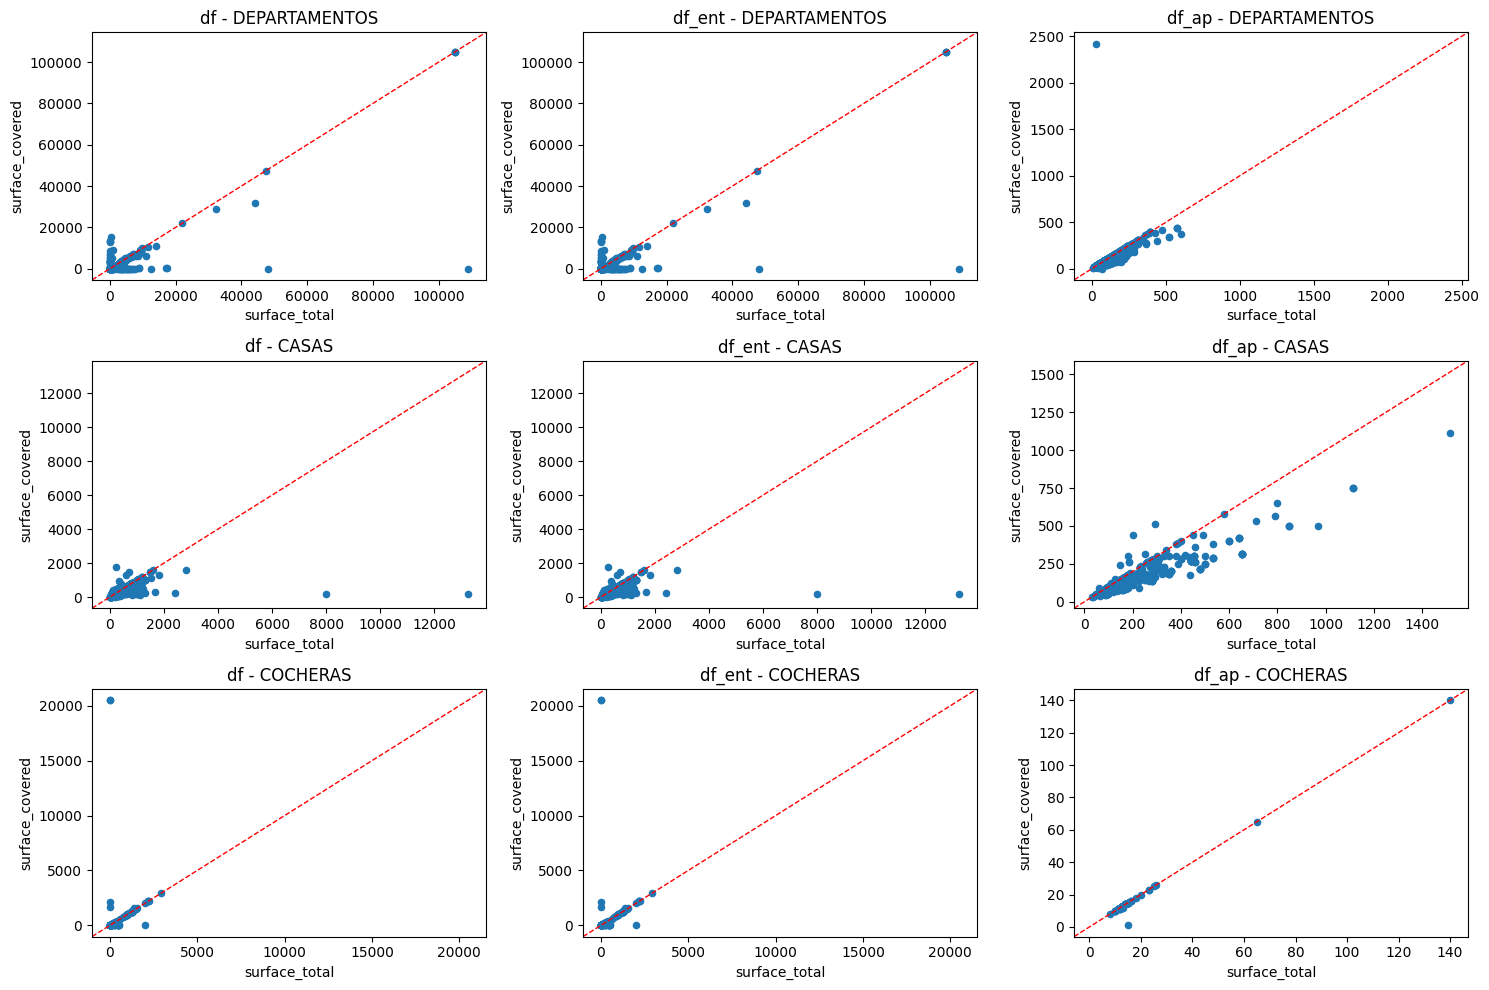

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Departamento
f_dpto = df["property_type"] == "Departamento"
df.loc[f_dpto].plot.scatter("surface_total", "surface_covered", ax=axes[0, 0])
axes[0, 0].set_title("df - DEPARTAMENTOS")

df.loc[f_dpto & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[0, 1])
axes[0, 1].set_title("df_ent - DEPARTAMENTOS")

df.loc[f_dpto & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[0, 2])
axes[0, 2].set_title("df_ap - DEPARTAMENTOS")

# Casa
f_casa = df["property_type"] == "Casa"
df.loc[f_casa].plot.scatter("surface_total", "surface_covered", ax=axes[1, 0])
axes[1, 0].set_title("df - CASAS")

df.loc[f_casa & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[1, 1])
axes[1, 1].set_title("df_ent - CASAS")

df.loc[f_casa & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[1, 2])
axes[1, 2].set_title("df_ap - CASAS")

# Cochera
f_coch = df["property_type"] == "Cochera"
df.loc[f_coch].plot.scatter("surface_total", "surface_covered", ax=axes[2, 0])
axes[2, 0].set_title("df - COCHERAS")

df.loc[f_coch & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[2, 1])
axes[2, 1].set_title("df_ent - COCHERAS")

df.loc[f_coch & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[2, 2])
axes[2, 2].set_title("df_ap - COCHERAS")

for ax in axes.flatten():
    lims = [
        np.min([*ax.get_xlim(), *ax.get_ylim()]),
        np.max([*ax.get_xlim(), *ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()


In [64]:
f = df["cov/total"] > 1000
df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"]/1000

In [65]:
f = (df["cov/total"] >= 100) & (df["cov/total"] < 1000)
df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"]/100

In [66]:
f = (df["cov/total"] >= 50) & (df["cov/total"] < 100)
df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"]/100

In [67]:
f = (df["cov/total"] >= 10) & (df["cov/total"] < 50)
df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"]/10

In [68]:
f = (df["cov/total"] >= 5) & (df["cov/total"] < 10) &(df["surface_total"] > 30)
df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"] / 10

In [69]:
f = (df["cov/total"] >= 5) & (df["cov/total"] < 10) &(df["surface_total"] < 30)
df.loc[f,"surface_total"] = df.loc[f,"surface_total"] * 10

In [70]:
f = (df["cov/total"] >= 2) & (df["cov/total"] <5) & (df["surface_total"] < 42.5 )
df.loc[f,"surface_total"] = df.loc[f,"surface_total"]+df.loc[f,"surface_covered"]


In [71]:
f= df["surface_covered"] > df["surface_total"]
temp = df.loc[f,"surface_covered"]
df.loc[f,"surface_covered"] = df.loc[f,"surface_total"]
df.loc[f,"surface_total"] = temp

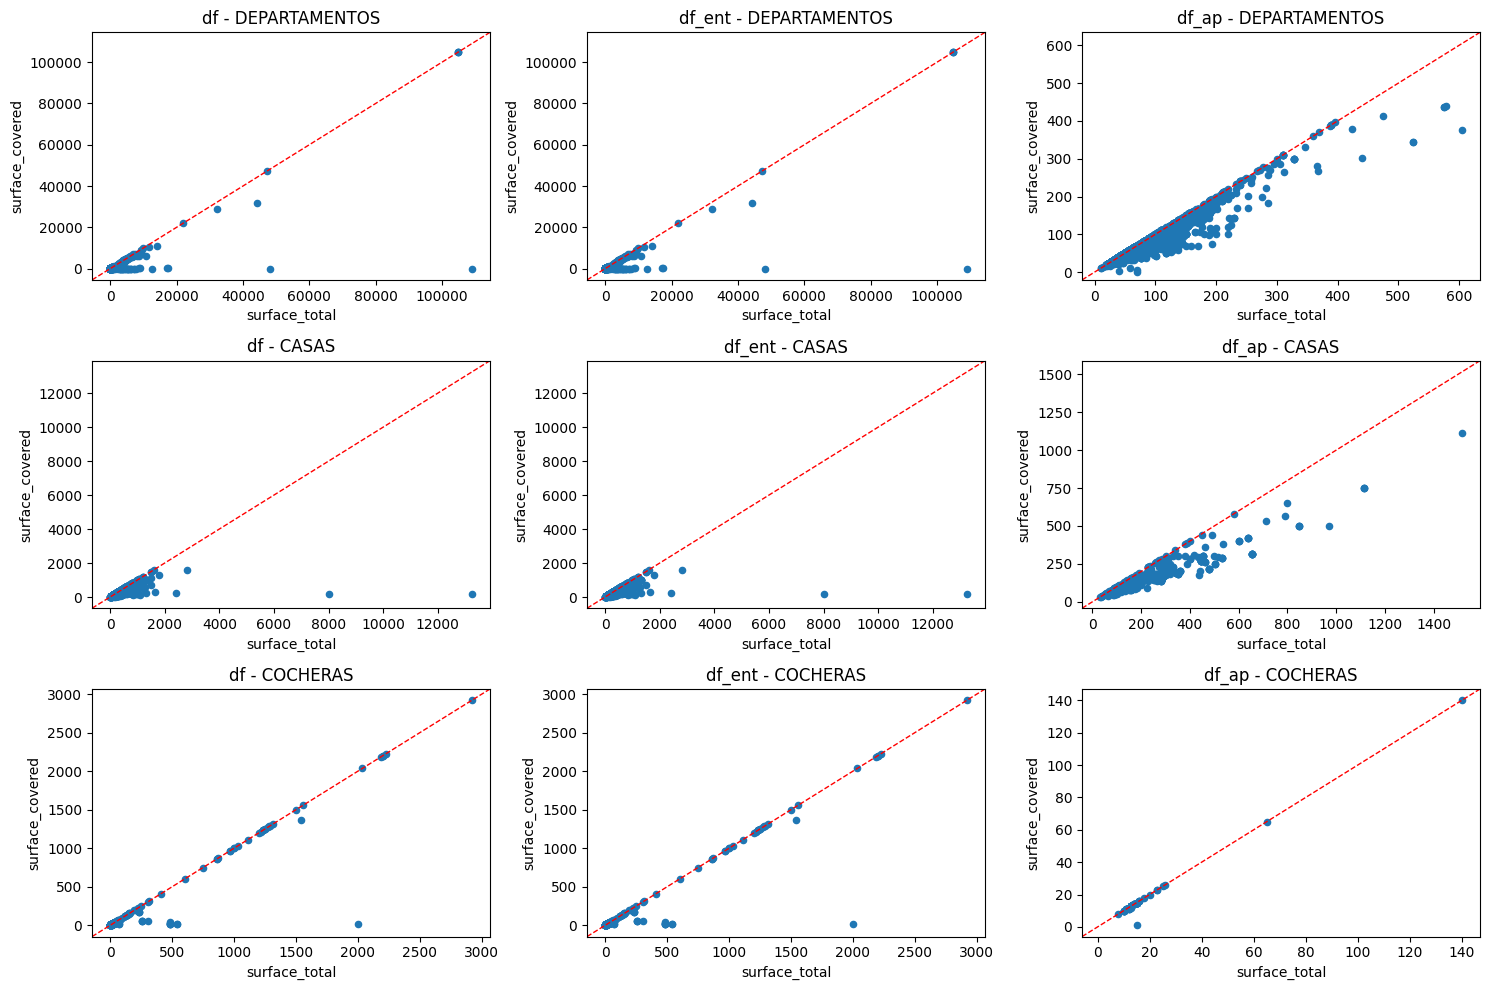

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Departamento
f_dpto = df["property_type"] == "Departamento"
df.loc[f_dpto].plot.scatter("surface_total", "surface_covered", ax=axes[0, 0])
axes[0, 0].set_title("df - DEPARTAMENTOS")

df.loc[f_dpto & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[0, 1])
axes[0, 1].set_title("df_ent - DEPARTAMENTOS")

df.loc[f_dpto & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[0, 2])
axes[0, 2].set_title("df_ap - DEPARTAMENTOS")

# Casa
f_casa = df["property_type"] == "Casa"
df.loc[f_casa].plot.scatter("surface_total", "surface_covered", ax=axes[1, 0])
axes[1, 0].set_title("df - CASAS")

df.loc[f_casa & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[1, 1])
axes[1, 1].set_title("df_ent - CASAS")

df.loc[f_casa & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[1, 2])
axes[1, 2].set_title("df_ap - CASAS")

# Cochera
f_coch = df["property_type"] == "Cochera"
df.loc[f_coch].plot.scatter("surface_total", "surface_covered", ax=axes[2, 0])
axes[2, 0].set_title("df - COCHERAS")

df.loc[f_coch & f_ent].plot.scatter("surface_total", "surface_covered", ax=axes[2, 1])
axes[2, 1].set_title("df_ent - COCHERAS")

df.loc[f_coch & f_ap].plot.scatter("surface_total", "surface_covered", ax=axes[2, 2])
axes[2, 2].set_title("df_ap - COCHERAS")

for ax in axes.flatten():
    lims = [
        np.min([*ax.get_xlim(), *ax.get_ylim()]),
        np.max([*ax.get_xlim(), *ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()

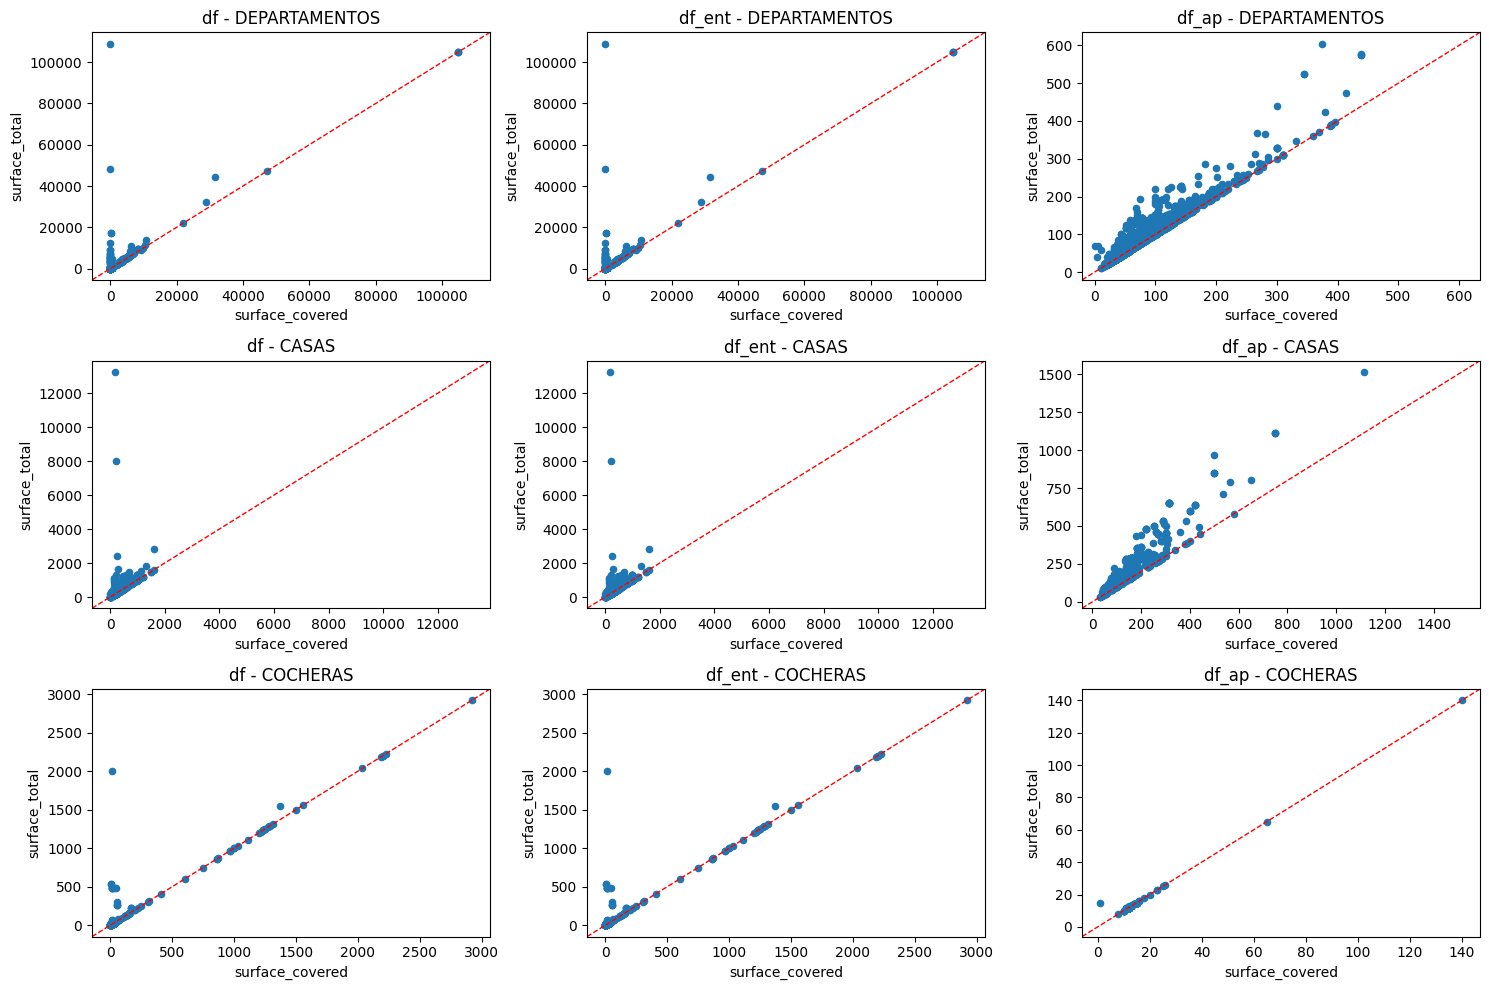

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Departamento
f_dpto = df["property_type"] == "Departamento"
df.loc[f_dpto].plot.scatter("surface_covered", "surface_total", ax=axes[0, 0])
axes[0, 0].set_title("df - DEPARTAMENTOS")

df.loc[f_dpto & f_ent].plot.scatter("surface_covered", "surface_total", ax=axes[0, 1])
axes[0, 1].set_title("df_ent - DEPARTAMENTOS")

df.loc[f_dpto & f_ap].plot.scatter("surface_covered", "surface_total", ax=axes[0, 2])
axes[0, 2].set_title("df_ap - DEPARTAMENTOS")

# Casa
f_casa = df["property_type"] == "Casa"
df.loc[f_casa].plot.scatter("surface_covered", "surface_total", ax=axes[1, 0])
axes[1, 0].set_title("df - CASAS")

df.loc[f_casa & f_ent].plot.scatter("surface_covered", "surface_total", ax=axes[1, 1])
axes[1, 1].set_title("df_ent - CASAS")

df.loc[f_casa & f_ap].plot.scatter("surface_covered", "surface_total", ax=axes[1, 2])
axes[1, 2].set_title("df_ap - CASAS")

# Cochera
f_coch = df["property_type"] == "Cochera"
df.loc[f_coch].plot.scatter("surface_covered", "surface_total", ax=axes[2, 0])
axes[2, 0].set_title("df - COCHERAS")

df.loc[f_coch & f_ent].plot.scatter("surface_covered", "surface_total", ax=axes[2, 1])
axes[2, 1].set_title("df_ent - COCHERAS")

df.loc[f_coch & f_ap].plot.scatter("surface_covered", "surface_total", ax=axes[2, 2])
axes[2, 2].set_title("df_ap - COCHERAS")

for ax in axes.flatten():
    lims = [
        np.min([*ax.get_xlim(), *ax.get_ylim()]),
        np.max([*ax.get_xlim(), *ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()

#### Outlayers

In [74]:
df.columns


Index(['start_date', 'end_date', 'lat', 'lon', 'l3', 'l4', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'description', 'property_type', 'price',
       'l3_descr', 'l3_title', 'dataset', 'cov/total'],
      dtype='object')

In [75]:
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [76]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100

In [77]:
f_dpto=df["property_type"]=="Departamento"
f_casa=df["property_type"]=="Casa"
f_coch=df["property_type"]=="Cochera"

In [78]:
(df["surface_covered"] > df["surface_total"]).sum()

np.int64(0)

-----
##### Departamento

<Axes: xlabel='surface_covered', ylabel='surface_total'>

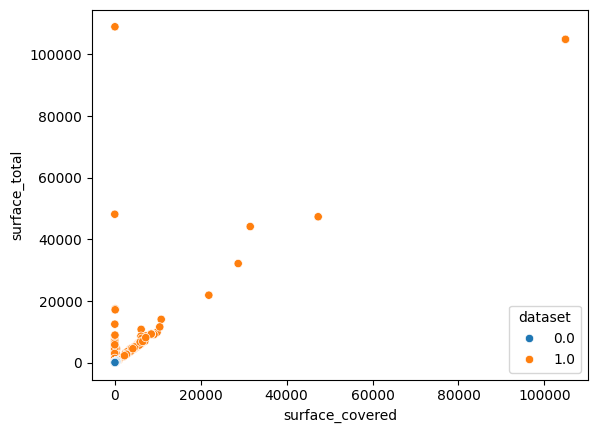

In [79]:
sns.scatterplot(data=df.loc[f_dpto],x="surface_covered",y="surface_total",hue="dataset")


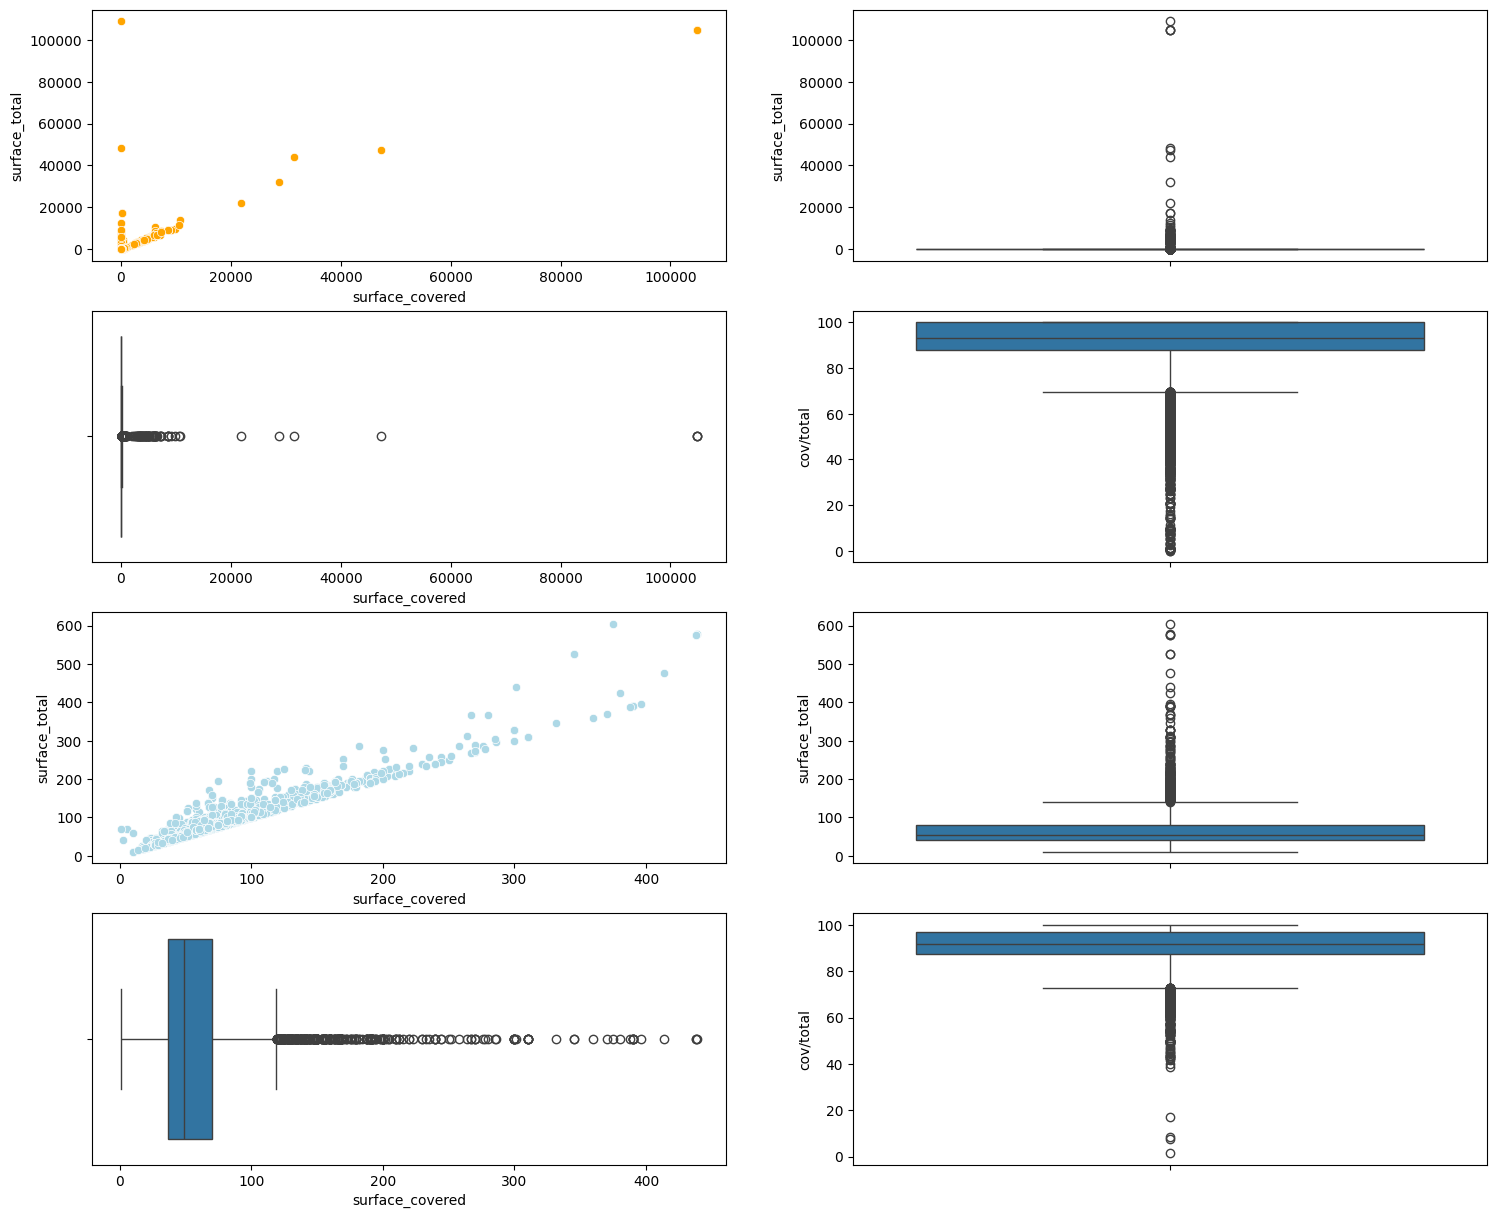

In [80]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_dpto & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_dpto & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_dpto & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_dpto & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ap],ax=axes[3,1])

plt.show()

1ero analizamos df_ap
- Maximos --> minimos --> Min cov/tot   

In [81]:
df.loc[f_ap & f_dpto,["surface_covered","surface_total","cov/total","property_type"]].sort_values(by="surface_covered",ascending=True)

surface_covered  surface_total   cov/total property_type
id                                                              
229429              1.0           69.0    1.449275  Departamento
958215              3.0           40.0    7.500000  Departamento
177919              6.0           70.0    8.571429  Departamento
413623             10.0           10.0  100.000000  Departamento
328188             10.0           58.0   17.241379  Departamento
...                 ...            ...         ...           ...
697874            396.0          396.0  100.000000  Departamento
188774            414.0          475.0   87.157895  Departamento
332969            438.0          576.0   76.041667  Departamento
216131            438.0          576.0   76.041667  Departamento
176709            439.0          578.0   75.951557  Departamento

[6596 rows x 4 columns]

In [82]:
df.loc[[413623,31798],"property_type"	] = "Cochera"

In [83]:
f_dpto = df["property_type"] =="Departamento"
f_casa =df["property_type"]=="Casa"
f_coch=df["property_type"] == "Cochera"

In [84]:
f=df["surface_covered"]<=10
df.loc[[229429,958215],"surface_covered"	]=df.loc[[229429,958215],"surface_total"].values - 5
df.loc[[177919,328188],"surface_covered"]=df.loc[[177919,328188],"surface_total"].values - df.loc[[177919,328188],"surface_covered"].values

In [85]:
df.loc[[229429,958215],["surface_covered","surface_total"]]

surface_covered  surface_total
id                                    
229429             64.0           69.0
958215             35.0           40.0

In [86]:
(df["surface_covered"]>df["surface_total"]).sum()

np.int64(0)

In [87]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [88]:
f1=df["surface_total"]/ 1000 >=20
f2=(df["surface_total"]/ 1000 <20)&(df["surface_total"]/100>=20 )
df.loc[f_ent & f_dpto & f1,"surface_total"] = df.loc[f_ent & f_dpto & f1,"surface_total"]/1000
df.loc[f_ent & f_dpto & f2,"surface_total"] = df.loc[f_ent & f_dpto & f2,"surface_total"]/100

In [89]:
f1=df["surface_covered"]/ 1000 >=20
f2=(df["surface_covered"]/ 1000 <20)&(df["surface_covered"]/100>=20 )
df.loc[f_ent & f_dpto & f1,"surface_covered"] = df.loc[f_ent & f_dpto & f1,"surface_covered"]/1000
df.loc[f_ent & f_dpto & f2,"surface_covered"] = df.loc[f_ent & f_dpto & f2,"surface_covered"]/100

In [90]:
f=(df["surface_total"] < df["surface_covered"])
df.loc[f,["surface_covered","surface_total","cov/total","title","description"]]

surface_covered  surface_total  cov/total  \
id                                                  
260308             25.0          24.50   1.020408   
119565            275.0          32.37   8.495521   
255230            442.0          45.45   9.724972   
4450              321.0          32.33   9.928859   

                                                    title  \
id                                                          
260308  Av J de Garay 800 departamento de 1 Amb sin ex...   
119565         VENTA MONOAMBIENTE PALERMO SOHO DESARROLLO   
255230              Departamento 2 Ambientes Monte Castro   
4450                               Departamento - Centro-   

                                              description  
id                                                         
260308  CODIGO: 3040-JMB 7779 ubicado en: Av Juan de G...  
119565  Corredor Responsable: GRACIELA Y. MENAZZI - CP...  
255230  Corredor Responsable: ELEONORA MEDEOT MINUJEN ...  
4450    ,jhgwvsd,jhbs.dukjs<br>d<br>sd<br>c<br>sdc<br>...

In [91]:
df.loc[260308,["surface_covered","surface_total"]] = df.loc[260308,["surface_total","surface_covered"]].values
df.loc[[119565,255230,4450],"surface_covered"] = df.loc[[119565,255230,4450],"surface_covered"]/10
df.loc[[260308,119565,255230,4450],["surface_covered","surface_total","cov/total","title","description"]]


surface_covered  surface_total  cov/total  \
id                                                  
260308             24.5          25.00   1.020408   
119565             27.5          32.37   8.495521   
255230             44.2          45.45   9.724972   
4450               32.1          32.33   9.928859   

                                                    title  \
id                                                          
260308  Av J de Garay 800 departamento de 1 Amb sin ex...   
119565         VENTA MONOAMBIENTE PALERMO SOHO DESARROLLO   
255230              Departamento 2 Ambientes Monte Castro   
4450                               Departamento - Centro-   

                                              description  
id                                                         
260308  CODIGO: 3040-JMB 7779 ubicado en: Av Juan de G...  
119565  Corredor Responsable: GRACIELA Y. MENAZZI - CP...  
255230  Corredor Responsable: ELEONORA MEDEOT MINUJEN ...  
4450    ,jhgwvsd,jhbs.dukjs<br>d<br>sd<br>c<br>sdc<br>...

In [92]:
f = df["surface_covered"] < 14
df.loc[f_ent & f_dpto & f ,["surface_covered"]] = pd.NA

In [93]:
f = df["surface_total"] < 14
df.loc[f_ent & f_dpto & f ,["surface_total"]] = pd.NA

In [94]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [95]:
(df["surface_covered"] >df["surface_total"]).sum()

np.int64(0)

In [96]:
# Modificar
# f=(df["cov/total"]>100)
# df.loc[f,"surface_covered"] = df.loc[f,"surface_covered"] /10

f=(df["cov/total"]>100)
df.loc[f,["surface_covered","surface_total","cov/total","property_type"]]

Empty DataFrame
Columns: [surface_covered, surface_total, cov/total, property_type]
Index: []

In [97]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

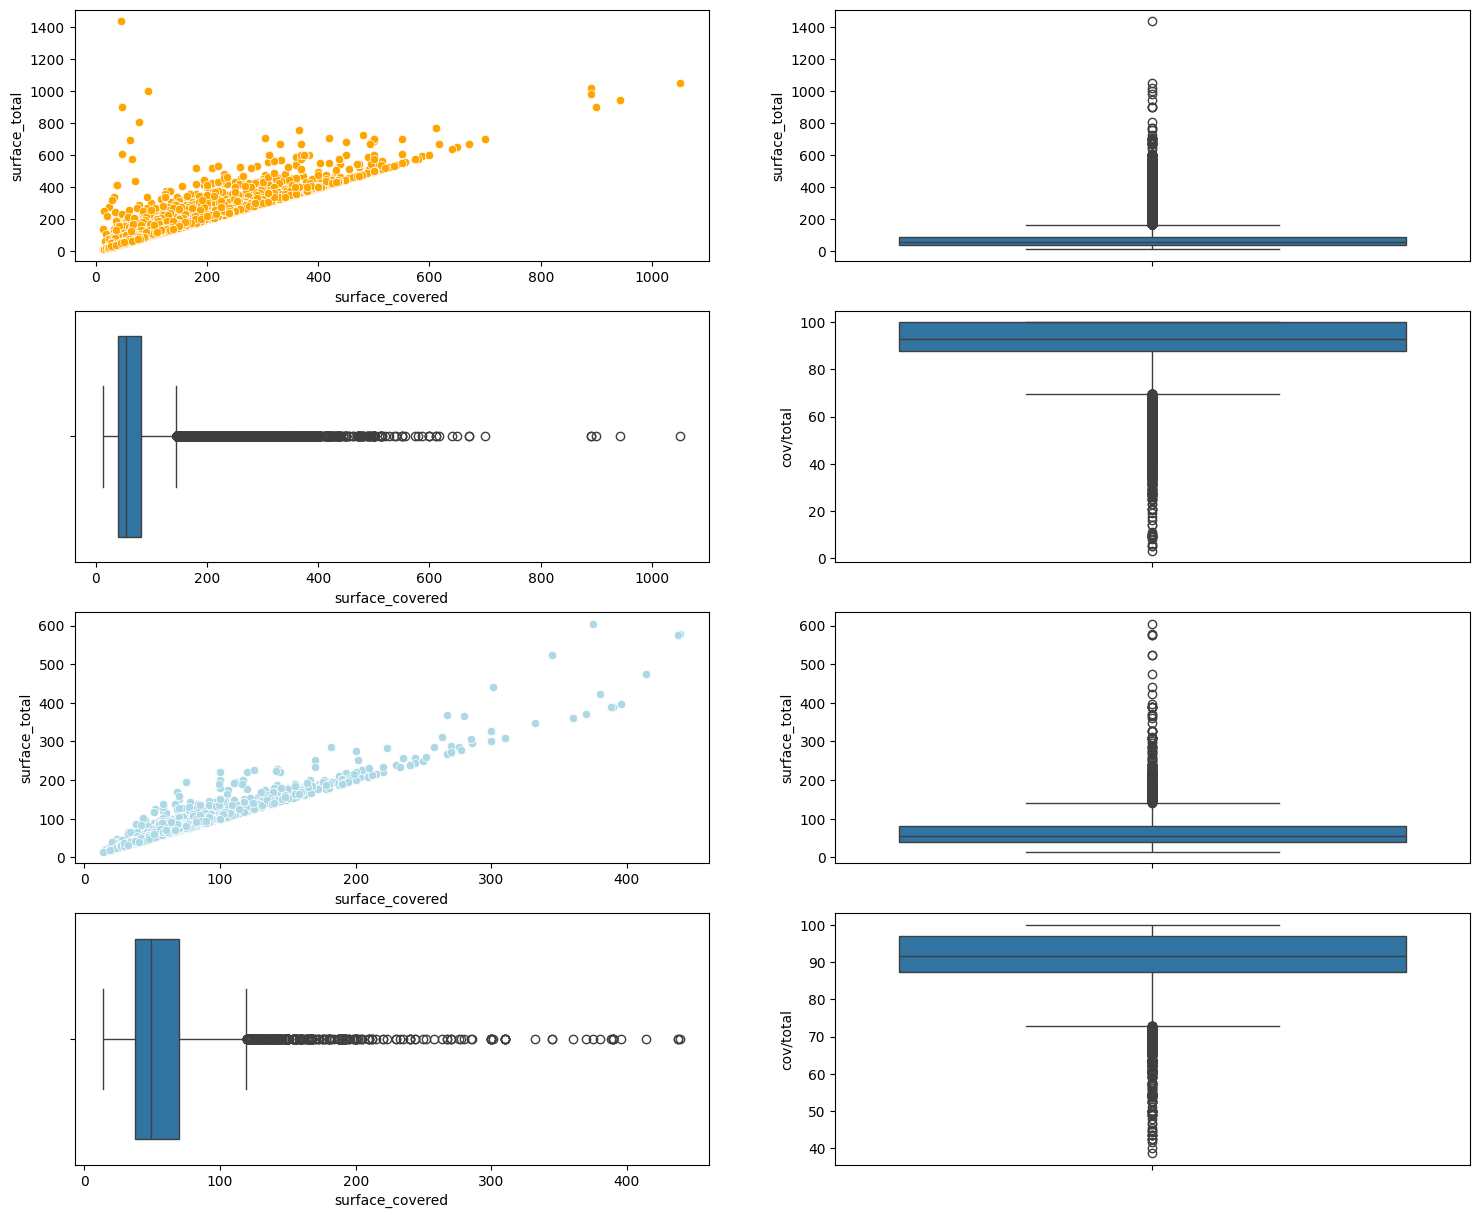

In [98]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_dpto & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_dpto & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_dpto & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_dpto & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ap],ax=axes[3,1])

plt.show()

<Axes: xlabel='surface_covered', ylabel='surface_total'>

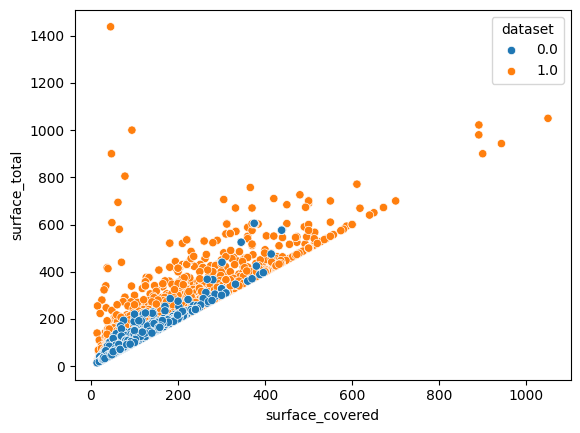

In [99]:
sns.scatterplot(data=df.loc[f_dpto],x="surface_covered",y="surface_total",hue="dataset")


In [100]:
df.loc[f_ent & f_dpto ,["surface_covered","surface_total","cov/total","rooms","bedrooms","bathrooms","title","description"]].sort_values(by="cov/total",ascending=True)

surface_covered  surface_total  cov/total  rooms  bedrooms  bathrooms  \
id                                                                              
521480             45.0         1438.0   3.129346    1.0       1.0        1.0   
497297             47.0          900.0   5.222222    2.0       1.0        1.0   
147225             47.0          900.0   5.222222    2.0       1.0        1.0   
544806             15.0          255.0   5.882353    5.0       4.0        3.0   
427800             48.0          608.0   7.894737    1.0       NaN        2.0   
...                 ...            ...        ...    ...       ...        ...   
198211              NaN            NaN        NaN    2.0       NaN        1.0   
198199              NaN            NaN        NaN    3.0       NaN        1.0   
198192              NaN            NaN        NaN    NaN       NaN        NaN   
463795              NaN            NaN        NaN    1.0       NaN        1.0   
463629              NaN            NaN        NaN    2.0       NaN        1.0   

                                                    title  \
id                                                          
521480                        APTO PROFES. VENTA DE POZO.   
497297         DEPARTAMENTO DOS AMBIENTES EN VILLA DEVOTO   
147225         DEPARTAMENTO DOS AMBIENTES EN VILLA DEVOTO   
544806                  Excelente duplex en Peña y Junin.   
427800     Olazabal   4800 3°  -  - Departamento en Venta   
...                                                   ...   
198211            2 amb c/posibilidad 3 amb- Villa Devoto   
198199      VENTA DEPARTAMENTO DUPLEX 3 AMBIENTES COCHERA   
198192  2 ambientes amplios en Cañitas. Se acepta depa...   
463795                       Departamento - Villa Urquiza   
463629           Departamento en Venta ubicado en Almagro   

                                              description  
id                                                         
521480  Corredor Responsable: Mario Gabriel Gerez - CU...  
497297  Corredor Responsable: Gustavo Guastello - C.U....  
147225  Corredor Responsable: Gustavo Guastello - C.U....  
544806  Lindísimo duplex tipo casa en pleno Barrio Nor...  
427800  EVOQUE OLAZABAL.Es un edificio residencial - p...  
...                                                   ...  
198211  2 amb. c/ posibilidad de  amb<br>-Cocina comed...  
198199  MUY BUEN DEPARTAMENTO TIPO DUPLEX DE 3 AMBIENT...  
198192  CODIGO:  ubicado en: Olleros -  Publicado por:...  
463795  Excelente monoambiente a 1 cuadra de la Estaci...  
463629  Venta - Departamento - Argentina, Buenos Aires...  

[73121 rows x 8 columns]

In [101]:
# OJO ACA QUE PIERDO 1 ap

f=(df["cov/total"]<(df.loc[f_ap & f_dpto ,"cov/total"].min()))
df.loc[f  & f_ent & f_dpto,"surface_total"] = pd.NA
df.loc[f  & f_ent & f_dpto,"surface_covered"] = pd.NA

<Axes: xlabel='surface_covered', ylabel='surface_total'>

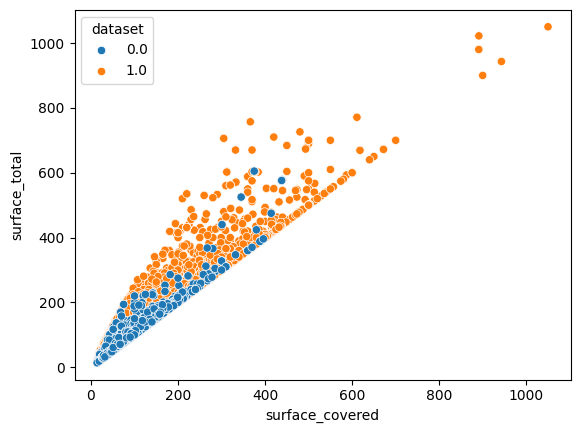

In [102]:
sns.scatterplot(data=df.loc[f_dpto],x="surface_covered",y="surface_total",hue="dataset")

In [103]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

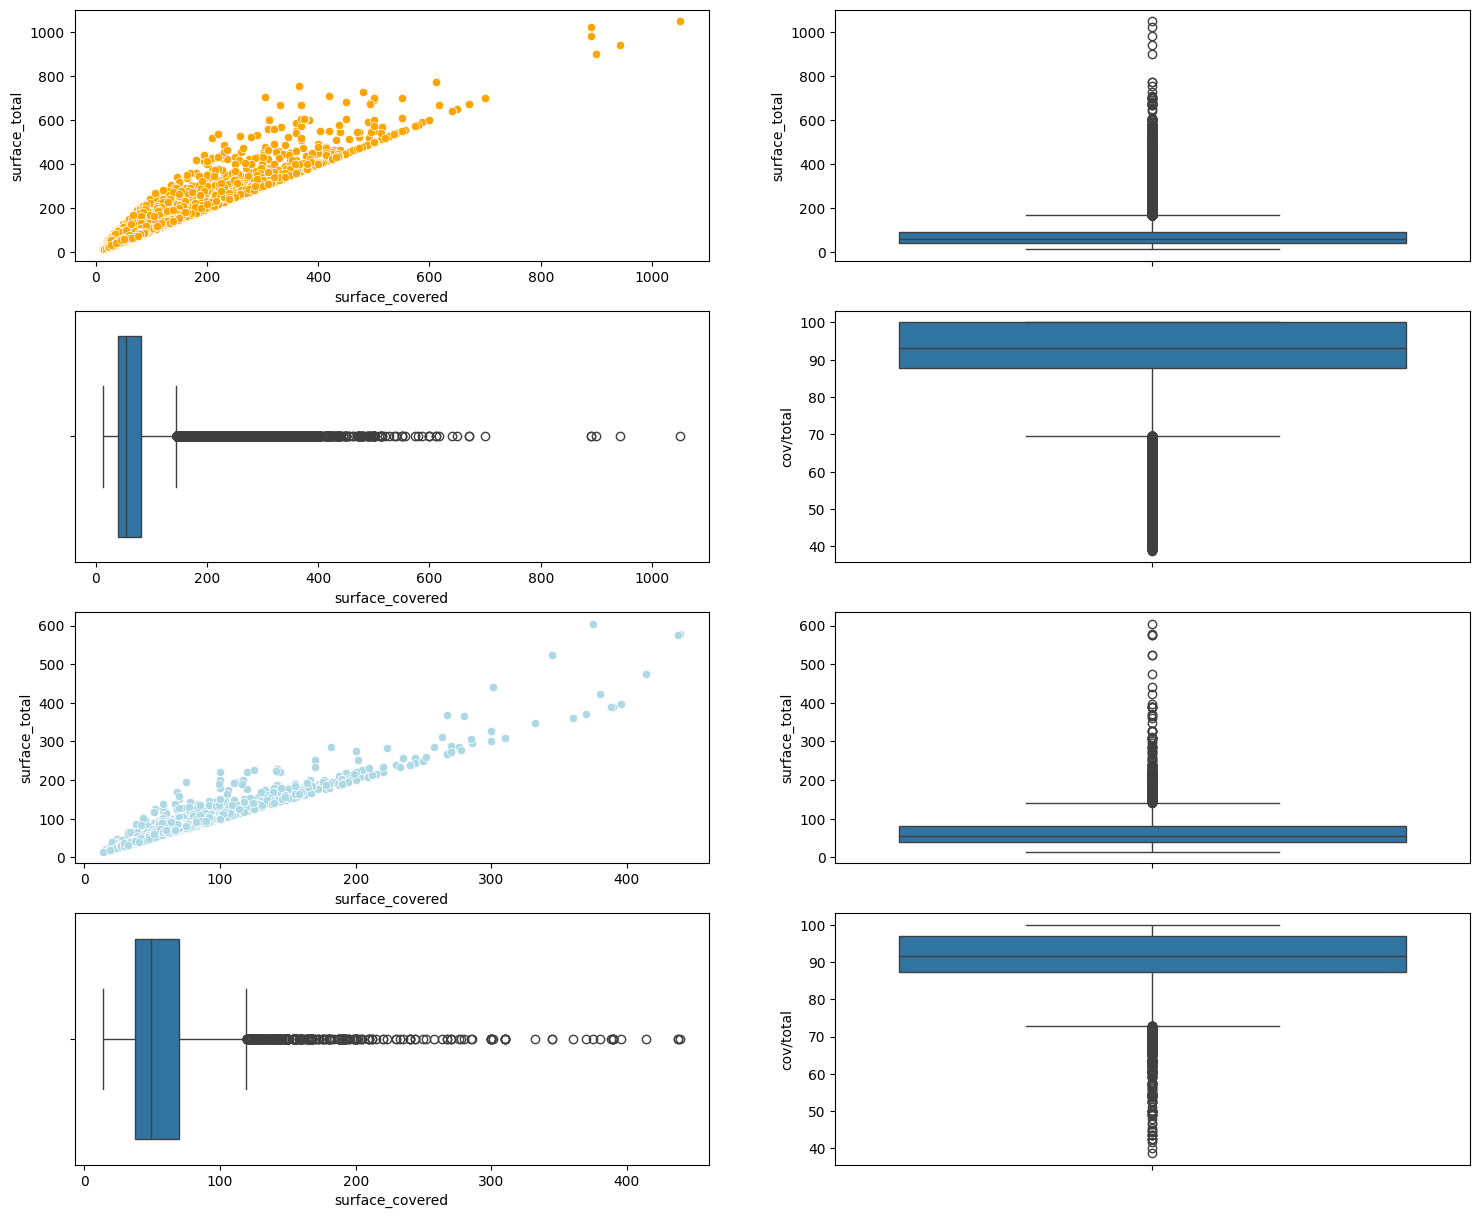

In [104]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_dpto & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_dpto & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_dpto & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_dpto & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_dpto & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_dpto & f_ap],ax=axes[3,1])

plt.show()

----
##### Casa

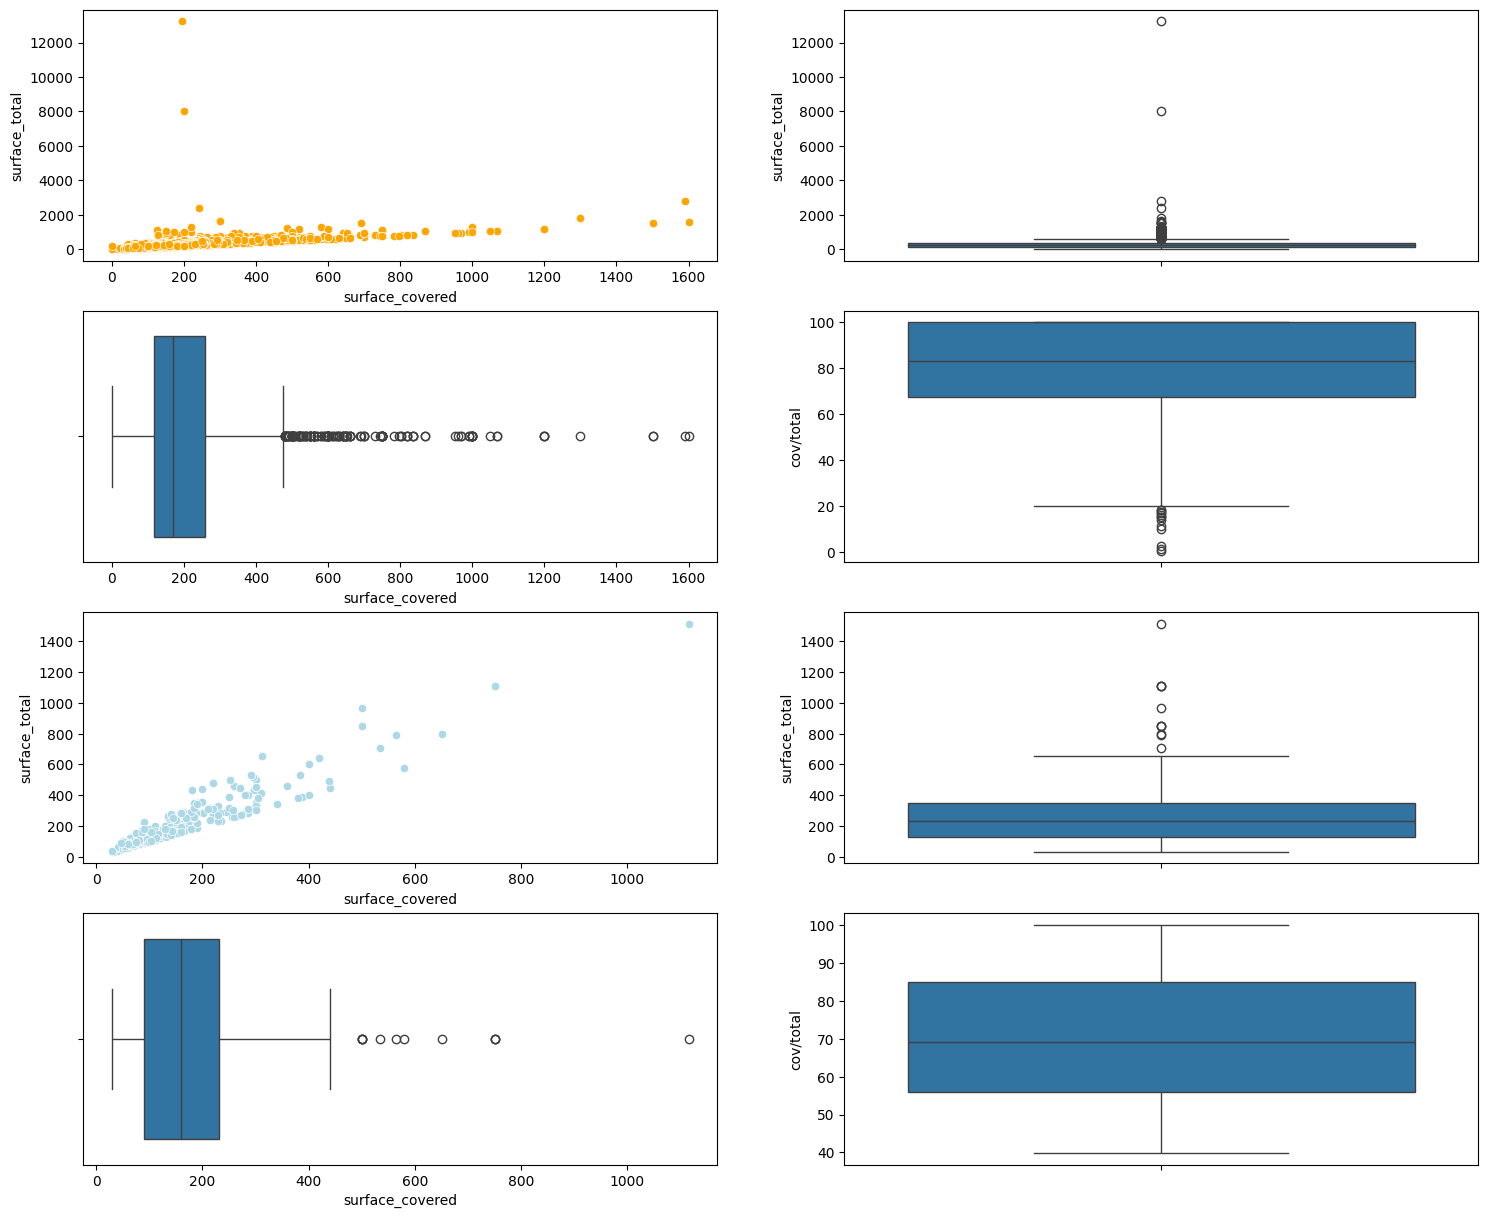

In [105]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_casa & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_casa & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_casa & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_casa & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_casa & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_casa & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_casa & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_casa & f_ap],ax=axes[3,1])

plt.show()

In [106]:
df.loc[f_ap].shape

(7012, 22)

In [107]:
f=df["surface_covered"] ==1
df.loc[f & f_casa & f_ent,"surface_covered"] = pd.NA

f=df["surface_total"] ==1
df.loc[f & f_casa & f_ent,"surface_total"] = pd.NA

In [108]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [109]:
df.loc[f_ap & f_casa,"surface_total"].max()

np.float64(1515.0)

In [110]:
df.loc[f_ap & f_casa,"surface_total"].min()

np.float64(32.0)

In [111]:
df.loc[f_ap & f_casa,"surface_covered"].max()

np.float64(1115.0)

In [112]:
df.loc[f_ap & f_casa,"surface_covered"].min()

np.float64(30.0)

In [113]:
df.loc[f_ap & f_casa,"cov/total"].min()

np.float64(39.823008849557525)

In [114]:
# Tratamientos maximos surface_covered
f=((df["surface_covered"]>1115) & f_ent & f_casa)
df.loc[f,"surface_covered"] = pd.NA

In [115]:
# Tratamiento maximos surface_total
f=((df["surface_total"]>1515) & f_ent & f_casa)
df.loc[f,"surface_total"] = pd.NA

In [116]:
# Tratamiento minimo surface_total
f= ((df["surface_total"]<32) & f_ent & f_casa)
df.loc[f,"surface_total"] = pd.NA

In [117]:
# Tratamientos minimos surface_covered
f=((df["surface_covered"]<30) & f_ent & f_casa)
df.loc[f,"surface_covered"] = pd.NA

In [118]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [119]:
((df["cov/total"] <39.823008849557525 ) & f_ent & f_casa).sum()

np.int64(79)

In [120]:
# Tratamiento min cov/total
f=(df["cov/total"] <39.823008849557525 ) & f_ent & f_casa
df.loc[f,"surface_total"] = pd.NA
df.loc[f,"surface_covered"]=pd.NA

In [121]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

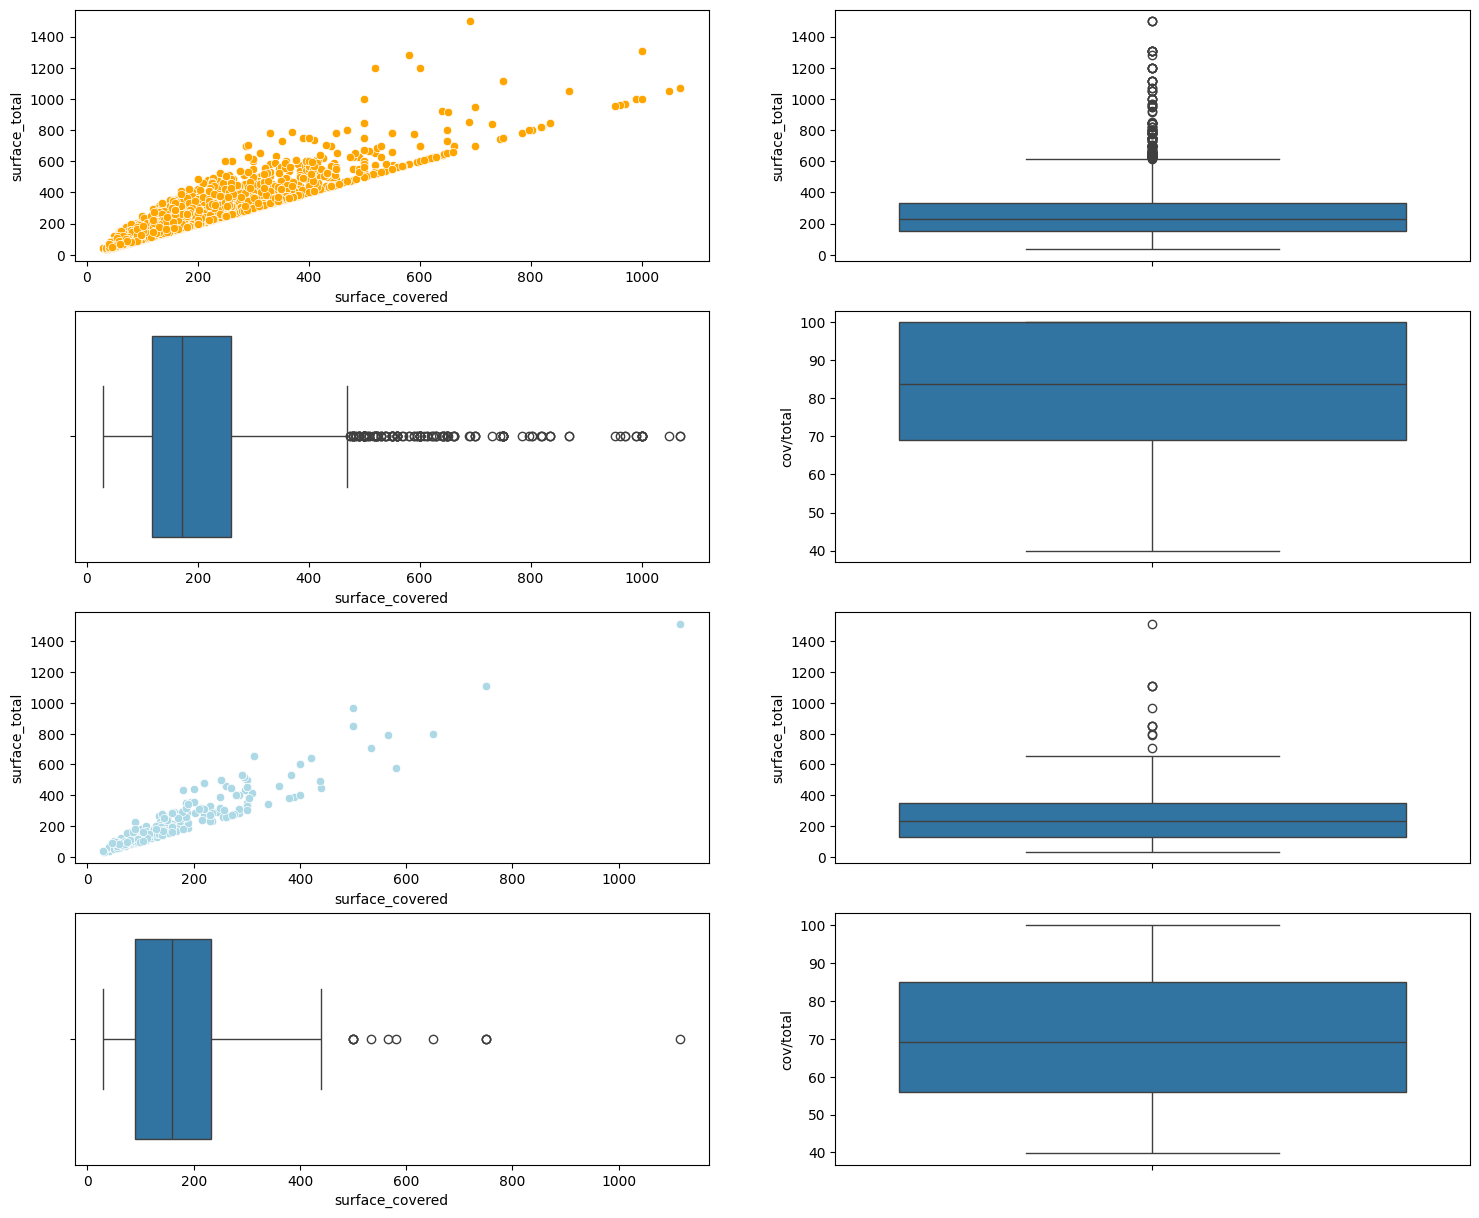

In [122]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_casa & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_casa & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_casa & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_casa & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_casa & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_casa & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_casa & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_casa & f_ap],ax=axes[3,1])

plt.show()

<Axes: xlabel='surface_covered', ylabel='surface_total'>

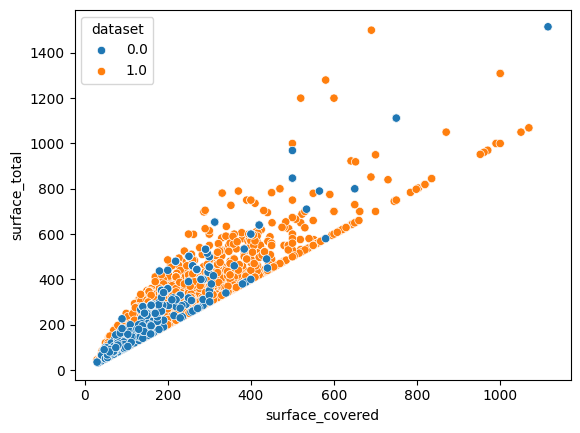

In [123]:
sns.scatterplot(data=df.loc[f_casa],x="surface_covered",y="surface_total",hue="dataset")

----
##### Cochera

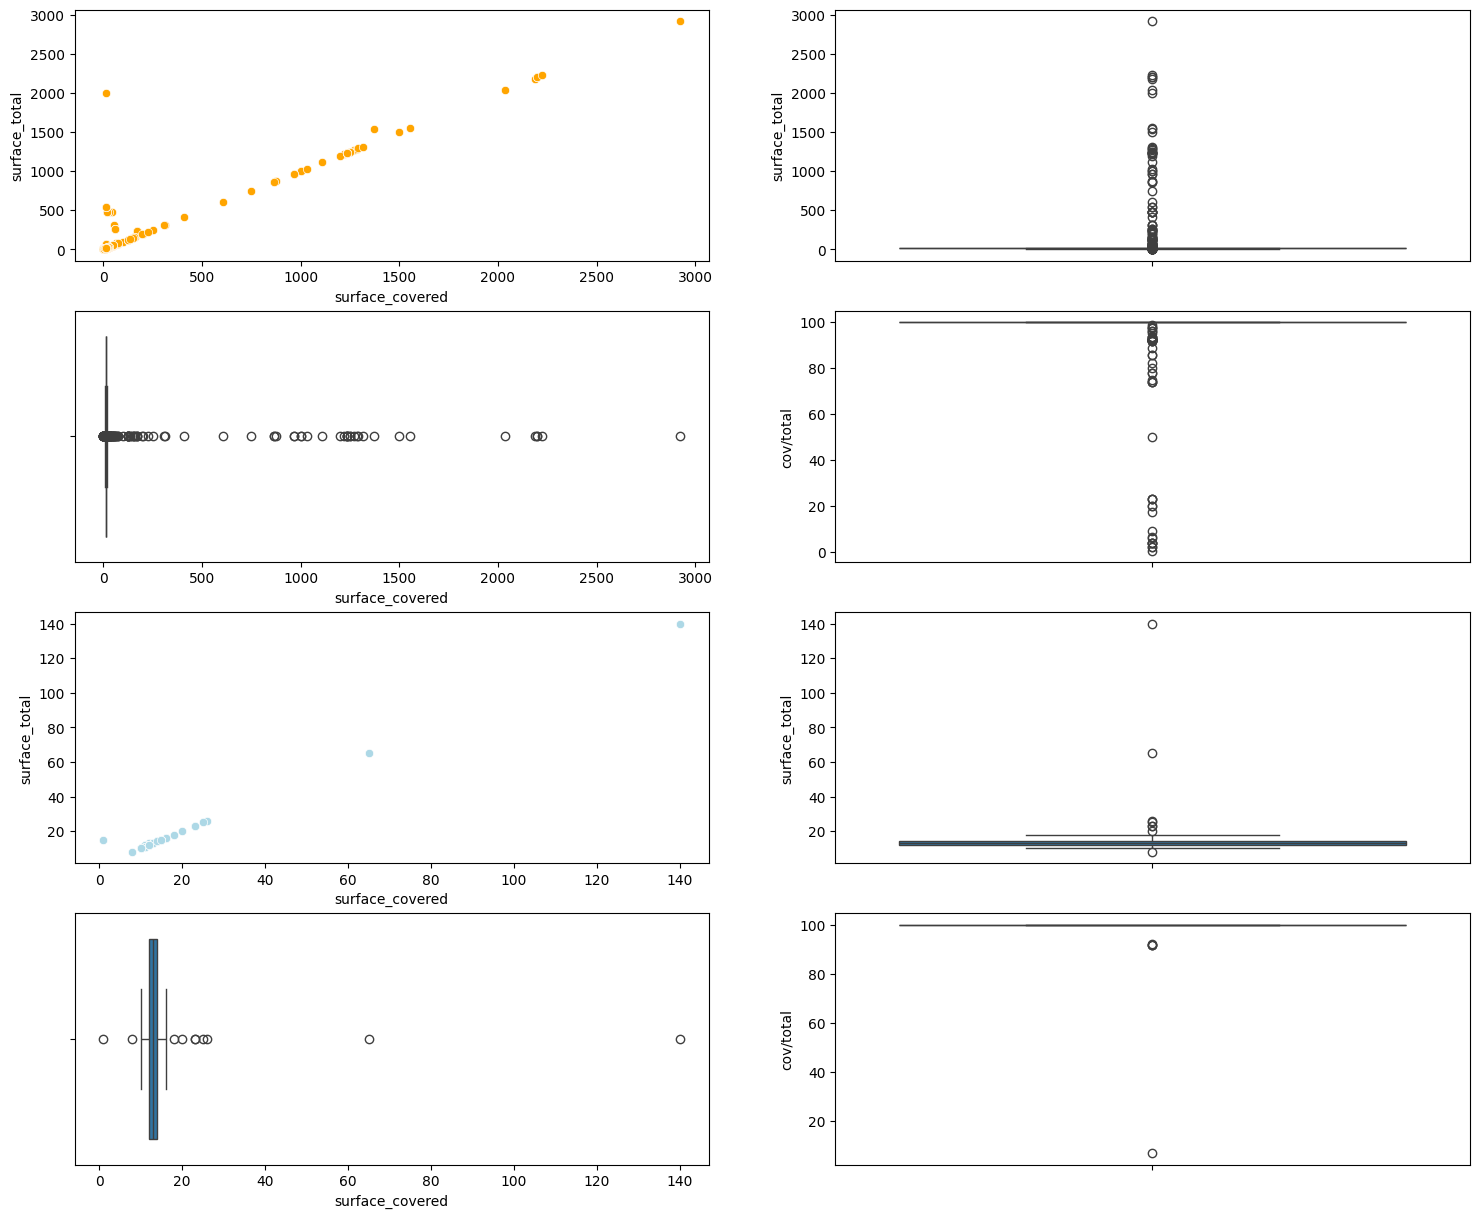

In [124]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_coch & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_coch & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_coch & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_coch & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_coch & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_coch & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_coch & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_coch & f_ap],ax=axes[3,1])

plt.show()

In [125]:
f = df["surface_total"] == 1
df.loc[f & f_ent & f_coch , "surface_total"]= pd.NA

f = df["surface_covered"] == 1

df.loc[f & f_ent & f_coch , "surface_covered"]= pd.NA

In [126]:
min_total=df.loc[f_ap & f_coch , "surface_total"].min()
max_total = df.loc[f_ap & f_coch,"surface_total"].max()
min_cov=df.loc[f_ap & f_coch , "surface_covered"].min()
max_cov = df.loc[f_ap & f_coch,"surface_covered"].max()

In [127]:
df.shape

(87624, 22)

In [128]:
f_total_out = ((df["surface_total"] < min_total) & (f_ent) & (f_coch)) |  ((df["surface_total"] > max_total) & (f_ent) & (f_coch))
f_cov_out= ((df["surface_covered"] < min_cov) & (f_ent) & (f_coch)) |  ((df["surface_covered"] > max_cov) & (f_ent) & (f_coch))
df=df.loc[~(f_total_out|f_cov_out)]
df.shape


(87543, 22)

In [129]:
df.loc[f_ap].shape

(7012, 22)

In [130]:
df["cov/total"] = (df["surface_covered"] / df["surface_total"])*100
df["total/cov"] = df["surface_total"] / df["surface_covered"]

In [131]:
df.loc[f_ent & f_coch,["surface_covered","surface_total","cov/total"]].sort_values(by="cov/total")

surface_covered  surface_total  cov/total
id                                               
15172              14.0          70.00  20.000000
15171              14.0          70.00  20.000000
822744             12.0          24.00  50.000000
522793              9.0          12.00  75.000000
865149             16.0          20.51  78.010726
...                 ...            ...        ...
197819              NaN            NaN        NaN
197817              NaN            NaN        NaN
463418              NaN            NaN        NaN
463417              NaN            NaN        NaN
463412              NaN            NaN        NaN

[2554 rows x 3 columns]

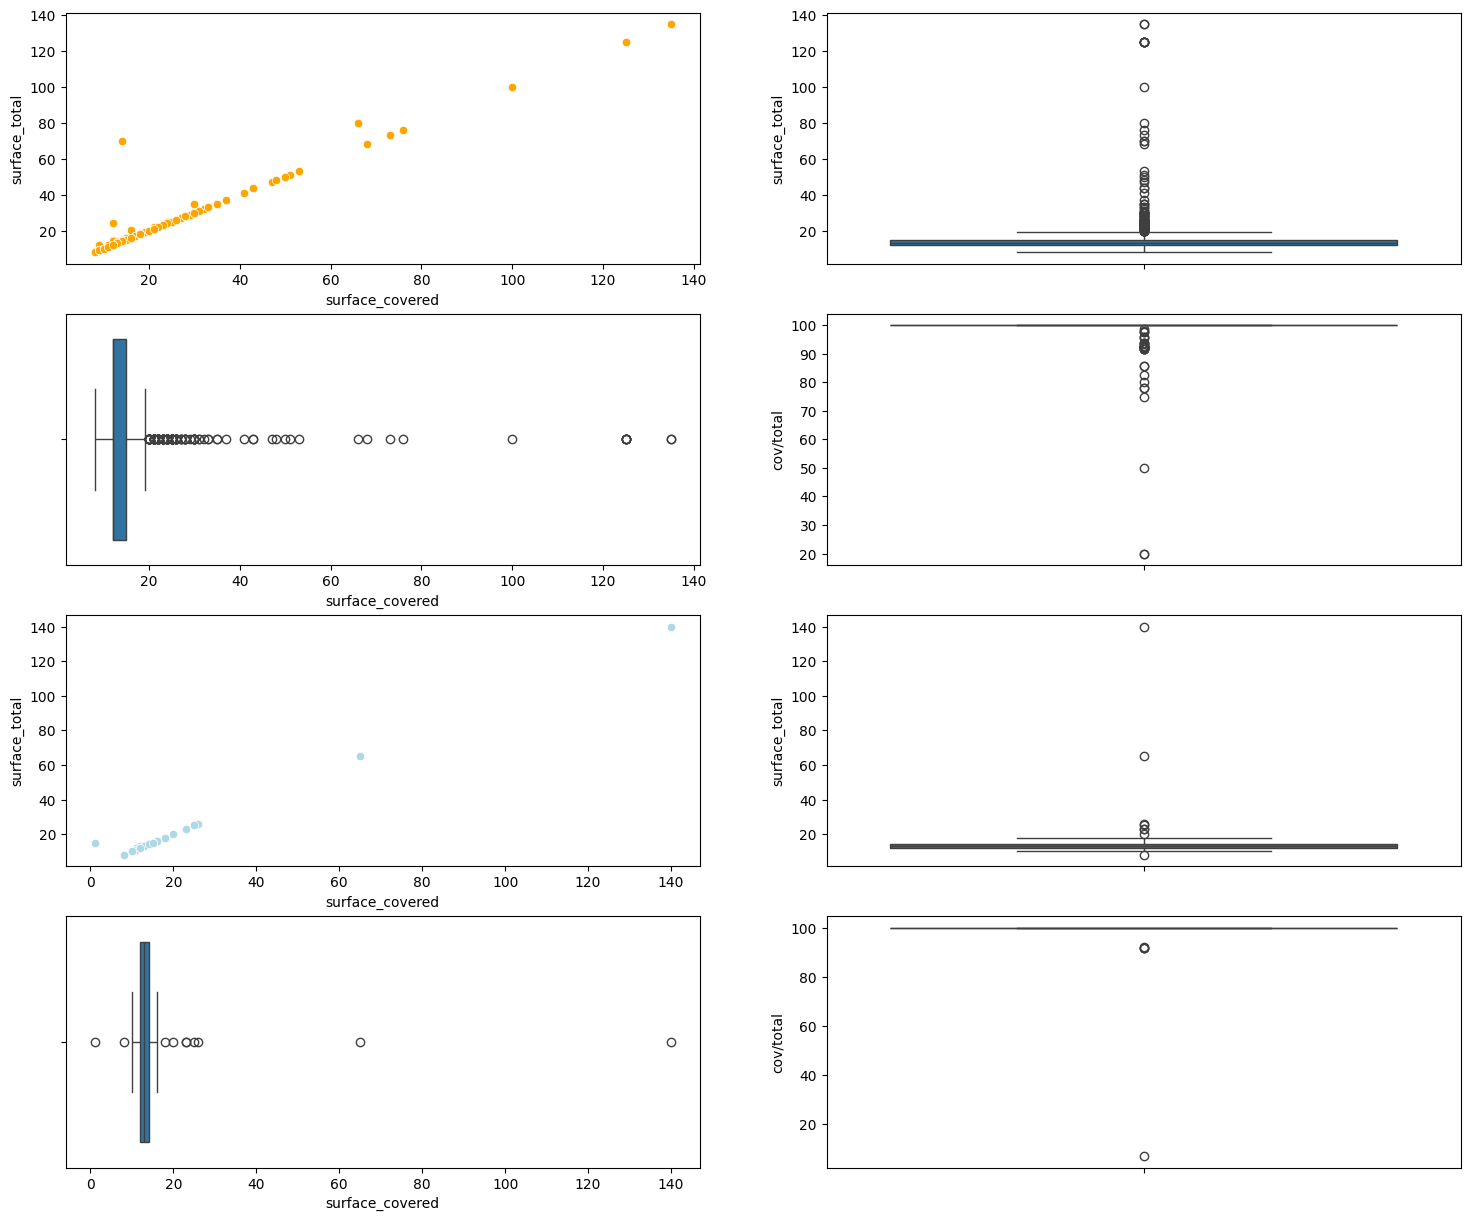

In [132]:
fig , axes = plt.subplots(4,2,figsize=(18,15))
sns.scatterplot(data=df.loc[f_coch & f_ent],x="surface_covered",y="surface_total",color="orange",ax=axes[0,0])
sns.boxplot(data=df.loc[f_coch & f_ent,"surface_total"],ax=axes[0,1])
sns.boxplot(x="surface_covered",data=df.loc[f_coch & f_ent],ax=axes[1,0])
sns.boxplot(y="cov/total",data=df.loc[f_coch & f_ent],ax=axes[1,1])
sns.scatterplot(data=df.loc[f_coch & f_ap],x="surface_covered",y="surface_total",color="lightblue",ax=axes[2,0])
sns.boxplot(data=df.loc[f_coch & f_ap,"surface_total"],ax=axes[2,1])
sns.boxplot(x="surface_covered",data=df.loc[f_coch & f_ap],ax=axes[3,0])
sns.boxplot(y="cov/total",data=df.loc[f_coch & f_ap],ax=axes[3,1])

plt.show()

##### Resumen dptos - casas - cocheras

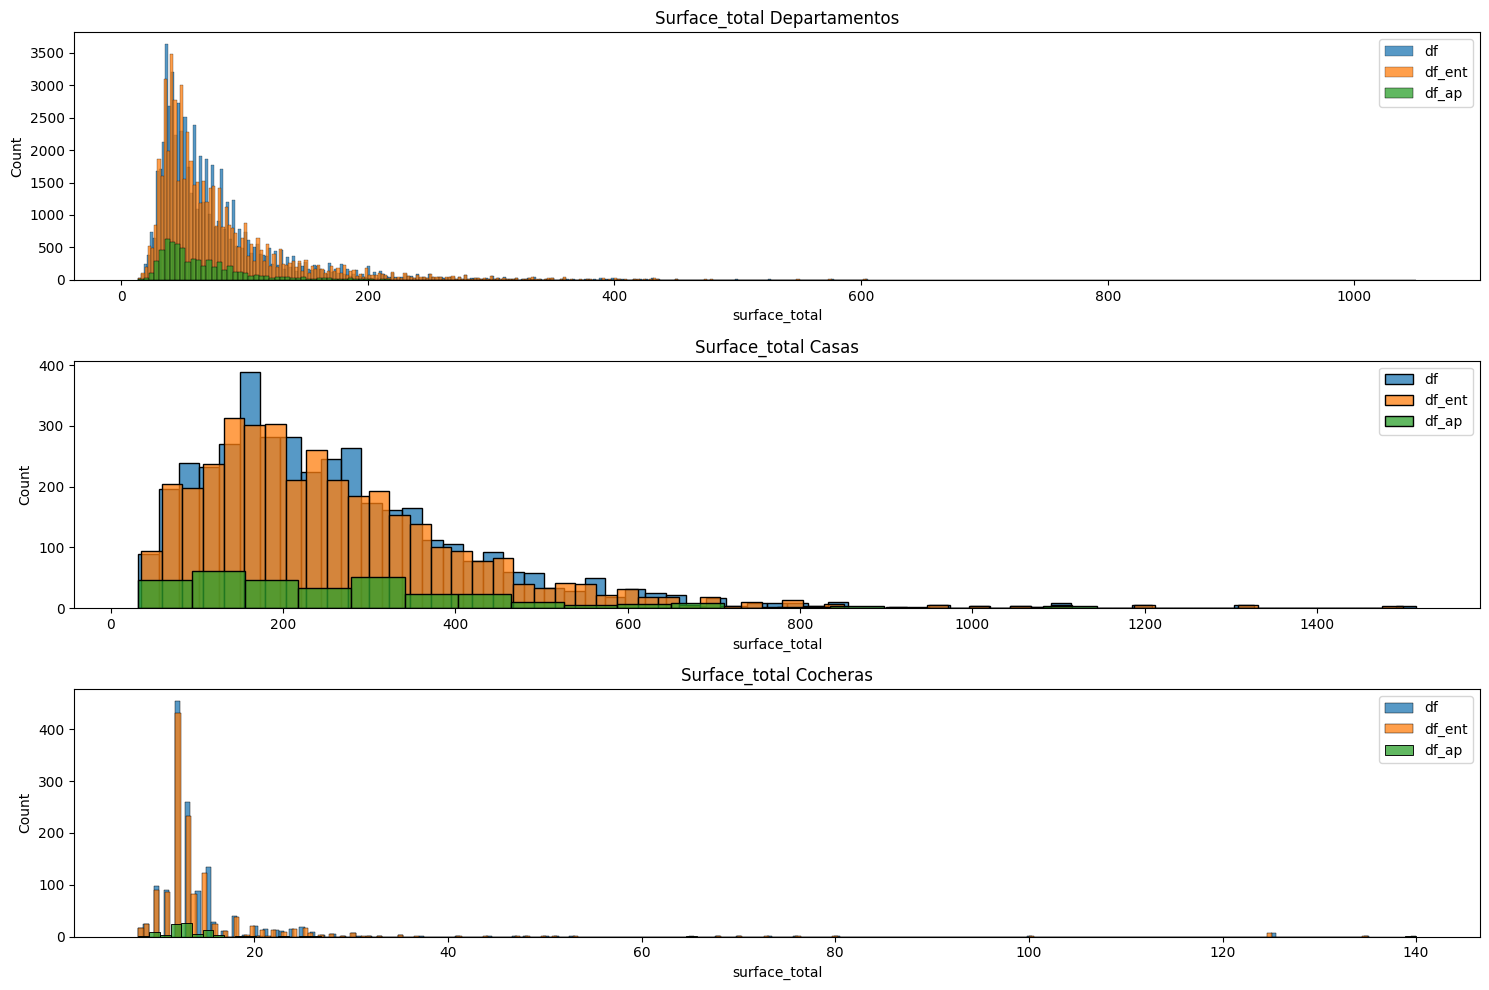

In [133]:
fig,axes = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df.loc[f_dpto,"surface_total"],ax=axes[0], label="df")
sns.histplot(data=df.loc[f_dpto&f_ent,"surface_total"],ax=axes[0], label="df_ent")
sns.histplot(data=df.loc[f_dpto&f_ap,"surface_total"],ax=axes[0],label="df_ap")
axes[0].set_title("Surface_total Departamentos")
axes[0].legend()

sns.histplot(data=df.loc[f_casa,"surface_total"],ax=axes[1], label="df")
sns.histplot(data=df.loc[f_casa&f_ent,"surface_total"],ax=axes[1], label="df_ent")
sns.histplot(data=df.loc[f_casa&f_ap,"surface_total"],ax=axes[1],label="df_ap")
axes[1].set_title("Surface_total Casas")
axes[1].legend()


sns.histplot(data=df.loc[f_coch,"surface_total"],ax=axes[2], label="df")
sns.histplot(data=df.loc[f_coch&f_ent,"surface_total"],ax=axes[2], label="df_ent")
sns.histplot(data=df.loc[f_coch&f_ap,"surface_total"],ax=axes[2],label="df_ap")
axes[2].set_title("Surface_total Cocheras")
axes[2].legend()


plt.tight_layout()
plt.show()

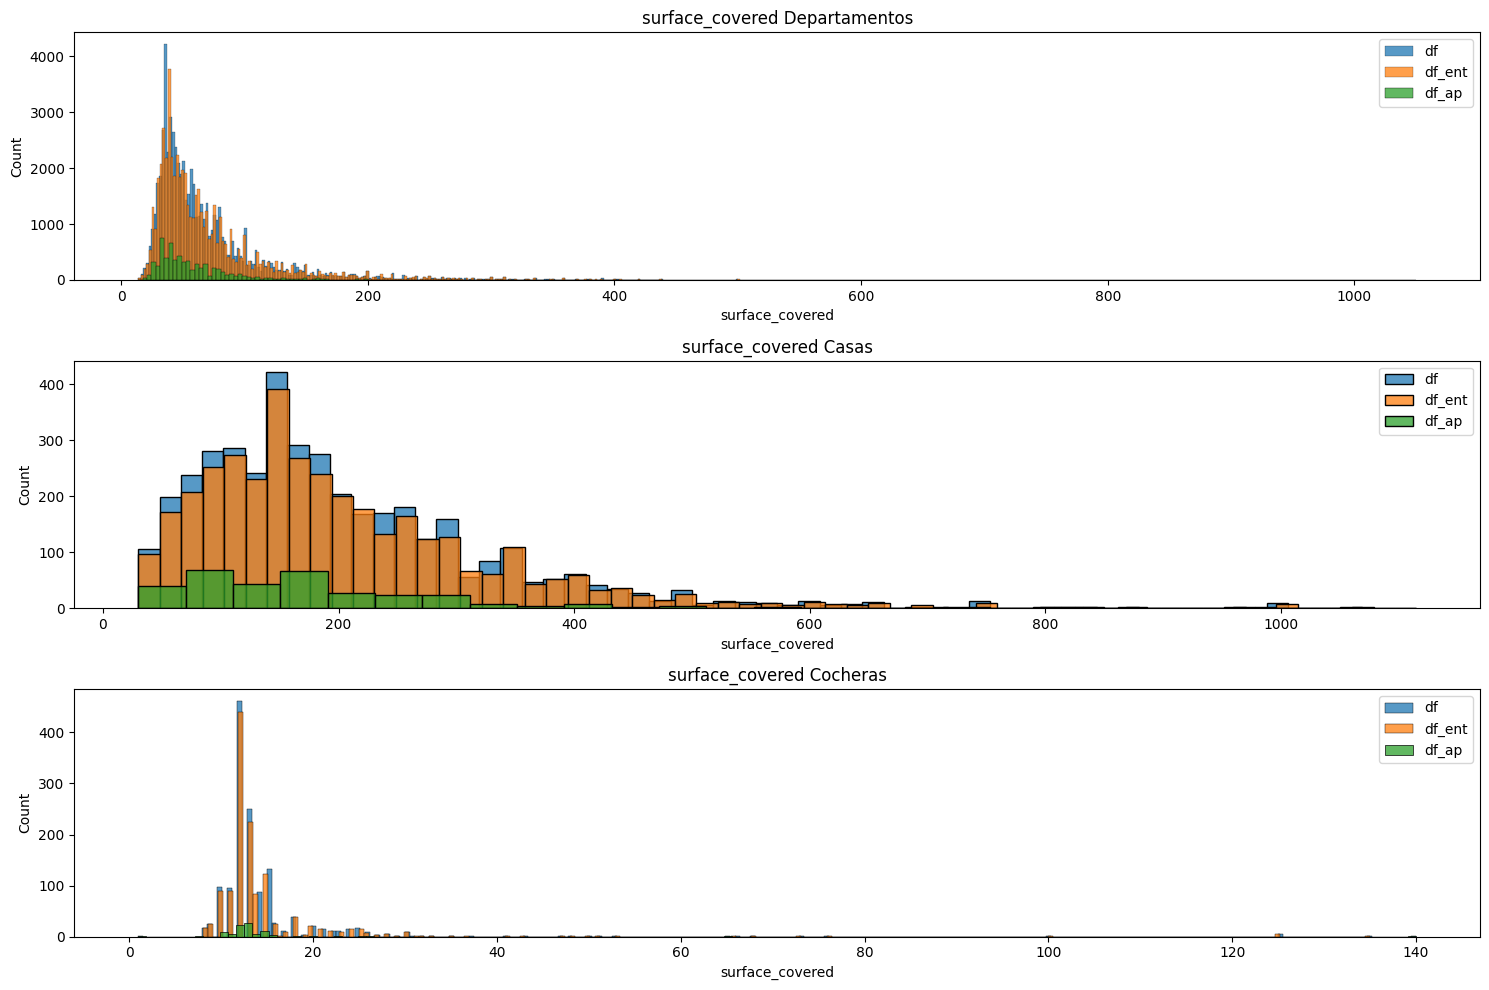

In [134]:
fig,axes = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df.loc[f_dpto,"surface_covered"],ax=axes[0] , label="df")
sns.histplot(data=df.loc[f_dpto&f_ent,"surface_covered"],ax=axes[0], label="df_ent")
sns.histplot(data=df.loc[f_dpto&f_ap,"surface_covered"],ax=axes[0],label="df_ap")
axes[0].set_title("surface_covered Departamentos")
axes[0].legend()

sns.histplot(data=df.loc[f_casa,"surface_covered"],ax=axes[1], label="df")
sns.histplot(data=df.loc[f_casa&f_ent,"surface_covered"],ax=axes[1], label="df_ent")
sns.histplot(data=df.loc[f_casa&f_ap,"surface_covered"],ax=axes[1],label="df_ap")
axes[1].set_title("surface_covered Casas")
axes[1].legend()

sns.histplot(data=df.loc[f_coch,"surface_covered"],ax=axes[2], label="df")
sns.histplot(data=df.loc[f_coch&f_ent,"surface_covered"],ax=axes[2], label="df_ent")
sns.histplot(data=df.loc[f_coch&f_ap,"surface_covered"],ax=axes[2],label="df_ap")
axes[2].set_title("surface_covered Cocheras")
axes[2].legend()

plt.tight_layout()

## Retomar desde aca

In [135]:
df.loc[f_ent].shape

(80531, 22)

In [136]:
df.loc[f_ap].shape

(7012, 22)

In [137]:
df.loc[f_ent].info()

<class 'pandas.core.frame.DataFrame'>
Index: 80531 entries, 143984 to 464556
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       80531 non-null  datetime64[ns]
 1   end_date         80531 non-null  object        
 2   lat              80531 non-null  float64       
 3   lon              80531 non-null  float64       
 4   l3               80531 non-null  object        
 5   l4               80531 non-null  object        
 6   rooms            73162 non-null  float64       
 7   bedrooms         52860 non-null  float64       
 8   bathrooms        73520 non-null  float64       
 9   surface_total    62512 non-null  float64       
 10  surface_covered  62482 non-null  float64       
 11  currency         80531 non-null  object        
 12  price_period     33114 non-null  object        
 13  title            80521 non-null  object        
 14  description      80531 non-null  obje

In [138]:
df.loc[f_ap].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7012 entries, 1068 to 960229
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       7012 non-null   datetime64[ns]
 1   end_date         7012 non-null   object        
 2   lat              7008 non-null   float64       
 3   lon              7008 non-null   float64       
 4   l3               7008 non-null   object        
 5   l4               7008 non-null   object        
 6   rooms            6518 non-null   float64       
 7   bedrooms         4678 non-null   float64       
 8   bathrooms        6803 non-null   float64       
 9   surface_total    7012 non-null   float64       
 10  surface_covered  7012 non-null   float64       
 11  currency         7012 non-null   object        
 12  price_period     0 non-null      object        
 13  title            7012 non-null   object        
 14  description      7012 non-null   object 

In [139]:
df.loc[f_ent,"property_type"].value_counts()

property_type
Departamento    73121
Casa             4856
Cochera          2554
Name: count, dtype: int64

In [140]:
df.loc[f_ap,"property_type"].value_counts()

property_type
Departamento    6594
Casa             327
Cochera           91
Name: count, dtype: int64

In [141]:
df.loc[f_ent,"property_type"].value_counts(normalize=True)

property_type
Departamento    0.907986
Casa            0.060300
Cochera         0.031714
Name: proportion, dtype: float64

In [142]:
df.loc[f_ap,"property_type"].value_counts(normalize=True)

property_type
Departamento    0.940388
Casa            0.046634
Cochera         0.012978
Name: proportion, dtype: float64

### 2.3.0- "Rooms" - GENERAL

Vamos a extraer los rooms de title y de description

Vamos a tener distintos casos :
1. Todas NaN

2. Solo 1 tiene valor (2 NaN)

3. Dos con valor (1 NaN)
- Iguales entre sí

- Distintas entre sí

4. Las 3 con valor
- Las 3 son iguales

- Solo 2 son iguales

- Las 3 son distintas

Siempre tendra prioridad en la confiabilidad la que tenga mayor numeros de votacion. En caso de paridad, se decide por el siguiente orden de confianza:

rooms_title - rooms - rooms_description

In [143]:
rooms = {k:f"{k} amb" for k in range(1,int(df["rooms"].max()+1))}
for k,v in rooms.items():
  if k == 1 :
    f1=(df["title"].str.lower().str.contains(v,na=False)) | (df["title"].str.lower().str.contains("monoamb",na=False))
    df.loc[f1,"rooms_title"]=k
  else:
    fi=df["title"].str.lower().str.contains(v,na=False)
    df.loc[fi,"rooms_title"]=k


In [144]:
rooms = {k:f"{k} amb" for k in range(1,int(df["rooms"].max()+1))}
for k,v in rooms.items():
  if k == 1 :
    f1=(df["description"].str.lower().str.contains(v)) | (df["description"].str.lower().str.contains("monoamb"))
    df.loc[f1,"rooms_description"]=k
  else:
    fi=df["description"].str.lower().str.contains(v,na=False)
    df.loc[fi,"rooms_description"]=k

In [145]:
def categorize_rooms(row):
  vals=[row["rooms"] , row["rooms_title"],row["rooms_description"]]
  not_nulls = [v for v in vals if pd.notna(v)]

  if len(not_nulls)==0:
    return "Todas NaN"
  elif len(not_nulls)==1:
    return "Solo 1 valor"
  elif len(not_nulls)==2:
    if not_nulls[0]==not_nulls[1]:
      return "2 iguales, 1 NaN"
    else:
      return "2 distintos, 1 NaN"
  else:
    vals_unique=set(not_nulls)
    if len(vals_unique)==1:
      return "3 iguales"
    elif  len(vals_unique)==2:
      return "2 iguales, 1 distinto"
    else:
      return "3 distintos"

In [146]:
df["categorize_rooms"]=df.apply(categorize_rooms,axis=1)

In [147]:
df["categorize_rooms"].value_counts()

categorize_rooms
2 iguales, 1 NaN         29577
3 iguales                27766
Solo 1 valor             17393
2 distintos, 1 NaN        6080
Todas NaN                 3484
2 iguales, 1 distinto     3173
3 distintos                 70
Name: count, dtype: int64

In [148]:
def rooms_def(row):
  vals=[row["rooms"] , row["rooms_title"],row["rooms_description"]]
  not_nulls = [v for v in vals if pd.notna(v)]
  if ((row["categorize_rooms"] == "3 iguales") | (row["categorize_rooms"] == "3 distintos")) :
    return row["rooms_title"]
  elif (row["categorize_rooms"] == "2 iguales, 1 distinto")|(row["categorize_rooms"] == "2 iguales, 1 NaN"):
    if row["rooms"]==row["rooms_description"]:
      return row["rooms"]
    else:
      return row["rooms_title"]
  elif (row["categorize_rooms"] == "2 distintos, 1 NaN"):
    if pd.isna(row["rooms_title"]):
      return row["rooms"]
    else:
      return row["rooms_title"]
  elif (row["categorize_rooms"] == "Solo 1 valor"):
    return not_nulls[0]
  else:
    return pd.NA


In [149]:
df["rooms_def"]=df.apply(rooms_def,axis=1)

In [150]:
((df["rooms_def"].isna())&f_ent).sum()

np.int64(3296)

### 2.3- "Rooms" --      Departamentos

In [151]:
f_dpto=df["property_type"]=="Departamento"

<Axes: xlabel='rooms_def', ylabel='Count'>

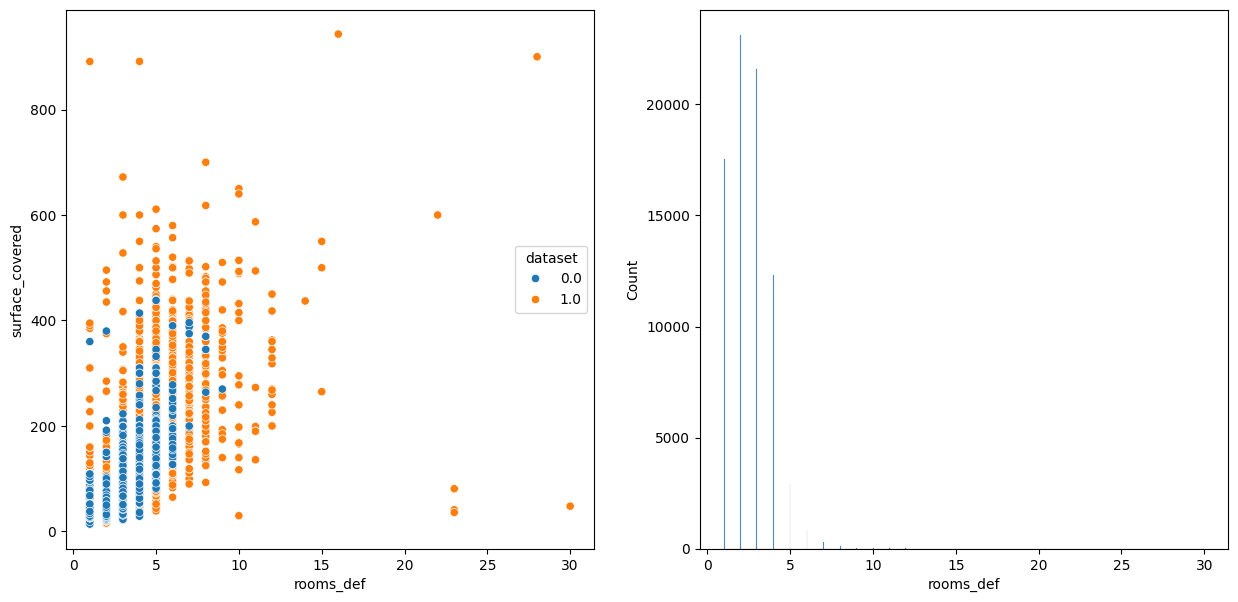

In [152]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(data=df.loc[f_dpto],y="surface_covered",x="rooms_def",hue='dataset',ax=axes[0])
sns.histplot(data=df.loc[f_dpto,"rooms_def"],ax=axes[1])

In [153]:
(df.loc[f_dpto,"rooms_def"] > 9).sum()

np.int64(67)

In [154]:
df.shape[0]

87543

In [155]:
df.shape[0]-67

87476

In [156]:
f=(df.loc[f_dpto,"rooms_def"]>9)&f_dpto
df = df.loc[~f]
df.shape

(87476, 26)

<Axes: xlabel='rooms_def', ylabel='Count'>

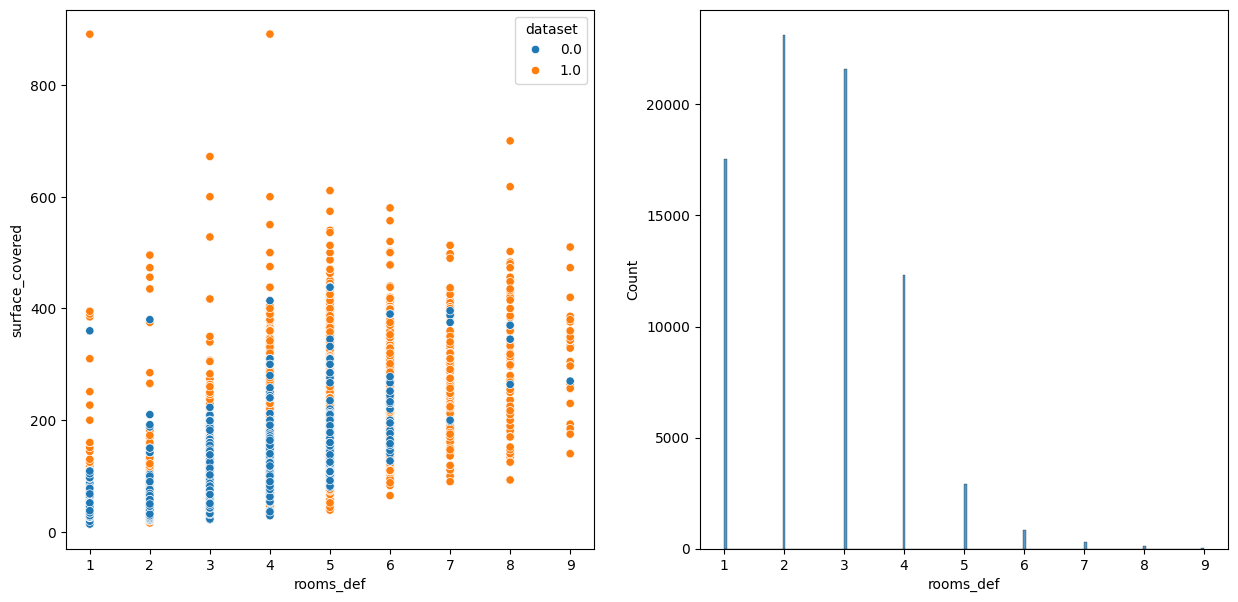

In [157]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(data=df.loc[f_dpto],y="surface_covered",x="rooms_def",hue='dataset',ax=axes[0])
sns.histplot(data=df.loc[f_dpto,"rooms_def"],ax=axes[1])

<Axes: xlabel='rooms_title', ylabel='surface_covered'>

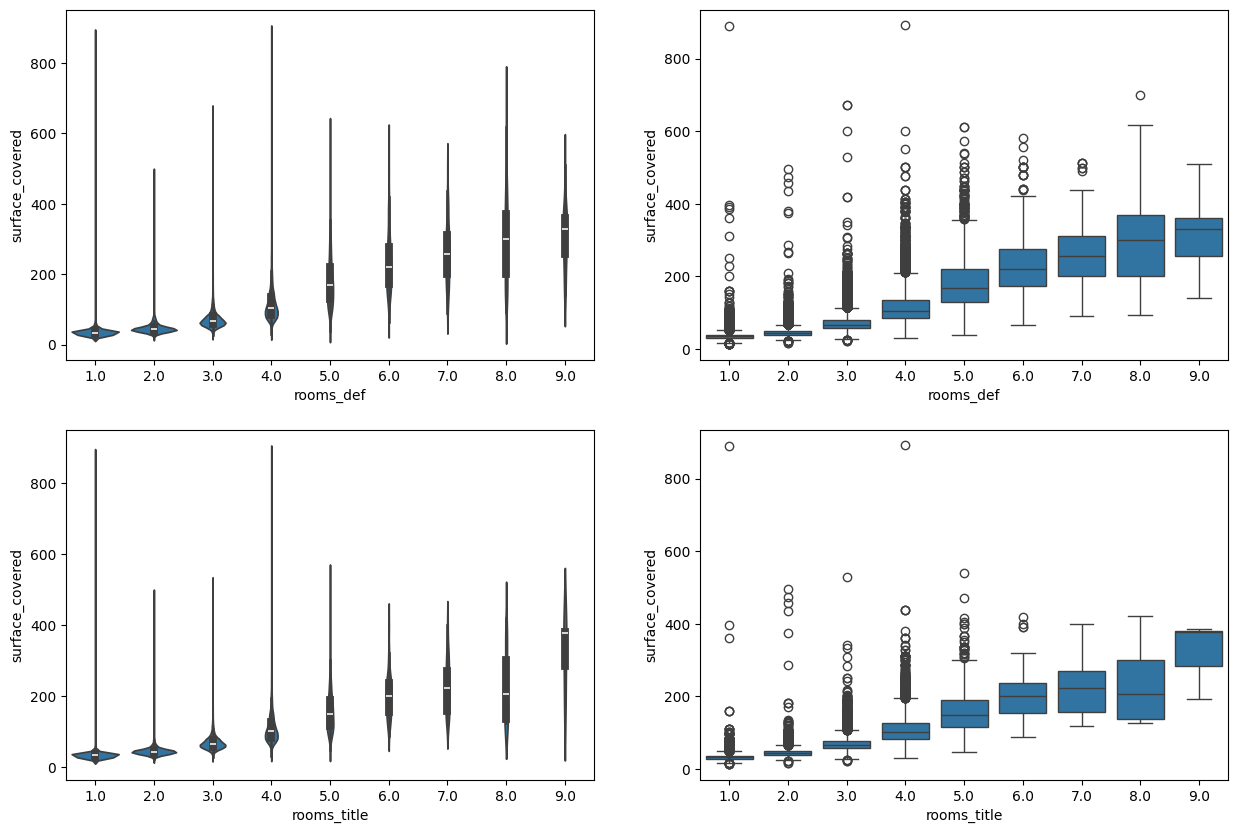

In [158]:
f_dpto=(df["property_type"]=="Departamento")
f=(df["rooms_def"].notna())
fig,axes=plt.subplots(2,2,figsize=(15,10))
sns.violinplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_covered",ax=axes[0,0])
sns.boxplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_covered",ax=axes[0,1])
sns.violinplot(data=df.loc[f_dpto&f],x="rooms_title",y="surface_covered",ax=axes[1,0])
sns.boxplot(data=df.loc[f_dpto&f],x="rooms_title",y="surface_covered",ax=axes[1,1])


### 2.3- "Bathrooms"  - Departamentos

In [159]:
f=(df["bathrooms"] >9)
df.loc[f & f_dpto,"bathrooms"] = pd.NA

In [160]:
df["ph"] = ((df["title"].str.lower().str.contains("ph"))|(df["description"].str.lower().str.contains("ph"))).astype(int)
df["penthouse"] = ((df["title"].str.lower().str.contains("penthouse"))|(df["description"].str.lower().str.contains("penthouse"))).astype(int)
df["semipiso"]=((df["title"].str.lower().str.contains("semipiso"))|(df["description"].str.lower().str.contains("semipiso"))).astype(int)
df["duplex"]=((df["title"].str.lower().str.contains("duplex"))|(df["description"].str.lower().str.contains("duplex"))  |(df["title"].str.lower().str.contains("dúplex"))| (df["description"].str.lower().str.contains("dúplex"))).astype(int)
df["triplex"]=((df["title"].str.lower().str.contains("triplex"))|(df["description"].str.lower().str.contains("triplex"))  |(df["title"].str.lower().str.contains("tríplex"))| (df["description"].str.lower().str.contains("tríplex"))).astype(int)
df["loft"]=((df["title"].str.lower().str.contains("loft"))|(df["description"].str.lower().str.contains("loft"))).astype(int)

In [161]:
def cat_cheta_dpto(row):
  if row["ph"] ==1:
    return 1
  elif row["semipiso"]==1:
    return 1
  elif row["duplex"]==1:
    return 1
  elif row["triplex"]:
    return 1
  elif row["loft"]:
    return 1
  else:
    return 0

In [162]:
df["cat_cheta_dpto"]=df.apply(cat_cheta_dpto,axis=1)

<Axes: xlabel='bathrooms', ylabel='Count'>

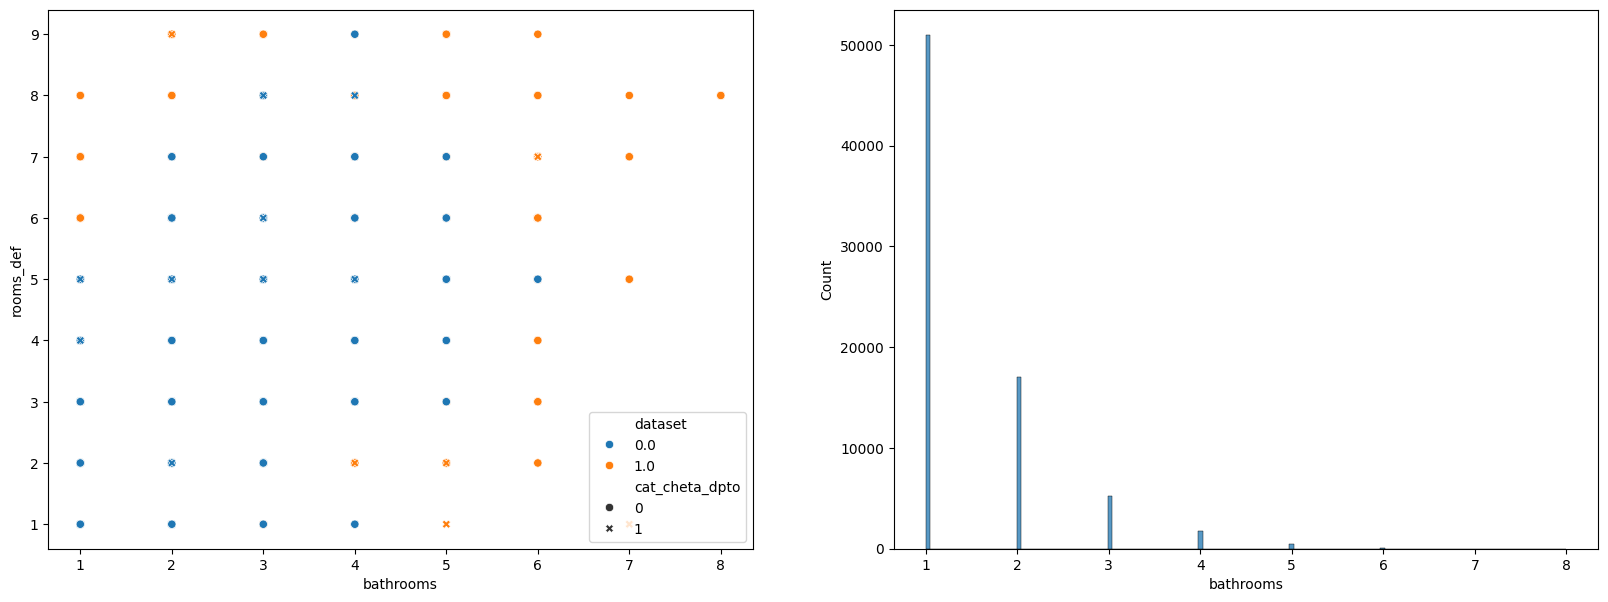

In [163]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_dpto],y="rooms_def",x="bathrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_dpto,"bathrooms"],ax=axes[1])

In [164]:
f=(df["bathrooms"] >3)& (df["rooms_def"] ==1)& (df["cat_cheta_dpto"] ==0)
df.loc[f_dpto & f,"bathrooms"]=pd.NA

In [165]:
f=(df["bathrooms"] >4)& (df["rooms_def"] ==2)& (df["cat_cheta_dpto"] ==0)
df.loc[f_dpto & f,"bathrooms"]=pd.NA

### 2.3- "Bedrooms"  - Departamentos

<Axes: xlabel='bedrooms', ylabel='Count'>

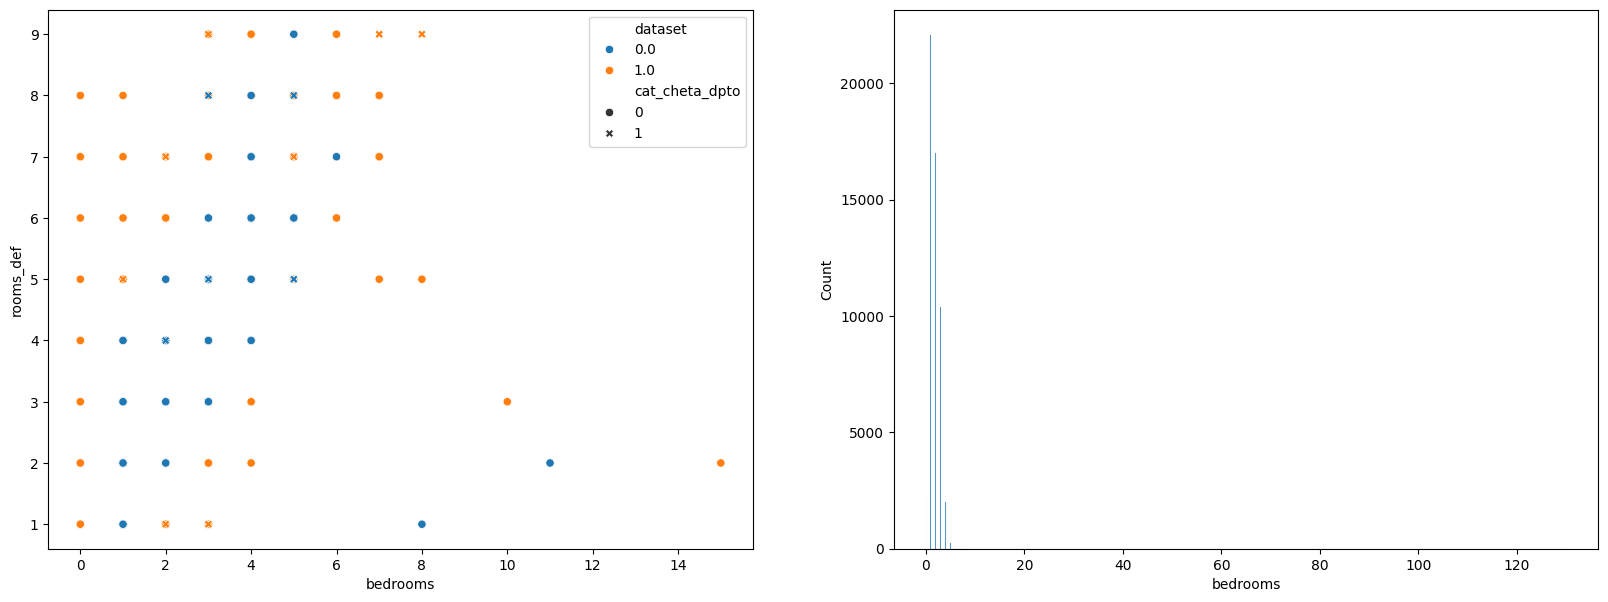

In [166]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_dpto],y="rooms_def",x="bedrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_dpto,"bedrooms"],ax=axes[1])

In [167]:
f=(df["bedrooms"].notna())&(df["rooms_def"]==1)&(df["rooms_def"]<df["bedrooms"])
df.loc[f_dpto & f,"bedrooms"] = 1

In [168]:
f=(df["bedrooms"].notna())&(df["rooms_def"].notna())&(df["rooms_def"]<df["bedrooms"])
df.loc[f_dpto & f,"bedrooms"] = pd.NA

In [169]:
((df["bedrooms"].notna())&(df["rooms_def"].notna())&(df["rooms_def"]<df["bedrooms"])&f_dpto).sum()

np.int64(0)

In [170]:
f=(df["rooms_def"]==1)
df.loc[f_dpto & f,"bedrooms"] = 1

In [171]:
f=(df["bedrooms"]==0)
df.loc[f_dpto & f,"bedrooms"] = pd.NA

<Axes: xlabel='bedrooms', ylabel='Count'>

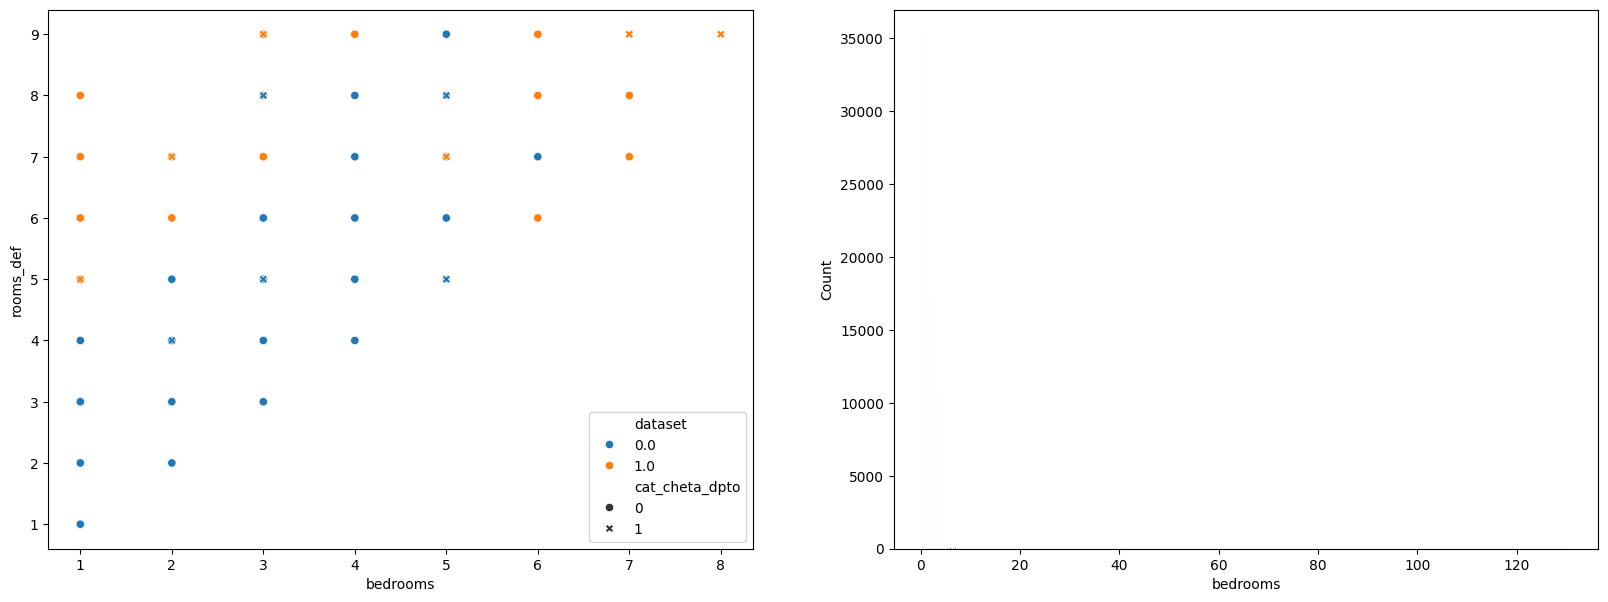

In [172]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_dpto],y="rooms_def",x="bedrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_dpto,"bedrooms"],ax=axes[1])

### 2.3- "Rooms"  - Casas

In [173]:
f_casa=df["property_type"]=="Casa"

<Axes: xlabel='rooms_def', ylabel='Count'>

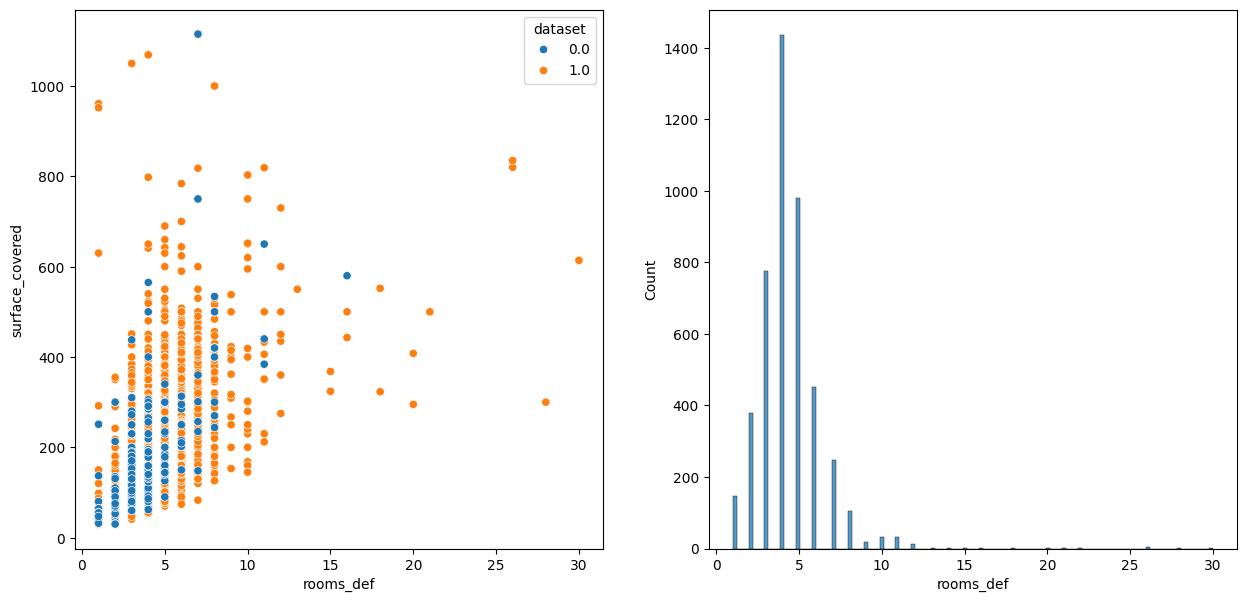

In [174]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
sns.scatterplot(data=df.loc[f_casa],y="surface_covered",x="rooms_def",hue='dataset',ax=axes[0])
sns.histplot(data=df.loc[f_casa,"rooms_def"],ax=axes[1])

### 2.3- "Bathrooms"  - Casas

<Axes: xlabel='bathrooms', ylabel='Count'>

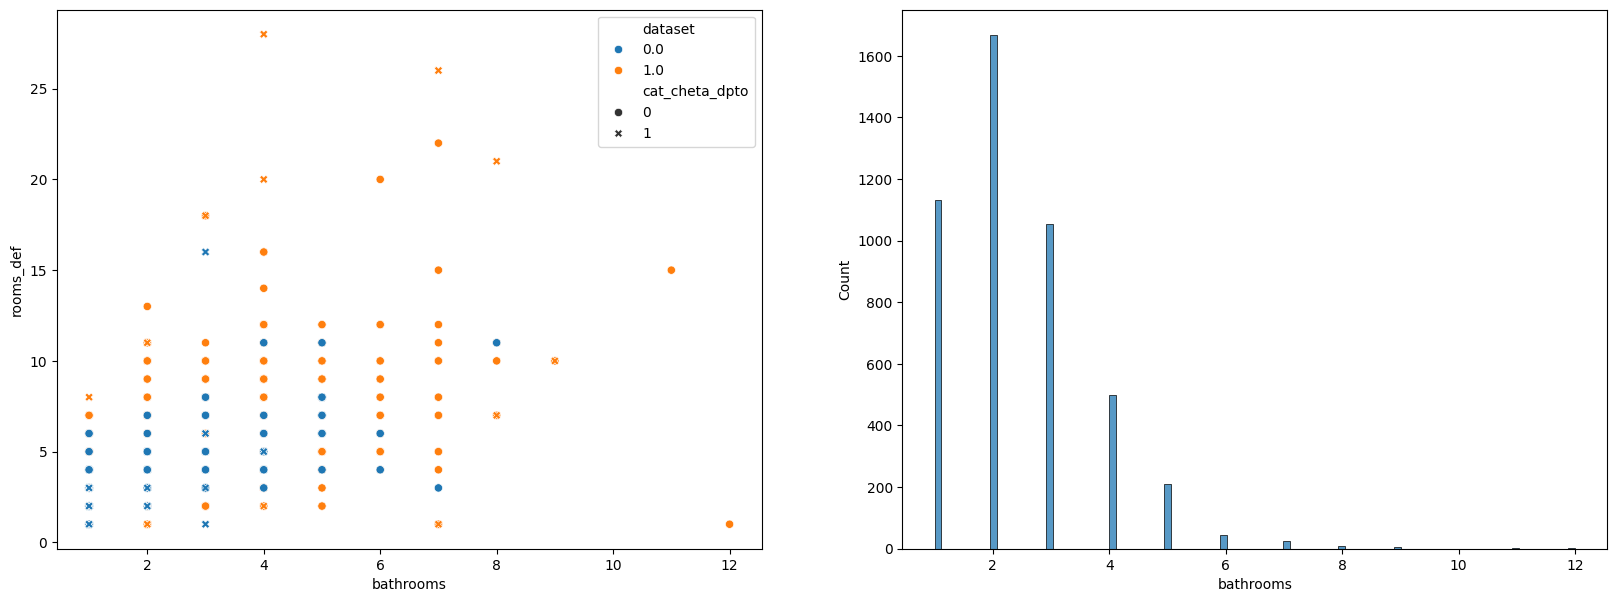

In [175]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_casa],y="rooms_def",x="bathrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_casa,"bathrooms"],ax=axes[1])

In [176]:
f=df["bathrooms"]>8
df.loc[f_casa & f,'bathrooms']=pd.NA

### 2.3- "Bedrooms"  - Casas

In [177]:
f_casa=df["property_type"]=="Casa"

<Axes: xlabel='bedrooms', ylabel='Count'>

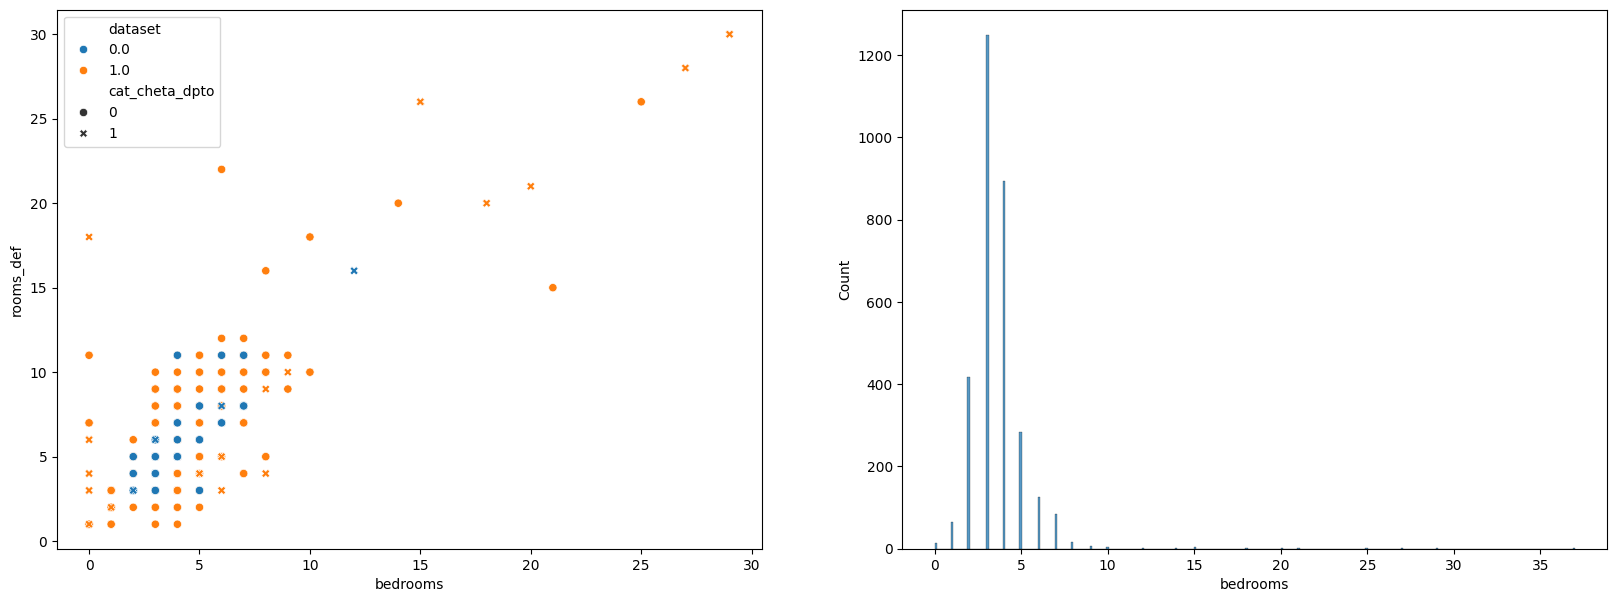

In [178]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_casa],y="rooms_def",x="bedrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_casa,"bedrooms"],ax=axes[1])

In [179]:
f=df["rooms_def"]==1
df.loc[f&f_casa,"bedrooms"]=1

In [180]:
f=df["bedrooms"]==0
df.loc[f&f_casa,"bedrooms"]=pd.NA

In [181]:
f = (df["bedrooms"].notna()) & (df["rooms_def"].notna())&(df["rooms_def"]<df["bedrooms"])
df.loc[f_casa  & f ,"bedrooms"]=pd.NA

<Axes: xlabel='bedrooms', ylabel='Count'>

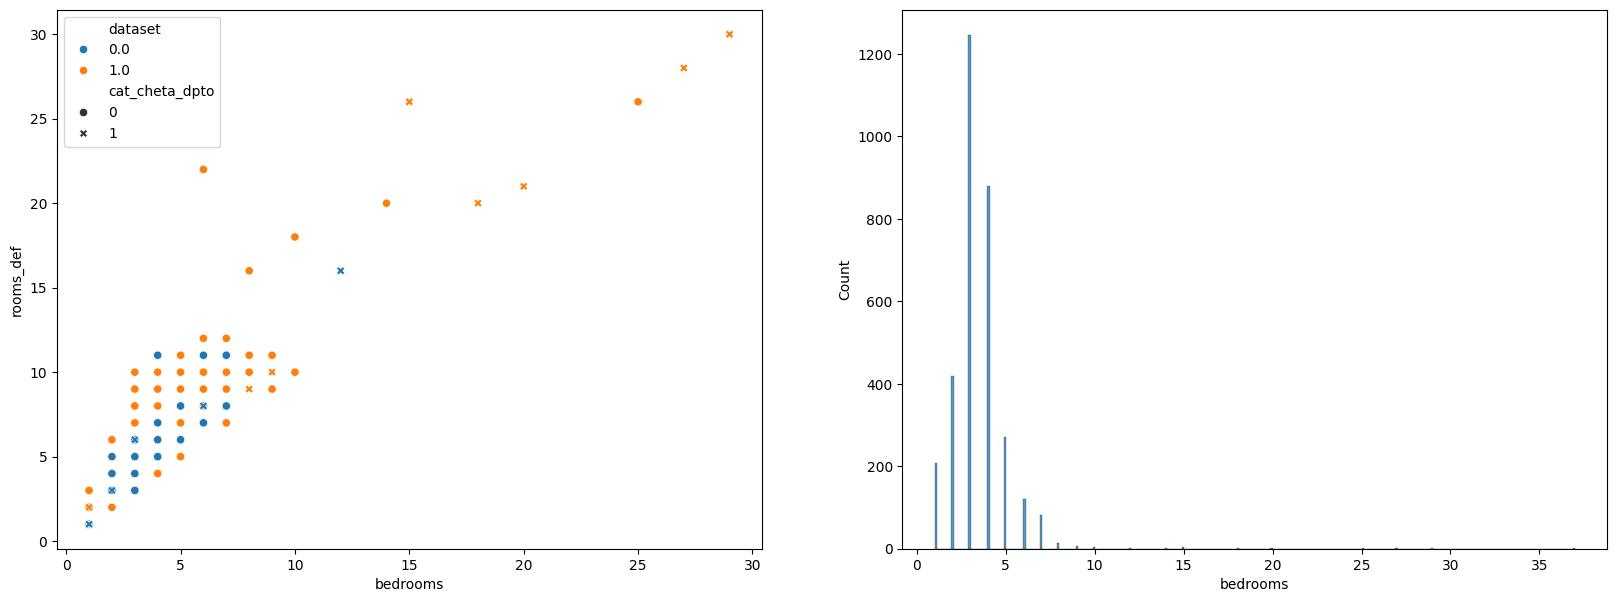

In [182]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_casa],y="rooms_def",x="bedrooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_casa,"bedrooms"],ax=axes[1])

### 2.3- "Rooms"  - Cocheras

In [183]:
f_coch=df["property_type"]=="Cochera"

<Axes: xlabel='rooms', ylabel='Count'>

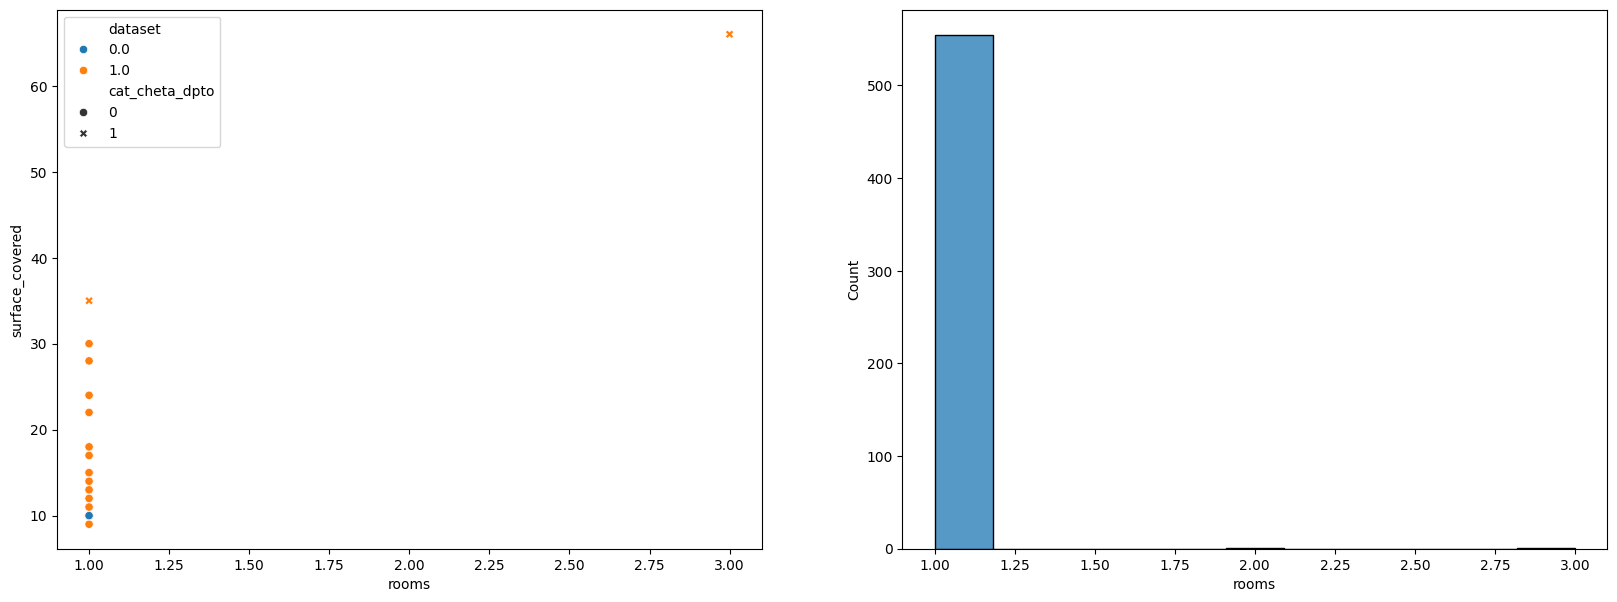

In [184]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_coch],y="surface_covered",x="rooms",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_coch,"rooms"],ax=axes[1])

<Axes: xlabel='rooms', ylabel='Count'>

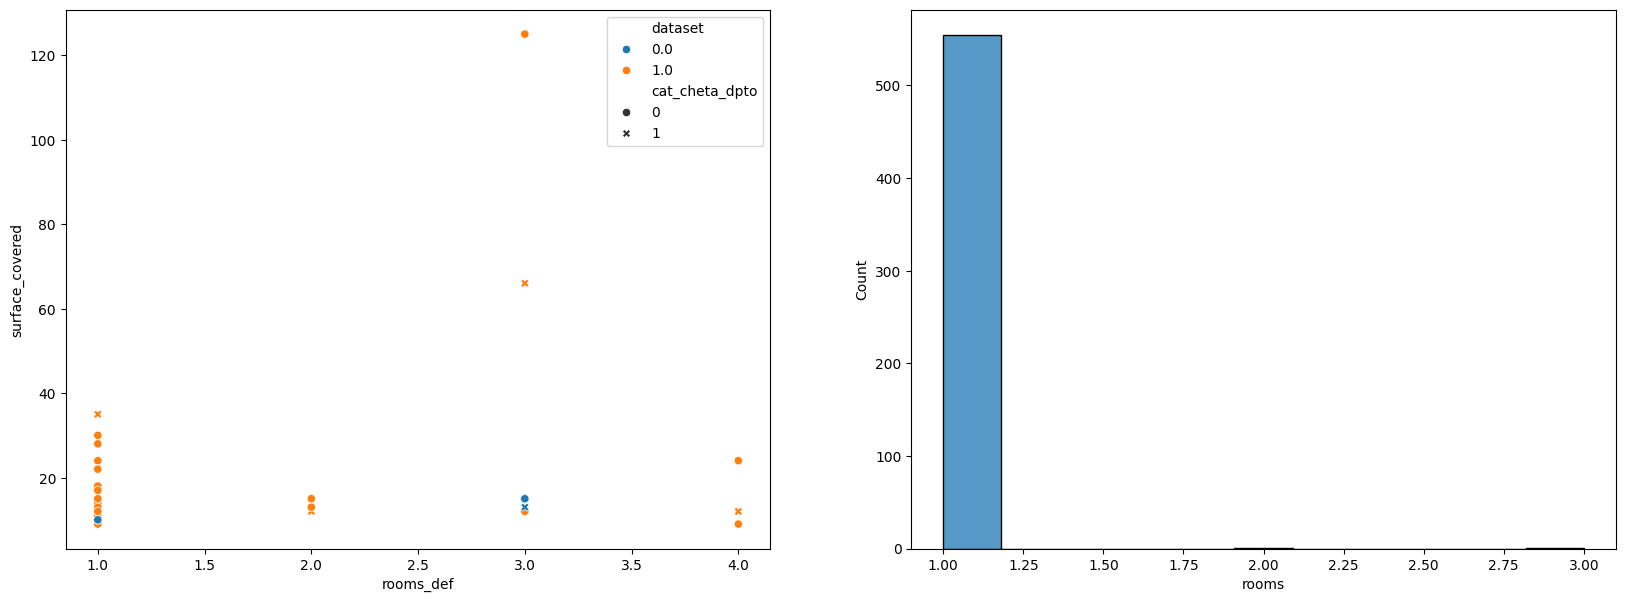

In [185]:
fig,axes=plt.subplots(1,2,figsize=(20,7))
sns.scatterplot(data=df.loc[f_coch],y="surface_covered",x="rooms_def",hue='dataset',style="cat_cheta_dpto",ax=axes[0])
sns.histplot(data=df.loc[f_coch,"rooms"],ax=axes[1])

In [186]:
df.shape

(87476, 33)

In [187]:
f= (df["rooms"]> 1) & (f_coch)
df=df.loc[~f]
df.shape

(87474, 33)

In [188]:
df.loc[f_coch,"rooms"]=0

In [189]:
f_coch=df["property_type"]=="Cochera"
df.loc[f_coch,"rooms_def"] = df.loc[f_coch,"rooms"]

### 2.3- "bathrooms"  - Cocheras

In [190]:
f=df["property_type"]=="Cochera"
df.loc[f,"bathrooms"]=0

In [191]:
f=df["property_type"]=="Cochera"
df.loc[f,"bedrooms"]=0

### 2.7 - Outlayers analisis multivariado

#### DEPARTAMENTOS - ANALISIS BIVARIADO (rooms_def VS surface_covered)

Si bien es un analisis bivariado, al hacer el analisis para cada valor de rooms_def, o al menos hasta los primeros, es como uno univariado. Aca detectaremos outlayers con las tecnicas de boxplot.

Vamos a calcular para c/rooms_def, los outlayers de surface_covered con IQR. Filtraremos, y haremos un analisis de :
- Los posibles que son errores. --> los que tienen surface elevadas para lo que son (monoambientes o de pocos)
- Los posibles que esten bien pero pertenezcan a la cat cheta --> que tienen pocos ambientes pero que son gigantes

<Axes: xlabel='rooms_def', ylabel='surface_total'>

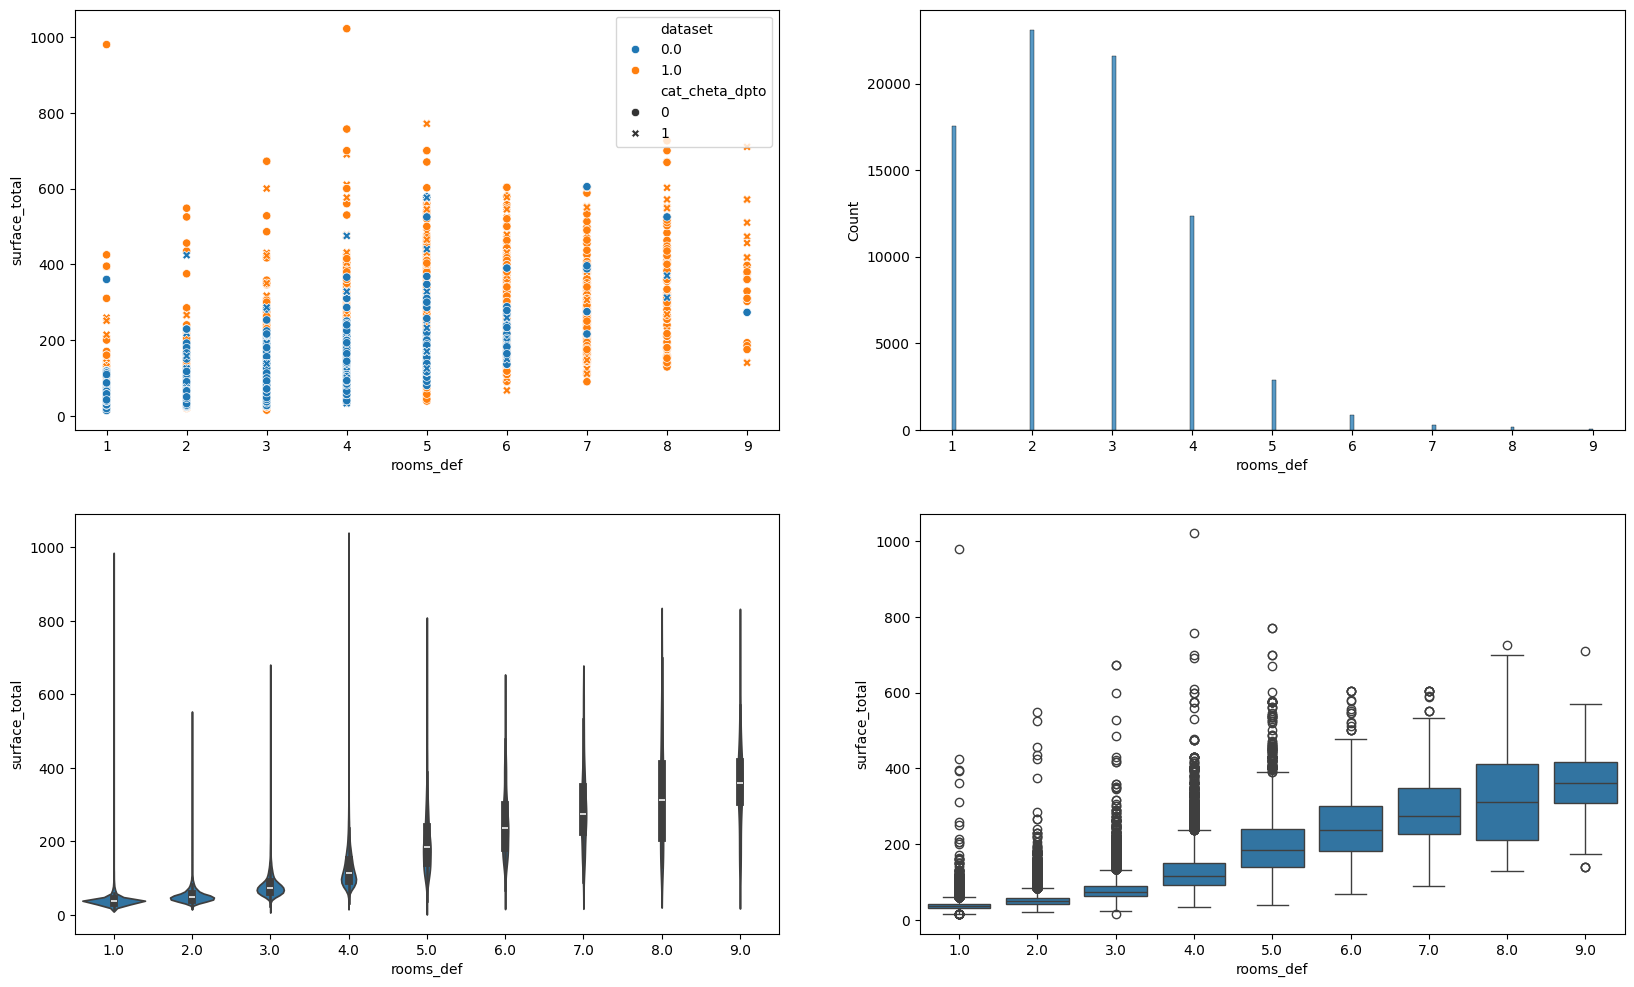

In [192]:
f_dpto=df["property_type"] =="Departamento"
f=(df["rooms_def"].notna())

fig,axes=plt.subplots(2,2,figsize=(20,12))
sns.scatterplot(data=df.loc[f_dpto],y="surface_total",x="rooms_def",hue='dataset',style="cat_cheta_dpto",ax=axes[0,0])
sns.histplot(data=df.loc[f_dpto,"rooms_def"],ax=axes[0,1])


sns.violinplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_total",ax=axes[1,0])
sns.boxplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_total",ax=axes[1,1])

<Axes: xlabel='rooms_def', ylabel='surface_covered'>

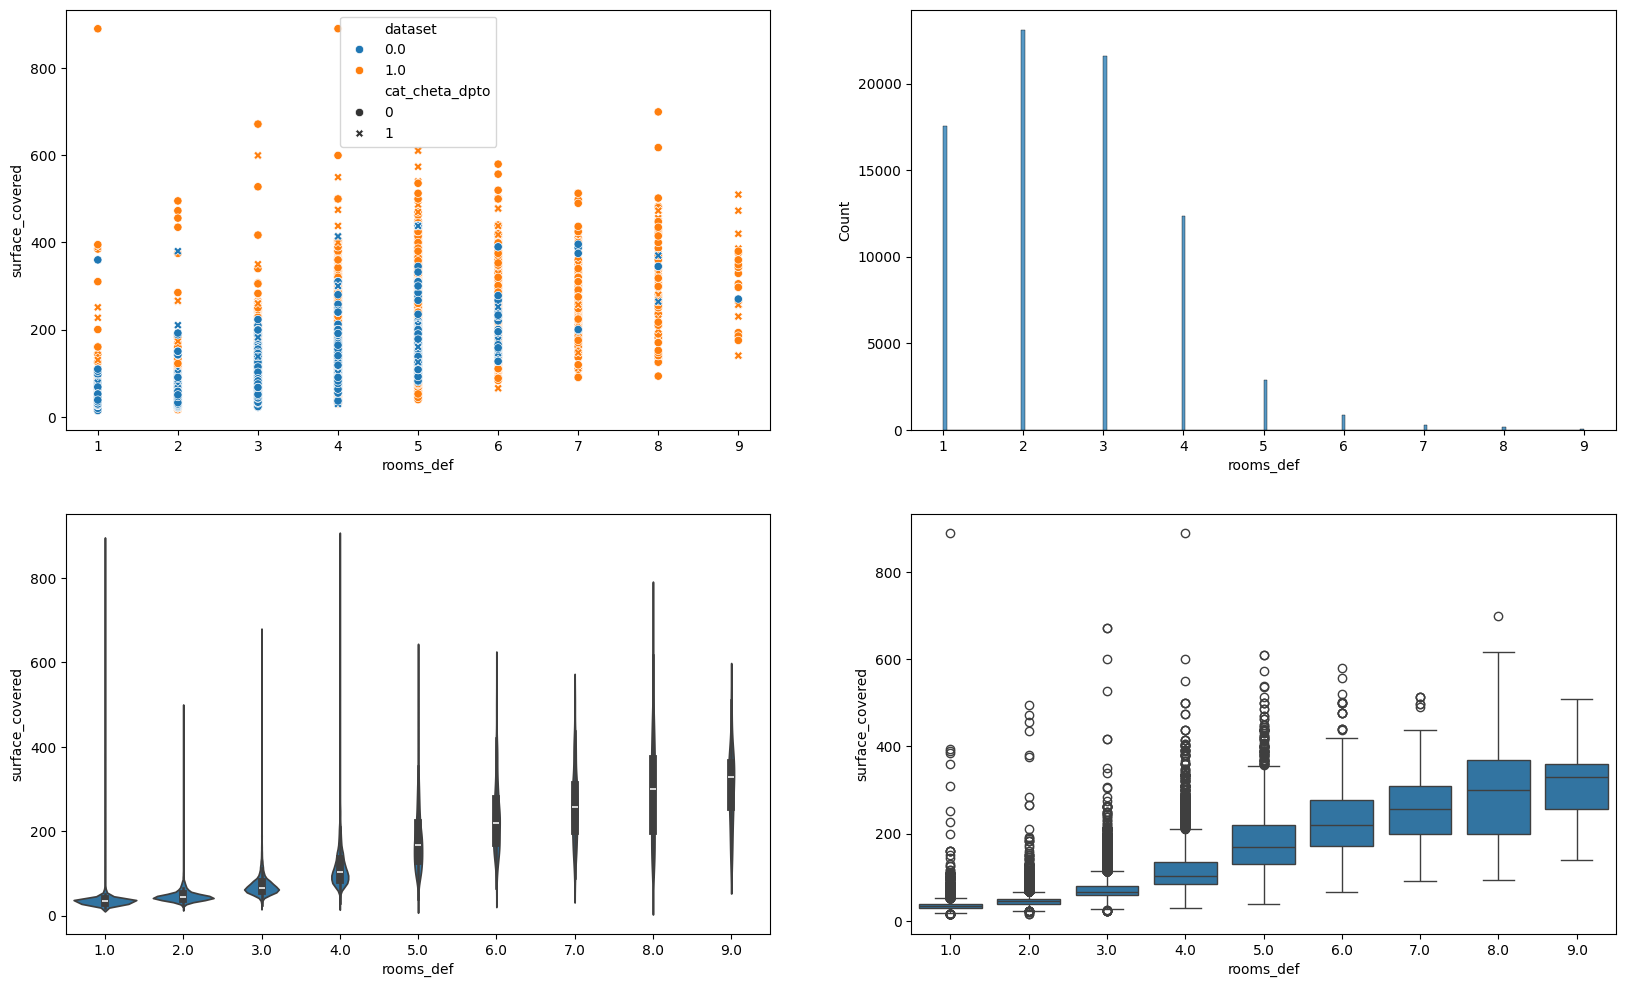

In [193]:
f_dpto=df["property_type"] =="Departamento"
f=(df["rooms_def"].notna())

fig,axes=plt.subplots(2,2,figsize=(20,12))
sns.scatterplot(data=df.loc[f_dpto],y="surface_covered",x="rooms_def",hue='dataset',style="cat_cheta_dpto",ax=axes[0,0])
sns.histplot(data=df.loc[f_dpto,"rooms_def"],ax=axes[0,1])


sns.violinplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_covered",ax=axes[1,0])
sns.boxplot(data=df.loc[f_dpto&f],x="rooms_def",y="surface_covered",ax=axes[1,1])


In [194]:
outlayers_bivar={}

property_types = ["Departamento","Casa","Cochera"]
surfaces=["surface_covered","surface_total"]

for pt in property_types:
  outlayers_bivar[pt]={}
  f_pt=df["property_type"]==pt
  rooms=sorted(list(df.loc[f_pt,"rooms_def"].dropna().unique()))

  for s in surfaces:
    outlayers_bivar[pt][s]={}

    for r in rooms:
      outlayers_bivar[pt][s][r]={}

      f_room=df["rooms_def"]==r
      f_nan=df[s].notna()

      values=df.loc[f_pt & f_room & f_nan,s]

      if len(values)>0:
        q1,q3=np.percentile(values , [25,75])
        iqr= q3 - q1
        lim_inf=q1-1.5*iqr
        lim_sup=q3+1.5*iqr
        outlayers_bivar[pt][s][r]["lim_inf"]=lim_inf
        outlayers_bivar[pt][s][r]["lim_sup"]=lim_sup
      else:
        outlayers_bivar[pt][s][r]["lim_inf"]=None
        outlayers_bivar[pt][s][r]["lim_sup"]=None

In [195]:
outlayers_bivar["Departamento"]["surface_covered"][1]["lim_inf"]

np.float64(16.5)

In [196]:
df.loc[[39139,80255,309597],"surface_covered"]=df.loc[[39139,80255,309597],"surface_covered"]/10
df.loc[[39139,80255,309597],"surface_total"]=df.loc[[39139,80255,309597],"surface_total"]/10

In [197]:
f= df["surface_covered"]/10 > 20
f_pt = df["property_type"] =="Departamento"
f_room1 = df["rooms_def"] == 2
f_sup1 = df["surface_covered"] > outlayers_bivar["Departamento"]["surface_covered"][2]["lim_sup"]
f_cat = df["cat_cheta_dpto"] == 0
df.loc[f & f_pt & f_room1 & f_sup1 & f_cat,"surface_covered"] = df.loc[f & f_pt & f_room1 & f_sup1 & f_cat,"surface_covered"] /10
df.loc[f & f_pt & f_room1 & f_sup1 & f_cat,"surface_total"] = df.loc[f & f_pt & f_room1 & f_sup1 & f_cat,"surface_total"] /10

<Axes: xlabel='rooms_def', ylabel='surface_covered'>

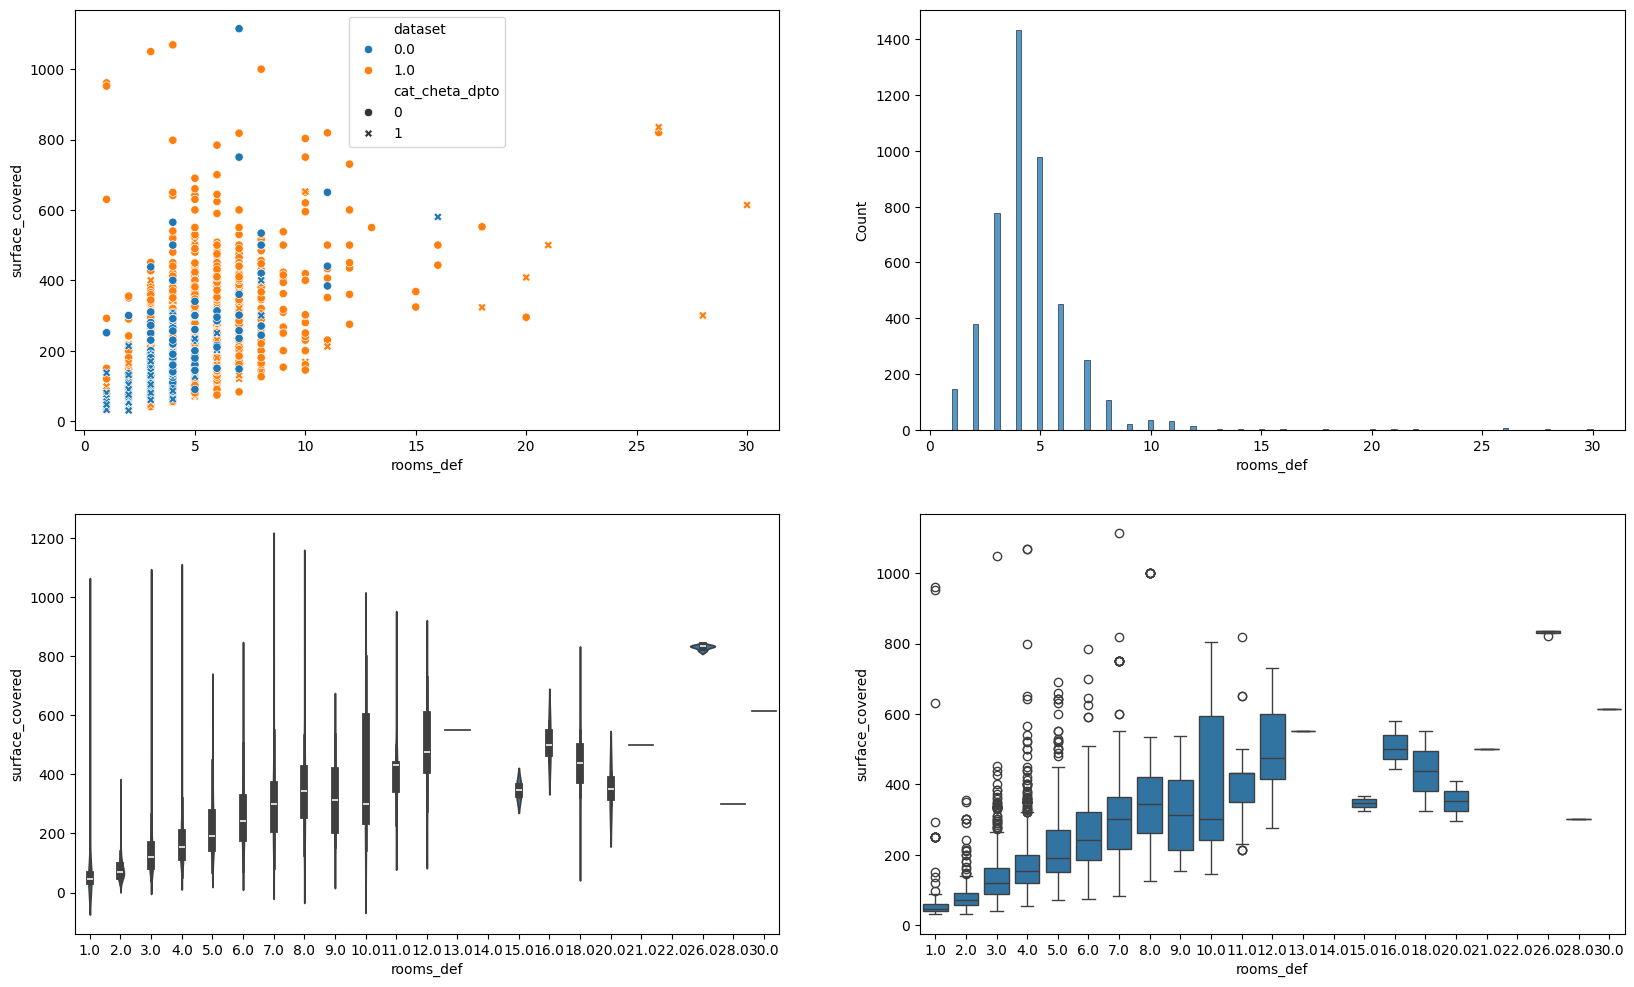

In [198]:
f_pt=df["property_type"] =="Casa"
f=(df["rooms_def"].notna())

fig,axes=plt.subplots(2,2,figsize=(20,12))
sns.scatterplot(data=df.loc[f_pt],y="surface_covered",x="rooms_def",hue='dataset',style="cat_cheta_dpto",ax=axes[0,0])
sns.histplot(data=df.loc[f_pt,"rooms_def"],ax=axes[0,1])


sns.violinplot(data=df.loc[f_pt&f],x="rooms_def",y="surface_covered",ax=axes[1,0])
sns.boxplot(data=df.loc[f_pt&f],x="rooms_def",y="surface_covered",ax=axes[1,1])

In [199]:
outlayers_bivar["Casa"]["surface_covered"][1]["lim_sup"]

np.float64(90.625)

In [200]:
f_pt = df["property_type"] =="Casa"
f_room = df["rooms_def"] == 1
f_sup = df["surface_total"] > outlayers_bivar["Casa"]["surface_total"][1]["lim_sup"]
df.loc[f_pt & f_room & f_sup,["surface_covered","surface_total","title","description"]].sort_values(by="surface_total",ascending=False)

surface_covered  surface_total  \
id                                       
150497            961.0          961.0   
150470            952.0          952.0   
557988            630.0          630.0   
201744            251.0          502.0   
93363             251.0          502.0   
29179             251.0          502.0   
388242            251.0          502.0   
711453            251.0          502.0   
975343            251.0          502.0   
380988            251.0          502.0   
292949            251.0          502.0   
462959            251.0          502.0   
189578            251.0          502.0   
982250            292.0          322.0   
237651            137.0          227.0   
649747             79.0          190.0   
213347            150.0          150.0   

                                                    title  \
id                                                          
150497                 Moldes Al  2700 -  - Casa en Venta   
150470                Sarmiento   4000 -  - Casa en Venta   
557988                     Suarez  500 -  - Casa en Venta   
201744               Casa de 1 ambiente en Venta en Boedo   
93363                Casa de 1 ambiente en Venta en Boedo   
29179                Casa de 1 ambiente en Venta en Boedo   
388242               Casa de 1 ambiente en Venta en Boedo   
711453               Casa de 1 ambiente en Venta en Boedo   
975343               Casa de 1 ambiente en Venta en Boedo   
380988               Casa de 1 ambiente en Venta en Boedo   
292949               Casa de 1 ambiente en Venta en Boedo   
462959               Casa de 1 ambiente en Venta en Boedo   
189578               Casa de 1 ambiente en Venta en Boedo   
982250                     Inmueble con 12 monoambientes.   
237651      Cnel M Roseti  400 -  - Tipo casa PH en Venta   
649747      Helguera  2200 1°  -  - Tipo casa PH en Venta   
213347  Casa sobre lote 9 x 17,5 mts. Pje. Jose O. Gor...   

                                              description  
id                                                         
150497  Venta de lote para construir en Belgrano Molde...  
150470  Venta de casa lote para construir 7 plantas en...  
557988  Extenso terreno con posibilidad de construir 2...  
201744  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
93363   PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
29179   PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
388242  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
711453  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
975343  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
380988  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
292949  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
462959  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
189578  PROPIEDAD TOTALMENTE A REPARAR - COMERCIALIZA ...  
982250  Inmueble dividido en 12 monoambientes, con int...  
237651  """AVISO IMPORTANTE : SE ENCUENTRAN SUSPENDIDA...  
649747  Propiedad en Venta, Tipo casa PH en primer pis...  
213347  Casa sobre lote propio de 9 x 17,50 mts. Garag...

### 2.6- "Price"

In [201]:
f_usd=df["currency"]=="USD"
f_ars = df["currency"]=="ARS"

In [202]:
df.shape

(87474, 33)

c:\Users\chris\Data_science\Ms Data Mining UBA\DM\house_predictions\env_dm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


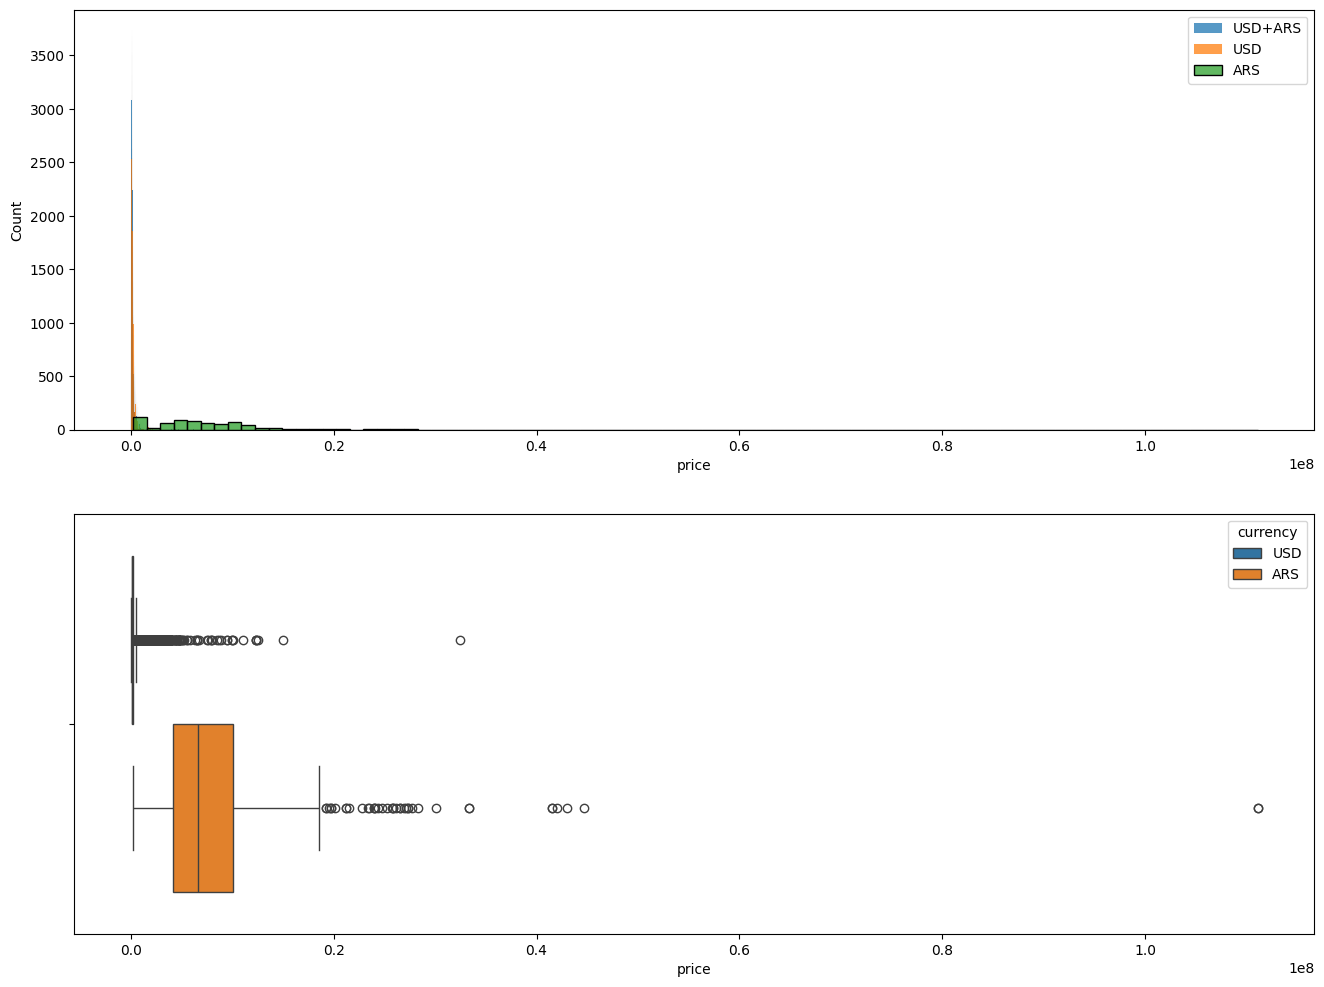

In [203]:
fig,axes=plt.subplots(2,1,figsize=(16,12))
sns.histplot(data=df.loc[f_ent,"price"],ax=axes[0], label="USD+ARS")
sns.histplot(data=df.loc[f_ent & f_usd,"price"],ax=axes[0], label="USD")
sns.histplot(data=df.loc[f_ent & f_ars,"price"],ax=axes[0], label="ARS")
axes[0].legend()
sns.boxplot(data=df.loc[f_ent],x="price" , hue="currency")
plt.show()

- Precios en URS con problemas de ceros
- Precios en ARS con problemas de ceros
- Hay precios en USD que estan en ARS ?
- Hay precios en ARS que estan en USD ?

In [204]:
tc_dict = {
    '2019-7': 43.7,
    '2019-8': 60,
    '2019-9': 58.25,
    '2019-10': 66.1,
    '2019-11': 66.25,
    '2019-12': 73.5,
    '2020-1': 74,
    '2020-2': 74.5,
    '2020-3': 78.5,
    '2020-4': 108,
    '2020-5': 115,
    '2020-6': 116,
    '2020-7': 131
}

In [205]:
def tc_extraction(val):
  month = val.month
  year = val.year
  date=str(year)+'-'+str(month)
  tc = tc_dict[date]
  return tc

def conversion_ars_to_usd(df):
  df["tc"]=df["start_date"].apply(tc_extraction)
  f=(df["currency"]=="ARS") & (df["price"].notna())
  f2=(df["currency"]=="USD") & (df["price"].notna())
  df.loc[f,"price_new"] = df.loc[f,"price"] /df.loc[f,"tc"]
  df.loc[f2,"price_new"] = df.loc[f2,"price"]
  return df



In [206]:
df = conversion_ars_to_usd(df)

In [207]:
df["price_m2"] = df["price_new"]/df["surface_covered"]

In [208]:
df.shape

(87474, 36)

In [209]:
f_ent = df["price"].notna()
f_ap = df["price"].isna()

In [210]:
df.loc[f_ap].shape

(7012, 36)

In [211]:
set_ent=set(df.loc[f_ent,"l4"].unique())

In [212]:
set_ap=set(df.loc[f_ap,"l4"].dropna().unique())

In [213]:
set_ent == set_ap

True

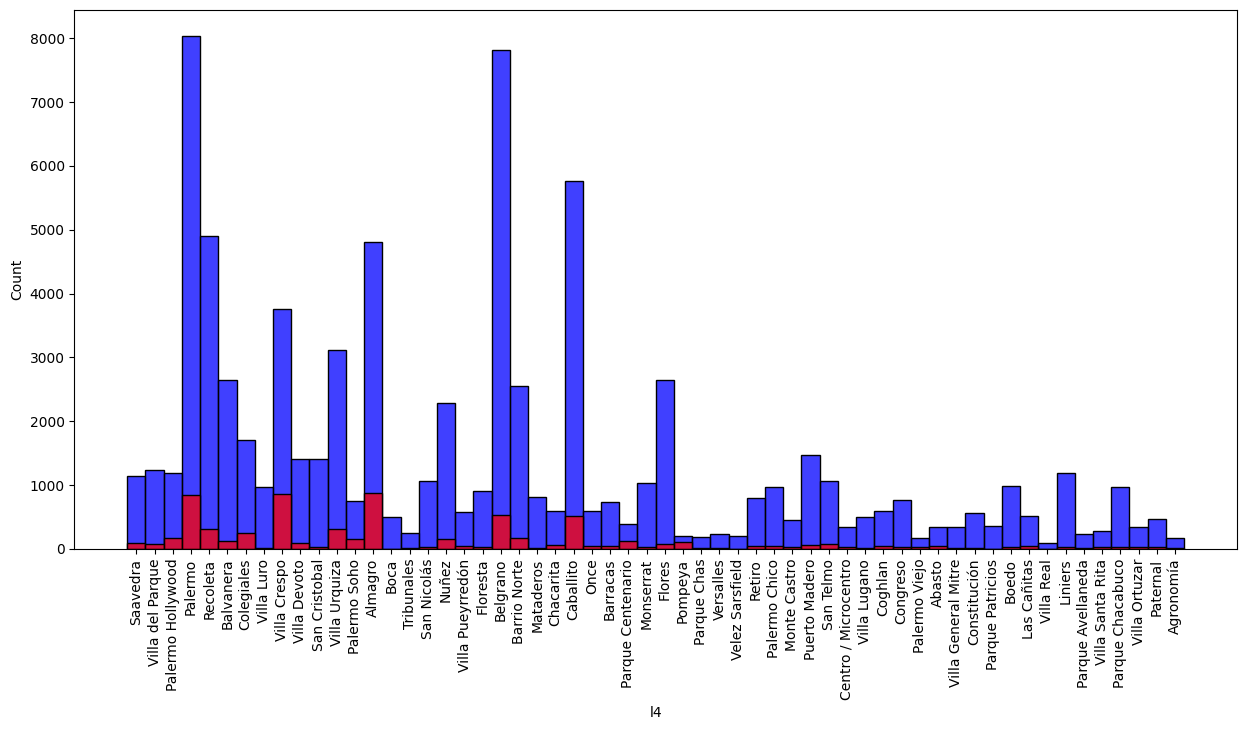

In [214]:
plt.figure(figsize=(15,7))
sns.histplot(data=df.loc[f_ent],x="l4",color="blue")
sns.histplot(data=df.loc[f_ap],x="l4",color="red")
plt.xticks(rotation=90)
plt.show()

In [215]:
df.loc[f_ent,"l4"].value_counts()[:15]

l4
Palermo          8039
Belgrano         7820
Caballito        5768
Recoleta         4908
Almagro          4804
Villa Crespo     3757
Villa Urquiza    3122
Flores           2653
Balvanera        2648
Barrio Norte     2551
Nuñez            2290
Colegiales       1713
Puerto Madero    1469
Villa Devoto     1416
San Cristobal    1406
Name: count, dtype: int64

In [216]:
df_ap_temp=df.loc[f_ap].copy()

In [217]:
df_ap_temp["l4"].value_counts(normalize=False)[:16]

l4
Almagro              871
Villa Crespo         858
Palermo              840
Belgrano             535
Caballito            513
Recoleta             315
Villa Urquiza        309
Colegiales           256
Barrio Norte         169
Palermo Hollywood    167
Nuñez                150
Palermo Soho         149
Parque Centenario    128
Balvanera            121
Pompeya              109
Saavedra              97
Name: count, dtype: int64

In [218]:
df_ap_temp["l4"].value_counts(normalize=False)[:25]

l4
Almagro              871
Villa Crespo         858
Palermo              840
Belgrano             535
Caballito            513
Recoleta             315
Villa Urquiza        309
Colegiales           256
Barrio Norte         169
Palermo Hollywood    167
Nuñez                150
Palermo Soho         149
Parque Centenario    128
Balvanera            121
Pompeya              109
Saavedra              97
Villa Devoto          93
Villa del Parque      82
San Telmo             73
Flores                71
Puerto Madero         65
Chacarita             56
Las Cañitas           54
Retiro                51
Coghlan               51
Name: count, dtype: int64

In [219]:
f_ent=df["price"].notna()
df.loc[f_ent].shape

(80462, 36)

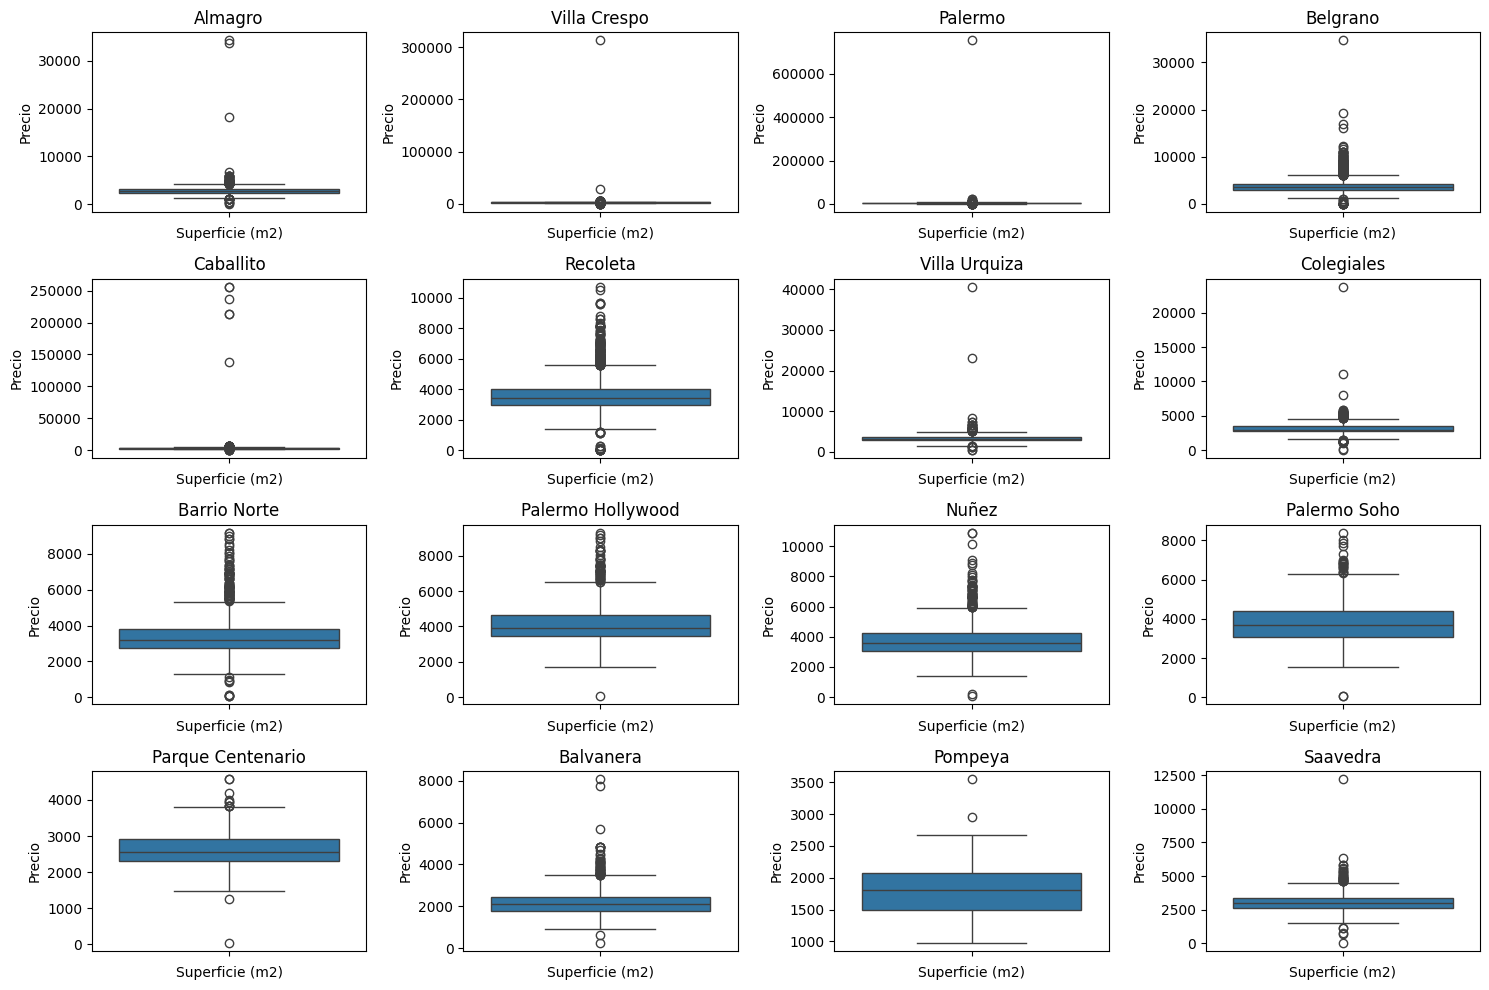

In [220]:
l4_importantes = (df_ap_temp["l4"].value_counts(normalize=False)[:16]).index
f_dpto= df["property_type"]=="Departamento"
f_ent=df["price"].notna()
fig,axes=plt.subplots(4,4,figsize=(15,10))
axes = axes.flatten()
for i,l4 in enumerate(l4_importantes):
  f_l4 = df["l4"]==l4
  ax=axes[i]
  sns.boxplot(data=df.loc[f_ent&f_dpto&f_l4],y="price_m2",ax=ax)
  ax.set_title(l4)
  ax.set_xlabel("Superficie (m2)")
  ax.set_ylabel("Precio")
plt.tight_layout()
plt.show()

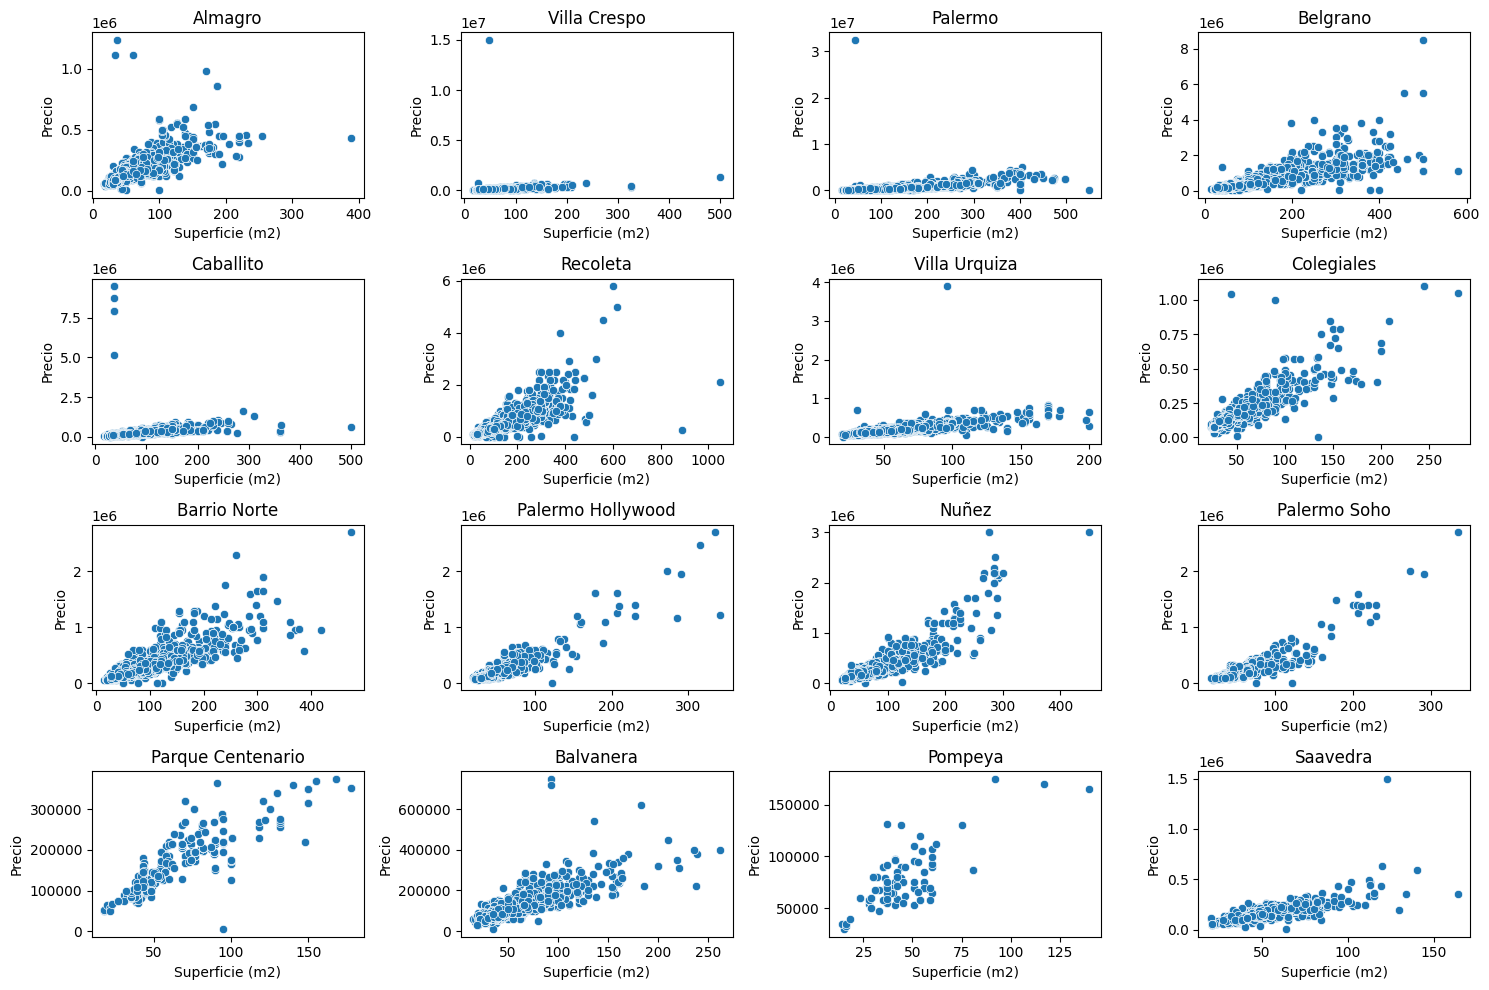

In [221]:
l4_importantes = (df_ap_temp["l4"].value_counts(normalize=False)[:16]).index
f_dpto= df["property_type"]=="Departamento"
f_ent=df["price"].notna()
fig,axes=plt.subplots(4,4,figsize=(15,10))
axes = axes.flatten()
for i,l4 in enumerate(l4_importantes):
  f_l4 = df["l4"]==l4
  ax=axes[i]
  sns.scatterplot(data=df.loc[f_ent&f_dpto&f_l4],x="surface_covered",y="price_new",ax=ax)
  ax.set_title(l4)
  ax.set_xlabel("Superficie (m2)")
  ax.set_ylabel("Precio")
plt.tight_layout()
plt.show()

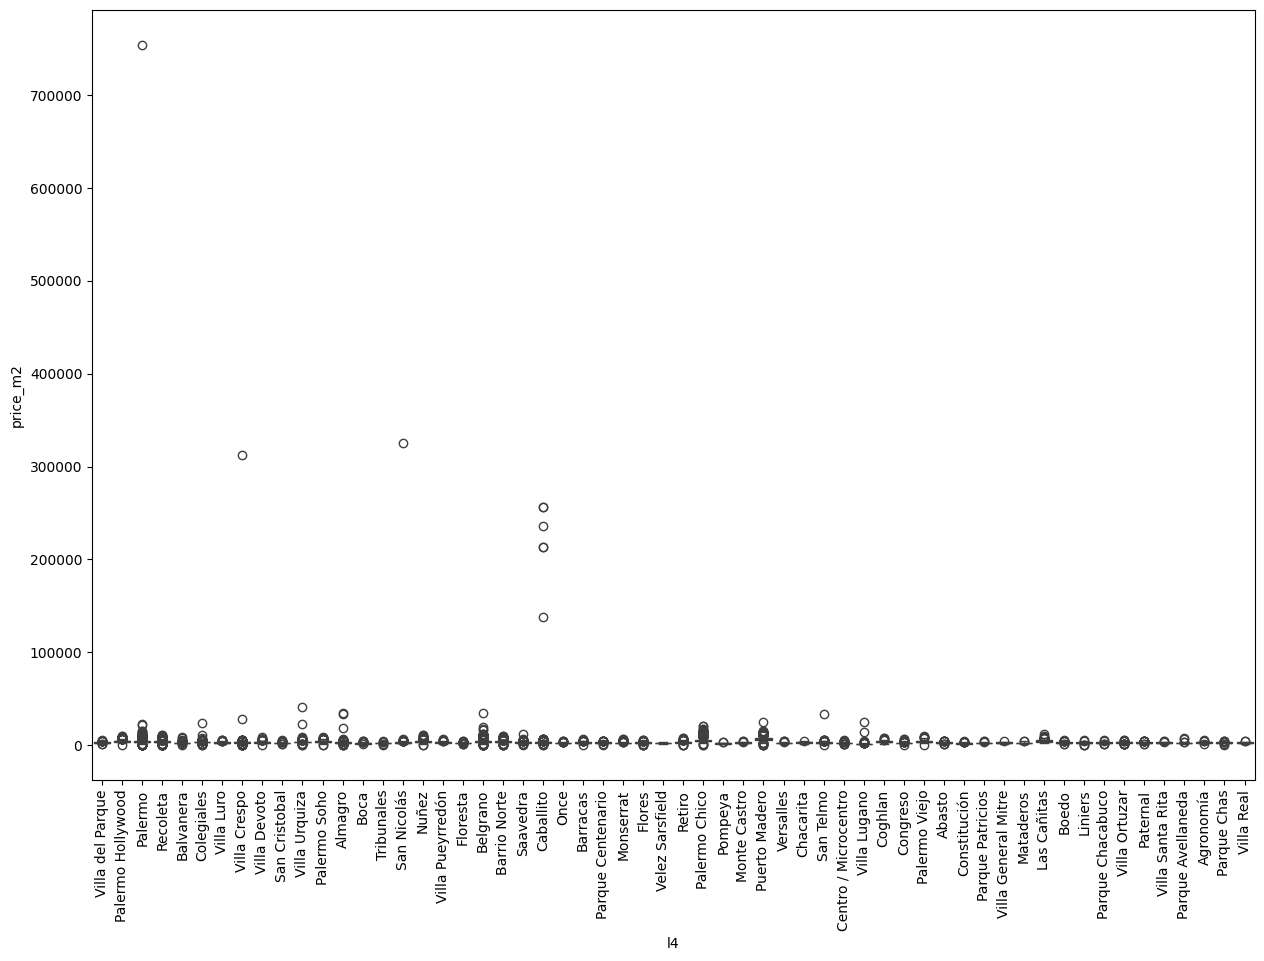

In [222]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df.loc[f_ent & f_dpto ],x="l4",y="price_m2")
plt.xticks(rotation=90)
plt.show()

In [223]:
outlayers_price_m2={}

barrios = (df.loc[f_ent,"l4"].value_counts()).index
property_types=["Departamento","Casa","Cochera"]

for pt in property_types:
  outlayers_price_m2[pt]={}
  f_pt=df["property_type"]==pt


  for l4 in barrios:
    outlayers_price_m2[pt][l4]={}

    f_l4=df["l4"]==l4
    f_nan=df["price_m2"].notna()

    values=df.loc[f_pt & f_l4 & f_nan,"price_m2"]

    if len(values)>0:
      q1,q3=np.percentile(values , [25,75])
      iqr= q3 - q1
      lim_inf=q1-1.5*iqr
      lim_sup=q3+1.5*iqr
      outlayers_price_m2[pt][l4]["lim_inf"]=lim_inf
      outlayers_price_m2[pt][l4]["lim_sup"]=lim_sup
    else:
      outlayers_price_m2[pt][l4]["lim_inf"]=None
      outlayers_price_m2[pt][l4]["lim_sup"]=None

In [224]:
df_copy = df.copy()

In [225]:
barrios = (df_copy.loc[f_ent,"l4"].value_counts()).index
property_types=["Departamento","Casa","Cochera"]
limites = ["lim_inf","lim_sup"]
for pt in property_types:
  f_pt=df_copy["property_type"]== pt
  for l4 in barrios:
    f_l4=df_copy["l4"]==l4
    for lim in limites:
      if lim=="lim_inf":
        f_lim=df_copy["price_m2"] < outlayers_price_m2[pt][l4][lim]
        df_copy=df_copy.loc[~(f_pt & f_l4 & f_lim)]
      elif lim=="lim_sup":
        f_lim=df_copy["price_m2"] > outlayers_price_m2[pt][l4][lim]
        df_copy=df_copy.loc[~(f_pt & f_l4 & f_lim)]


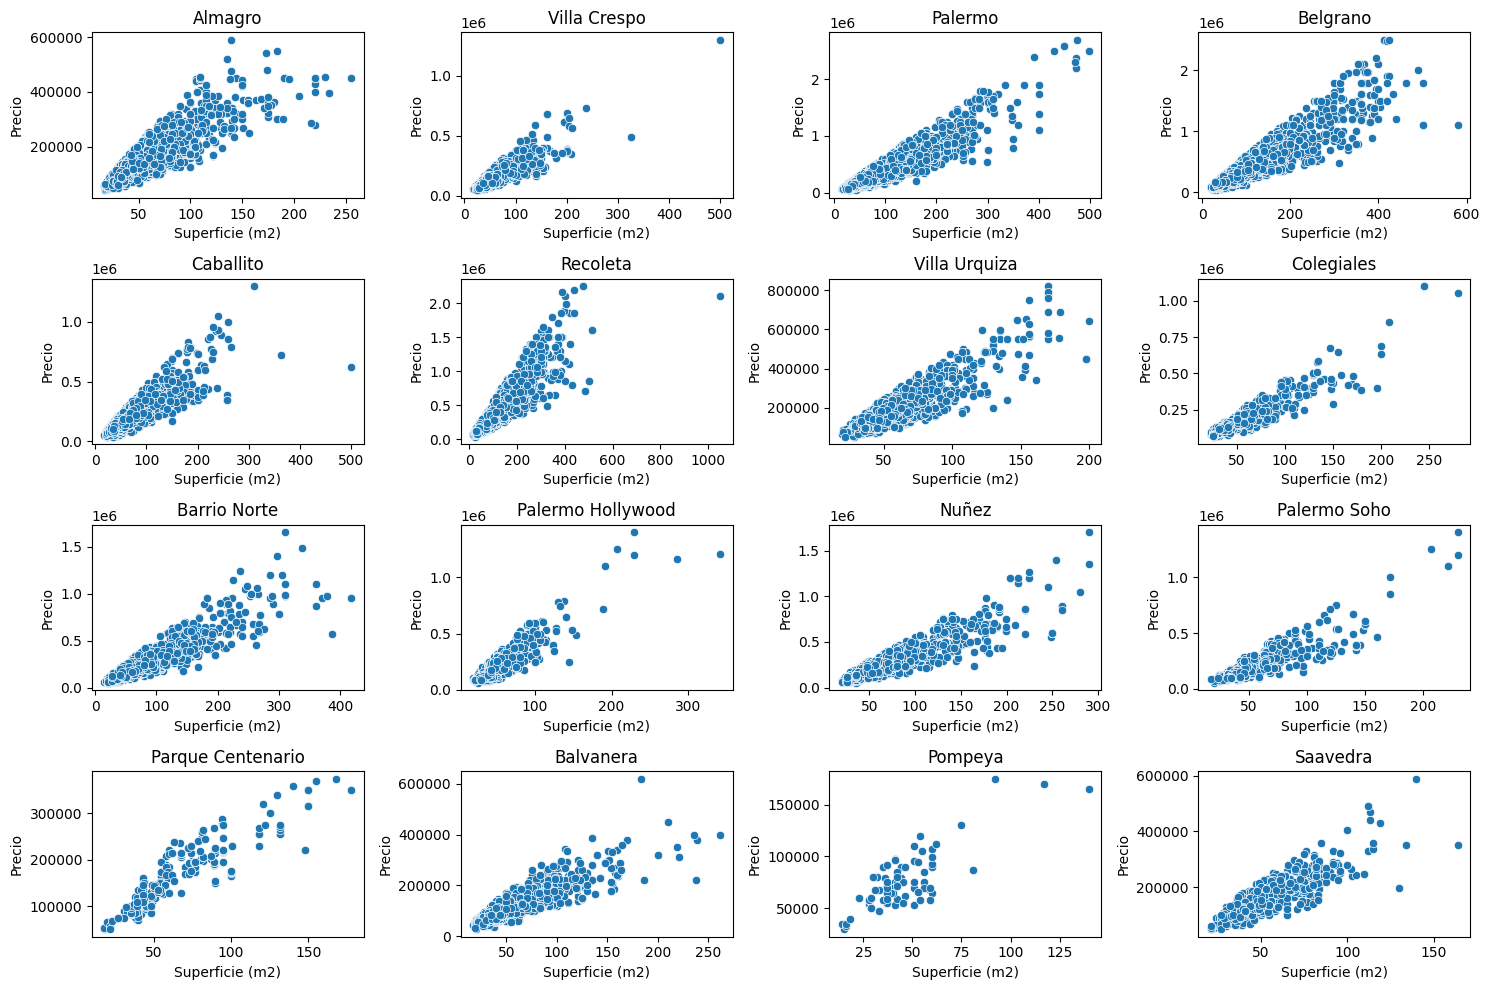

In [226]:
l4_importantes = (df_ap_temp["l4"].value_counts(normalize=False)[:16]).index
f_dpto= df_copy["property_type"]=="Departamento"
f_ent=df_copy["price"].notna()
fig,axes=plt.subplots(4,4,figsize=(15,10))
axes = axes.flatten()
for i,l4 in enumerate(l4_importantes):
  f_l4 = df["l4"]==l4
  ax=axes[i]
  sns.scatterplot(data=df_copy.loc[f_ent&f_dpto&f_l4],x="surface_covered",y="price_new",ax=ax)
  ax.set_title(l4)
  ax.set_xlabel("Superficie (m2)")
  ax.set_ylabel("Precio")
plt.tight_layout()
plt.show()

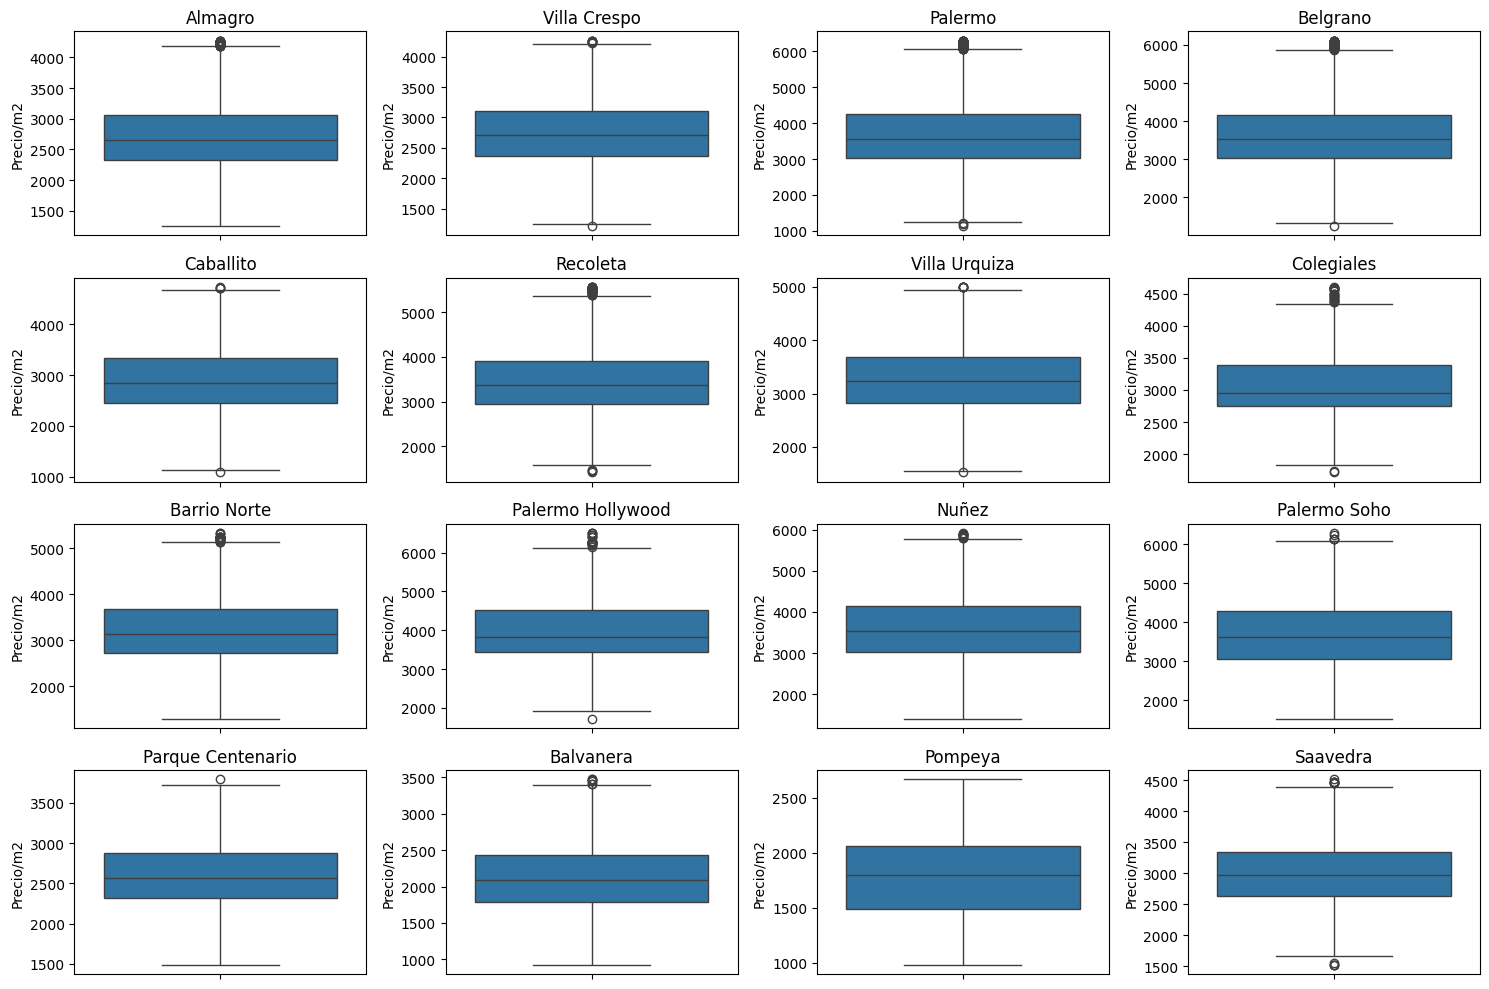

In [227]:
l4_importantes = (df_ap_temp["l4"].value_counts(normalize=False)[:16]).index
f_dpto= df_copy["property_type"]=="Departamento"
f_ent=df_copy["price"].notna()
fig,axes=plt.subplots(4,4,figsize=(15,10))
axes = axes.flatten()
for i,l4 in enumerate(l4_importantes):
  f_l4 = df["l4"]==l4
  ax=axes[i]
  sns.boxplot(data=df_copy.loc[f_ent&f_dpto&f_l4],y="price_m2",ax=ax)
  ax.set_title(l4)
  ax.set_ylabel("Precio/m2")
plt.tight_layout()
plt.show()

<Axes: xlabel='surface_covered', ylabel='price_new'>

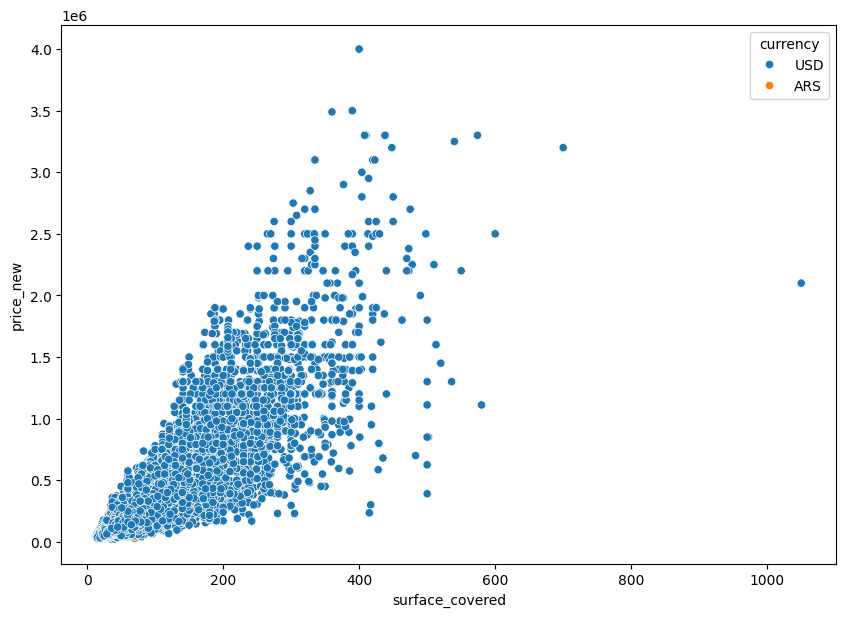

In [228]:
plt.figure(figsize=(10,7))
f_ent=df_copy["price"].notna()
f_dpto=df_copy["property_type"]=="Departamento"
sns.scatterplot(data=df_copy.loc[f_ent&f_dpto], x="surface_covered",y="price_new",hue="currency")

# PUNTO DE CONTROL

In [229]:
df=df_copy.copy()

In [230]:
df.shape

(85209, 36)

In [231]:
f_ent=df["price"].notna()
f_ap=df["price"].isna()
print(df.loc[f_ent].shape)
print(df.loc[f_ap].shape)

(78197, 36)
(7012, 36)


In [232]:
df.loc[f_ent,"property_type"].value_counts(normalize=True)


property_type
Departamento    0.907439
Casa            0.060437
Cochera         0.032124
Name: proportion, dtype: float64

In [233]:
df.loc[f_ap,"property_type"].value_counts(normalize=True)


property_type
Departamento    0.940388
Casa            0.046634
Cochera         0.012978
Name: proportion, dtype: float64

In [234]:
df.loc[f_ent].info()

<class 'pandas.core.frame.DataFrame'>
Index: 78197 entries, 143984 to 464556
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         78197 non-null  datetime64[ns]
 1   end_date           78197 non-null  object        
 2   lat                78197 non-null  float64       
 3   lon                78197 non-null  float64       
 4   l3                 78197 non-null  object        
 5   l4                 78197 non-null  object        
 6   rooms              72948 non-null  float64       
 7   bedrooms           62805 non-null  float64       
 8   bathrooms          73745 non-null  float64       
 9   surface_total      60185 non-null  float64       
 10  surface_covered    60154 non-null  float64       
 11  currency           78197 non-null  object        
 12  price_period       31958 non-null  object        
 13  title              78187 non-null  object        
 14  descr

In [235]:
df.loc[f_ap].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7012 entries, 1068 to 960229
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         7012 non-null   datetime64[ns]
 1   end_date           7012 non-null   object        
 2   lat                7008 non-null   float64       
 3   lon                7008 non-null   float64       
 4   l3                 7008 non-null   object        
 5   l4                 7008 non-null   object        
 6   rooms              6608 non-null   float64       
 7   bedrooms           6247 non-null   float64       
 8   bathrooms          6890 non-null   float64       
 9   surface_total      7012 non-null   float64       
 10  surface_covered    7012 non-null   float64       
 11  currency           7012 non-null   object        
 12  price_period       0 non-null      object        
 13  title              7012 non-null   object        
 14  descript

In [236]:
f=df_copy["surface_covered"].notna()
df_copy=df_copy.loc[f]
df_copy.shape

(67166, 36)

In [237]:
dfc=df_copy.copy()

In [238]:
f_ent=dfc["price"].notna()
f_ap =dfc["price"].isna()
dfc.loc[f_ent].info()

<class 'pandas.core.frame.DataFrame'>
Index: 60154 entries, 143984 to 464556
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         60154 non-null  datetime64[ns]
 1   end_date           60154 non-null  object        
 2   lat                60154 non-null  float64       
 3   lon                60154 non-null  float64       
 4   l3                 60154 non-null  object        
 5   l4                 60154 non-null  object        
 6   rooms              56931 non-null  float64       
 7   bedrooms           47092 non-null  float64       
 8   bathrooms          58231 non-null  float64       
 9   surface_total      60147 non-null  float64       
 10  surface_covered    60154 non-null  float64       
 11  currency           60154 non-null  object        
 12  price_period       29712 non-null  object        
 13  title              60144 non-null  object        
 14  descr

In [239]:
f=dfc["surface_total"].isna()
dfc.loc[f,"surface_total"]=dfc.loc[f,"surface_covered"]

In [240]:
dfc.loc[f_ent].info()

<class 'pandas.core.frame.DataFrame'>
Index: 60154 entries, 143984 to 464556
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         60154 non-null  datetime64[ns]
 1   end_date           60154 non-null  object        
 2   lat                60154 non-null  float64       
 3   lon                60154 non-null  float64       
 4   l3                 60154 non-null  object        
 5   l4                 60154 non-null  object        
 6   rooms              56931 non-null  float64       
 7   bedrooms           47092 non-null  float64       
 8   bathrooms          58231 non-null  float64       
 9   surface_total      60154 non-null  float64       
 10  surface_covered    60154 non-null  float64       
 11  currency           60154 non-null  object        
 12  price_period       29712 non-null  object        
 13  title              60144 non-null  object        
 14  descr

In [241]:
rooms_median=dfc["rooms_def"].median()
bedrooms_median = dfc["bedrooms"].median()
bathrooms_median = dfc["bathrooms"].median()

In [242]:
f_rooms=dfc["rooms_def"].isna()
dfc.loc[f_rooms,"rooms_def"]=rooms_median

In [243]:
f_bathrooms=dfc["bathrooms"].isna()
dfc.loc[f_bathrooms,"bathrooms"]=bathrooms_median

In [244]:
f_bedrooms=dfc["bedrooms"].isna()
dfc.loc[f_bedrooms,"bedrooms"]=bedrooms_median

In [245]:
dfc.loc[f_ap].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7012 entries, 1068 to 960229
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         7012 non-null   datetime64[ns]
 1   end_date           7012 non-null   object        
 2   lat                7008 non-null   float64       
 3   lon                7008 non-null   float64       
 4   l3                 7008 non-null   object        
 5   l4                 7008 non-null   object        
 6   rooms              6608 non-null   float64       
 7   bedrooms           7012 non-null   float64       
 8   bathrooms          7012 non-null   float64       
 9   surface_total      7012 non-null   float64       
 10  surface_covered    7012 non-null   float64       
 11  currency           7012 non-null   object        
 12  price_period       0 non-null      object        
 13  title              7012 non-null   object        
 14  descript

In [246]:
dfc["price"]=dfc["price_new"]

In [247]:
dfc.columns

Index(['start_date', 'end_date', 'lat', 'lon', 'l3', 'l4', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'currency',
       'price_period', 'title', 'description', 'property_type', 'price',
       'l3_descr', 'l3_title', 'dataset', 'cov/total', 'total/cov',
       'rooms_title', 'rooms_description', 'categorize_rooms', 'rooms_def',
       'ph', 'penthouse', 'semipiso', 'duplex', 'triplex', 'loft',
       'cat_cheta_dpto', 'tc', 'price_new', 'price_m2'],
      dtype='object')

In [248]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67166 entries, 143984 to 960229
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   start_date         67166 non-null  datetime64[ns]
 1   end_date           67166 non-null  object        
 2   lat                67162 non-null  float64       
 3   lon                67162 non-null  float64       
 4   l3                 67162 non-null  object        
 5   l4                 67162 non-null  object        
 6   rooms              63539 non-null  float64       
 7   bedrooms           67166 non-null  float64       
 8   bathrooms          67166 non-null  float64       
 9   surface_total      67166 non-null  float64       
 10  surface_covered    67166 non-null  float64       
 11  currency           67166 non-null  object        
 12  price_period       29712 non-null  object        
 13  title              67156 non-null  object        
 14  descr

In [249]:
dfc["rooms_def_int"] = dfc["rooms_def"].astype(int)

In [250]:
dfc.drop(columns=["start_date","end_date","rooms","dataset","cov/total","total/cov","rooms_title","rooms_description","categorize_rooms","ph","penthouse","semipiso","duplex","triplex","loft","cat_cheta_dpto","tc","price_new","price_m2","rooms_def"],inplace=True)

In [251]:
dfc.columns

Index(['lat', 'lon', 'l3', 'l4', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'currency', 'price_period', 'title', 'description',
       'property_type', 'price', 'l3_descr', 'l3_title', 'rooms_def_int'],
      dtype='object')

## 3. Entrenamiento del modelos (AA)

In [252]:
f_ent = dfc["price"].notna()
df_ent=dfc.loc[f_ent]
df_ent.shape

(60154, 17)

In [253]:
# Me quedo con las columnas numéricas o booleanas solamente
df_ent = df_ent.select_dtypes(['number', 'bool'])
print(df_ent.columns)
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

Index(['lat', 'lon', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'rooms_def_int'],
      dtype='object')


In [254]:
### Versión con train/test split
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

best_score_test = 1000000

### Usar sólo RandomForestRegressor o GradientBoostingRegressor, no otros
### Pueden cambiar los hiperparámetros


n_estimators=500
max_depth=50

reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, random_state=42)

# Entrenamos el modelo
_ = reg.fit(X_train, y_train)

# Cálculo del error en entrenamiento (train)
y_pred = reg.predict(X_train)
score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

# Cálculo del error en prueba (test)
y_pred = reg.predict(X_test)
score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

best_score_test = min(best_score_test, score_test)

print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f} - {best_score_test=:.2f}")

n_estimators=500 -- max_depth=50 --> score_train=27181.83 - score_test=77755.32 - best_score_test=77755.32


In [ ]:
# ### Versión con train/test split
# X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# best_score_test = 1000000

# ### Usar sólo RandomForestRegressor o GradientBoostingRegressor, no otros
# ### Pueden cambiar los hiperparámetros
# for n_estimators in [10, 50, 100, 300, 500, 700, 1000]:

#     # for max_depth in [3, 5, 8, 10, 12]:
#     # 	reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

#     for max_depth in [5, 10, 20, 30, 50, None]:
#         reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, random_state=42)

#         # Entrenamos el modelo
#         _ = reg.fit(X_train, y_train)

#         # Cálculo del error en entrenamiento (train)
#         y_pred = reg.predict(X_train)
#         score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

#         # Cálculo del error en prueba (test)
#         y_pred = reg.predict(X_test)
#         score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

#         best_score_test = min(best_score_test, score_test)

#         print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f} - {best_score_test=:.2f}")

n_estimators=10 -- max_depth=5 --> score_train=110127.58 - score_test=118754.98 - best_score_test=118754.98
n_estimators=10 -- max_depth=10 --> score_train=67798.08 - score_test=88482.08 - best_score_test=88482.08
n_estimators=10 -- max_depth=20 --> score_train=35395.99 - score_test=82228.69 - best_score_test=82228.69
n_estimators=10 -- max_depth=30 --> score_train=34481.36 - score_test=81313.41 - best_score_test=81313.41
n_estimators=10 -- max_depth=50 --> score_train=34540.67 - score_test=83087.61 - best_score_test=81313.41
n_estimators=10 -- max_depth=None --> score_train=34540.67 - score_test=83087.61 - best_score_test=81313.41
n_estimators=50 -- max_depth=5 --> score_train=108183.78 - score_test=117818.55 - best_score_test=81313.41
n_estimators=50 -- max_depth=10 --> score_train=64741.66 - score_test=87579.51 - best_score_test=81313.41
n_estimators=50 -- max_depth=20 --> score_train=29557.30 - score_test=79003.18 - best_score_test=79003.18
n_estimators=50 -- max_depth=30 --> score

In [784]:
# ### Versión con validación cruzada

# best_score = 1000000

# ### Usar sólo RandomForestRegressor o GradientBoostingRegressor, no otros
# ### Pueden cambiar los hiperparámetros
# for n_estimators in [10, 50, 100, 300, 500, 700, 1000]:

#     # for max_depth in [3, 5, 8, 10, 12]:
#     # 	reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

#     for max_depth in [5, 10, 20, 30, 50, None]:
#         reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

#         # Entrenamos el modelo (cross validation en 5 partes)
#         scores = -1*sk.model_selection.cross_val_score(reg, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

#         scores_mean = scores.mean()
#         scores_std = scores.std()

#         best_score = min(best_score, scores_mean)

#         print(f"{n_estimators=} -- {max_depth=} --> {scores_mean=:.2f} - {scores_std=:.2f} - {best_score=:.2f}")

## 4. Solución para subir Kaggle

In [255]:
# df_ap = pd.read_csv(f"{DIR}/a_predecir.zip", index_col="id")
# df_ap.head()
f_ap=dfc["price"].isna()
df_ap=dfc.loc[f_ap]
df_ap.shape

(7012, 17)

In [ ]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv, con los mejores hiperparámetros
n_estimators = 500
max_depth = 50
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, random_state=42)

reg.fit(X, y)



RandomForestRegressor(max_depth=50, n_estimators=500, n_jobs=4, random_state=42)

In [257]:
# Hacemos en df_ap la misma limpieza que en df_ent
# df_ap = df_ap.fillna(0)

df_ap = df_ap.select_dtypes('number')

X_ap = df_ap[X.columns]
y_ap = df_ap['price'] # no es necesario!

# Predecimos los precios del dataset a predecir
y_pred_ap = reg.predict(X_ap)
y_pred_ap

array([479180.07465605, 792522.87090965, 212028.12857143, ...,
       816974.        , 201490.92990004, 249340.28759019], shape=(7012,))

In [258]:
# Lleno el precio de df_ap con las predicciones
df_ap["price"] = y_pred_ap

# Grabo el df_ap en un archivo csv para subir a Kaggle
df_ap["price"].to_csv("solucion_final_6_mayo.csv")

## 5. Importancia de las columnas

In [ ]:
# X = df_ent[df_ent.columns.drop('price')]
# y = df_ent['price']

# # Entrenamos el modelo con todos los datos de entrenamiento.csv, con los mejores hiperparámetros
# n_estimators = 500
# max_depth = 50
# reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, random_state=42)
# reg.fit(X, y)

RandomForestRegressor(max_depth=50, n_estimators=500, n_jobs=4, random_state=42)

In [259]:
# Importancia de las columnas
pd.DataFrame({"importance": reg.feature_importances_}, index=X.columns).sort_values(by="importance", ascending=False)

importance
surface_covered    0.646548
lat                0.142785
lon                0.136268
surface_total      0.046630
rooms_def_int      0.011557
bathrooms          0.010955
bedrooms           0.005258

## 6. Análisis de errores

In [260]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 500
max_depth = 50

reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [261]:
X_test["error"] = abs(y_pred - y_test)
X_test["price"] = y_test
X_test["pred_price"] = y_pred
X_test.sort_values(by="error", ascending=False)

lat        lon  bedrooms  bathrooms  surface_total  \
id                                                                 
35430  -34.571438 -58.447903       1.0        2.0         1069.0   
957193 -34.579672 -58.400247       5.0        5.0          970.0   
557774 -34.579672 -58.400247       5.0        4.0          970.0   
676753 -34.594957 -58.391993       1.0        1.0          700.0   
202686 -34.579417 -58.411235       5.0        6.0          377.0   
...           ...        ...       ...        ...            ...   
605552 -34.581888 -58.420875       1.0        1.0           36.0   
438080 -34.581888 -58.420875       1.0        1.0           36.0   
807645 -34.603710 -58.442060       1.0        1.0           38.0   
16582  -34.620565 -58.396058       1.0        1.0           64.0   
212875 -34.626240 -58.462078       1.0        1.0           45.0   

        surface_covered  rooms_def_int         error      price    pred_price  
id                                                                             
35430            1069.0              4  1.783860e+06   850000.0  2.633860e+06  
957193            970.0              2  1.317524e+06  4600000.0  3.282476e+06  
557774            970.0              2  1.296293e+06  4600000.0  3.303707e+06  
676753            600.0              2  1.240000e+06  3000000.0  1.760000e+06  
202686            377.0              6  1.121899e+06  1125000.0  2.246899e+06  
...                 ...            ...           ...        ...           ...  
605552             36.0              2  0.000000e+00   106000.0  1.060000e+05  
438080             36.0              2  0.000000e+00   106000.0  1.060000e+05  
807645             38.0              2  0.000000e+00    99000.0  9.900000e+04  
16582              61.0              3  0.000000e+00   132000.0  1.320000e+05  
212875             45.0              2  0.000000e+00    95000.0  9.500000e+04  

[12031 rows x 10 columns]